In [1]:
# python -m pip install SoundFile
import glob
import os
from info import i, printb, printr, printp, print
import glob
import os
import librosa
import pdb
import csv
import json
import re
import numpy as np
import random
import librosa.display
import IPython.display as ipd
from sklearn import preprocessing
from collections import Counter
from matplotlib import pyplot as plt
from info import i, printb, printr, printp, print
import muda
import jams
from sklearn import svm
import librosa
import keras

Using TensorFlow backend.


In [10]:
#----------------------------------- parameters to change-----------------------------------#
block_size=1 # blocks of 60 seconds
thresholds=[0, 0.5]  # minimum length for nobee intervals: 0 or 5 seconds (creates one label file per threshold value)
path_audioFiles="C:\\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset"+os.sep  # path to audio files
annotations_path="C:\\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset"+os.sep # path to .lab files
path_save_audio_labels= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_1_second'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
#-------------------------------------------------------------------------------------------#


In [11]:
# if path doesn't exist then create one !!!
if not os.path.exists(path_save_audio_labels):
    os.makedirs(path_save_audio_labels)

In [12]:
def read_beeNotBee_annotations_saves_labels(audiofilename, block_name,  blockStart, blockfinish, annotations_path, threshold=0):
  
    block_length=blockfinish-blockStart
    #print("block_length: ", block_length)
    if audiofilename.startswith('#'):
        annotation_filename=audiofilename[1:-4]+'.lab'
    else :
        annotation_filename=audiofilename[0:-4]+'.lab'
        
        
    try:    
        with open(annotations_path + os.sep + annotation_filename,'r') as f:
            # EXAMPLE FILE:
            
            # CF003 - Active - Day - (223)
            # 0	8.0	bee
            # 8.01	15.05	nobee
            # 15.06	300.0	bee 
            # .
            #
            
            # all files end with a dot followed by an empty line.

            print(annotations_path + os.sep + annotation_filename)
            lines = f.read().split('\n')
        
            labels_th=['bee', 0.0]
            label2assign='bee'
            label_strength=0
            intersected_s=0
                            
            for line in lines:
                if (line == annotation_filename[0:-4]) or (line == '.') or (line ==''):
                    #ignores title, '.', or empty line on the file.
                    continue
                
               ## print("#############################  line ",line)
                parsed_line= line.split('\t')    
                
                assert (len(parsed_line)==3), ('expected 3 fields in each line, got: '+str(len(parsed_line))) 
                
                
                tp0=float(parsed_line[0])
               ## print("tp0: ",tp0)
                tp1=float(parsed_line[1])
               ## print("tp1: ",tp1)
                annotation_label=parsed_line[2]
                if blockfinish < tp0: # no need to read further nobee intervals since annotation line is already after block finishes
                    break
                    
                if annotation_label== 'nobee':
               
                   ## print("...............annotation_label=='nobee'..........................")    
                        
                    if tp1-tp0 >= threshold:  # only progress if nobee interval is longer than defined threshold.
                    
                        if tp0 > blockStart and tp0 <= blockfinish and tp1 >= blockfinish:
                            
                            intersected_s=intersected_s + (blockfinish-tp0)  
                           ## print(" # bs          tp0 ######## bf########tp1")
                            # |____________########|########
                            # bs          tp0      bf      tp1 
                        
                        elif tp1 >= blockStart and tp1 < blockfinish and tp0 <= blockStart:
                            
                            intersected_s=intersected_s+ (tp1-blockStart)
                           ## print("# tp0 ######## bs  ########   tp1    bf")
                            # #####|########_____|
                            # tp0  bs     tp1    bf
                            
                            
                        elif tp1 >= blockStart and tp1 <= blockfinish and tp0 >= blockStart and tp0 <= blockfinish:
                            
                            intersected_s=intersected_s+ (tp1-tp0)
                          ##  print("#bs   tp0  ########  tp1    bf")
                            # |_____########_____|
                            # bs   tp0    tp1    bf
                        
                        elif tp0 <= blockStart and tp1 >= blockfinish:
                            
                            intersected_s=intersected_s + (blockfinish-blockStart)
                          ##  print("tp0 #### bs############bf #### tp1")
                            #  ####|############|####
                            # tp0  bs           bf  tp1
                            
                    if intersected_s > 0:
                        label2assign='nobee'
                    label_strength= intersected_s/block_length # proportion of nobee length in the block
                    
                    
                    labels_th= [label2assign, round(label_strength,3)]  # if label_strehgth ==0 --> bee segment 
                    
                    
            assert (blockfinish <=tp1 ), ('the end of the request block falls outside the file: block ending: '+ str(blockfinish)+' end of file at: '+ str(tp1))
            
                
    except FileNotFoundError as e:
        print(e, '--Anotation file does not exist! label as unknown')
        #print(annotation_filename=audiofilename[0:-4]+'.lab')
            
        label2assign = 'unknown'
        label_strength=-1
        
        labels_th = [label2assign, label_strength]
            
    except Exception as e1:
        print('unknown exception: '+str(e1))
        #quit
    
    
    return labels_th

In [13]:
def load_audioFiles_saves_segments( path_audioFiles,path_save_audio_labels, block_size , thresholds, annotations_path, read_beeNotBee_annotations ='yes', save_audioSegments='yes'):

    
    audiofilenames_list = [os.path.basename(x) for x in glob.glob(path_audioFiles+'*.mp3')]
    audiofilenames_list.extend([os.path.basename(x) for x in glob.glob(path_audioFiles+'*.wav')])
    
    printb("Number of audiofiles in folder: "+str(len(audiofilenames_list)))
   # print("audiofilenames_list ",audiofilenames_list)
    
    fi=0
    for file_name in audiofilenames_list:
        fi=fi+1
       # print('\n')
       # printb('Processing '+ file_name+'          :::file number:  '+str(fi)+' --------->of '+str(len(audiofilenames_list)))
          

        offset=0
        block_id =0
        
        
        while 1:
                    
            # READ ONE BLOCK OF THE AUDIO FILE
            try:
                ## Read one block of 60 seconds 
                block,sr = librosa.core.load(path_audioFiles+file_name, offset=offset, duration=block_size)
               # print(block.shape , sr)
               # print('-----------------Reading segment '+str(block_id))
            except ValueError as e:
                e
                if 'Input signal length' in str(e):
                    block=np.arange(0)
            except FileNotFoundError as e1:
                print(e1, ' but continuing anyway')
                
            ##print("test")
            if block.shape[0] > 0:    #when total length = multiple of blocksize, results that last block is 0-lenght, this if bypasses those cases.
                
                block_name=file_name[0:-4]+'__segment'+str(block_id)
               ## print(block_name)
                
                # READ BEE NOT_BEE ANNOTATIONS:
                if read_beeNotBee_annotations == 'yes':
                   # print('---------------------Will read BeeNotbee anotations and create labels for segment'+str(block_id))
                    blockStart=offset
                    ##print("blockStart: ",blockStart)
                    blockfinish=offset+block_size
                    ##print("blockfinish: ",blockfinish)
                    
                    for th in thresholds:
                        #print("th::::::::::", th)
                        label_file_exists = os.path.isfile(path_save_audio_labels+'labels_BeeNotBee_th'+str(th)+'.csv')
                        with open(path_save_audio_labels+'labels_BeeNotBee_th'+str(th)+'.csv','a', newline='') as label_file:
                            writer =csv.DictWriter(label_file, fieldnames=['sample_name', 'segment_start','segment_finish', 'label_strength', 'label'], delimiter=',')
                            if not label_file_exists:
                                writer.writeheader()
                          ##  print("start read_beeNotBee_annotation_saves_labels")
                            label_block_th=read_beeNotBee_annotations_saves_labels(file_name, block_name,  blockStart, blockfinish, annotations_path, th)                            
                           # print("label_block_th : ", label_block_th)                           
                            writer.writerow({'sample_name': block_name, 'segment_start': blockStart, 'segment_finish': blockfinish , 'label_strength': label_block_th[1],  'label': label_block_th[0]} )
                           # print('-----------------Wrote label for th '+ str(th)+' seconds of segment'+str(block_id)  ) 
                    
               
                # MAKE BLOCK OF THE SAME SIZE:
                if block.shape[0] < block_size*sr:   
                    block = uniform_block_size(block, block_size*sr, 'repeat')
                   # print('-----------------Uniformizing block length of segment'+str(block_id)  ) 

                        
            
                # Save audio segment:
                if save_audioSegments=='yes' and (not os.path.exists(path_save_audio_labels+block_name+'.wav')): #saves only if option is chosen and if block file doesn't already exist.
                    librosa.output.write_wav(path_save_audio_labels+block_name+'.wav', block, sr)
                    #print( '-----------------Saved wav file for segment '+str(block_id))
                
                    
                    
            else :
                #print('----------------- no more segments for this file--------------------------------------')
               # print('\n')
                break
            offset += block_size
            block_id += 1
    printb('______________________________No more audioFiles___________________________________________________')
       
    return 


In [14]:
def uniform_block_size(undersized_block, block_size_samples, method='repeat' ):

    lengthTofill=(block_size_samples)-(undersized_block.size)
    if method == 'zero_padding':
        new_block=np.pad(undersized_block, (0,lengthTofill), 'constant', constant_values=(0) )

    elif method=='mean_padding':
        new_block=np.pad(undersized_block, (0,lengthTofill), 'mean' )
    
    elif method=='repeat':        
        new_block= np.pad(undersized_block, (0,lengthTofill), 'reflect')
    else:
       # print('methods to choose are: \'zero_padding\' ,\'mean_padding\' and \'repeat\' ' )
        new_block=0
              
    return new_block

In [16]:
load_audioFiles_saves_segments( path_audioFiles, path_save_audio_labels, block_size , thresholds, annotations_path, read_beeNotBee_annotations='yes', save_audioSegments='yes')    

[2020-05-02 12:42:24 RAM56.9% 0.19GB] Number of audiofiles in folder: 27
[2020-05-02 12:42:24 RAM57.0% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:24 RAM57.0% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:24 RAM57.0% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:25 RAM57.0% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:25 RAM57.0% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:25 RAM57.0% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio_

[2020-05-02 12:42:31 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:31 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:31 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:31 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:31 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:32 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:32 RAM56.9% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:42:39 RAM56.8% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:39 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:39 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:39 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:39 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:40 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:40 RAM56.9% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:42:47 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:48 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:48 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:48 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:48 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:48 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:48 RAM56.9% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:42:57 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:57 RAM57.0% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:57 RAM57.0% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:57 RAM57.0% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:57 RAM57.0% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:58 RAM56.9% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:42:58 RAM56.9% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:43:08 RAM57.8% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:08 RAM57.8% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:08 RAM57.8% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:09 RAM57.8% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:09 RAM57.8% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:09 RAM57.8% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:09 RAM57.8% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:43:19 RAM57.2% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:20 RAM57.2% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:20 RAM57.2% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:20 RAM57.2% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:20 RAM57.2% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:20 RAM57.2% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:20 RAM57.2% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:43:31 RAM57.4% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:31 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:31 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:32 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:32 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:32 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:32 RAM57.5% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:43:44 RAM57.7% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:45 RAM57.7% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:45 RAM57.7% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:45 RAM57.7% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:45 RAM57.7% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:46 RAM57.7% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:46 RAM57.7% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:43:59 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:59 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:43:59 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:00 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:00 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:00 RAM57.5% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:00 RAM57.5% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:44:12 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:13 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:13 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:14 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:14 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:14 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:14 RAM57.1% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:44:27 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:28 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:28 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:28 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:28 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:29 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:29 RAM57.1% 0.19GB] C:\Users\PC\python\S

[2020-05-02 12:44:43 RAM57.1% 0.19GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:44 RAM57.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:44 RAM57.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:45 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:45 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:45 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:44:45 RAM55.4% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:45:00 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:01 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:01 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:02 RAM55.6% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:02 RAM55.6% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:03 RAM55.6% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:03 RAM55.6% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:45:19 RAM55.6% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:20 RAM55.6% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:20 RAM55.6% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:20 RAM55.6% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:20 RAM55.6% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:21 RAM55.6% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:21 RAM55.6% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:45:37 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:38 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:38 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:39 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:39 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:39 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:39 RAM55.5% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:45:56 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:57 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:57 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:58 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:58 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:58 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:45:59 RAM55.5% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:46:16 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:17 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:17 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:18 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:18 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:19 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:19 RAM55.4% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:46:39 RAM56.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:40 RAM56.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:40 RAM56.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:41 RAM56.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:41 RAM56.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:42 RAM56.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:46:42 RAM56.3% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:47:06 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:07 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:07 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:08 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:08 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:09 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:09 RAM56.1% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:47:33 RAM55.6% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:34 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:34 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:35 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:35 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:36 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:47:36 RAM55.7% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:48:02 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:03 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:03 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:04 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:04 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:05 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:05 RAM55.8% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:48:31 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:32 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:32 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:33 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:33 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:34 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.lab
[2020-05-02 12:48:34 RAM55.8% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:49:01 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:01 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:01 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:02 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:02 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:02 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:02 RAM56.1% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:49:08 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:09 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:09 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:09 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:09 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:09 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:09 RAM56.1% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:49:17 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:17 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:17 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:18 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:18 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:18 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:18 RAM56.1% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:49:27 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:27 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:27 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:27 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:27 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:28 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:28 RAM56.1% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:49:37 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:38 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:38 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:38 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:38 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:39 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:39 RAM55.9% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:49:49 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:49 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:49 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:50 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:50 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:50 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:49:50 RAM55.9% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:50:02 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:02 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:02 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:03 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:03 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:03 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:03 RAM55.9% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:50:15 RAM56.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:15 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:15 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:16 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:16 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:16 RAM56.1% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:16 RAM56.1% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:50:27 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:28 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:28 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:28 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:28 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:29 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:29 RAM55.9% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:50:41 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:42 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:42 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:42 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:42 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:43 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:43 RAM55.3% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:50:55 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:56 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:56 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:56 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:56 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:57 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:50:57 RAM55.3% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:51:11 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:11 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:11 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:12 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:12 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:12 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:12 RAM55.4% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:51:26 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:27 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:27 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:28 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:28 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:28 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:28 RAM55.3% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:51:43 RAM55.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:44 RAM55.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:44 RAM55.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:45 RAM55.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:45 RAM55.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:45 RAM55.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:51:45 RAM55.2% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:52:01 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:02 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:02 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:02 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:02 RAM55.3% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:03 RAM55.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:03 RAM55.4% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:52:20 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:21 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:21 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:22 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:22 RAM55.5% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:22 RAM56.0% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:22 RAM56.0% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:52:43 RAM56.2% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:44 RAM56.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:44 RAM56.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:45 RAM56.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:45 RAM56.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:45 RAM56.4% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:52:46 RAM56.4% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:53:05 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:06 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:06 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:07 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:07 RAM55.9% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:08 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:08 RAM55.8% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:53:27 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:28 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:28 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:29 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:29 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:30 RAM55.8% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:30 RAM55.8% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:53:51 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:51 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:51 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:52 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:53 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:53 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:53:53 RAM55.7% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:54:15 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:16 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:16 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:17 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:17 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:18 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:18 RAM55.7% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:54:40 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:41 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:41 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:42 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:42 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:43 RAM55.7% 0.15GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:54:43 RAM55.7% 0.15GB] C:\Users\PC\python\S

[2020-05-02 12:55:06 RAM55.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:55:07 RAM55.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:55:07 RAM55.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:55:08 RAM55.5% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:55:08 RAM55.5% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:55:09 RAM55.5% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:55:10 RAM55.5% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:55:37 RAM54.8% 0.13GB] unknown exception: the end of the request block falls outside the file: block ending: 599 end of file at: 598.4
[2020-05-02 12:55:37 RAM54.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 12:55:37 RAM54.8% 0.13GB] unknown exception: the end of the request block falls outside the file: block ending: 599 end of file at: 598.4
[2020-05-02 12:55:39 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:39 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:39 RAM54.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:39 RAM54.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or

[2020-05-02 12:55:45 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:46 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:46 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:46 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:46 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:46 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:46 RAM54.9% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:55:52 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:53 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:53 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:53 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:53 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:53 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:55:53 RAM54.9% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:56:01 RAM54.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:01 RAM54.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:01 RAM54.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:01 RAM54.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:01 RAM54.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:02 RAM54.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:02 RAM54.8% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:56:10 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:10 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:10 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:10 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:10 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:11 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:11 RAM54.9% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:56:19 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:20 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:20 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:20 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:20 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:21 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:21 RAM55.0% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:56:30 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:31 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:31 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:31 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:31 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:31 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:31 RAM55.0% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:56:42 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:42 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:42 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:43 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:43 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:43 RAM54.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:43 RAM54.9% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:56:54 RAM55.1% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:55 RAM55.1% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:55 RAM55.1% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:55 RAM55.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:55 RAM55.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:56 RAM55.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:56:56 RAM55.2% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:57:08 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:08 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:08 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:09 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:09 RAM55.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:09 RAM55.1% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:09 RAM55.1% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:57:21 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:21 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:21 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:22 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:22 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:22 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:22 RAM56.4% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:57:36 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:36 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:36 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:37 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:37 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:37 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:37 RAM56.3% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:57:52 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:52 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:52 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:53 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:53 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:54 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:57:54 RAM56.4% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:58:08 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:09 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:09 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:10 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:10 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:10 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:10 RAM56.3% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:58:26 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:26 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:26 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:27 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:27 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:28 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:28 RAM56.4% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:58:44 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:45 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:45 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:45 RAM56.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:45 RAM56.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:46 RAM56.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:58:46 RAM56.2% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:59:03 RAM56.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:04 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:04 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:05 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:05 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:06 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:06 RAM56.3% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:59:23 RAM56.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:24 RAM56.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:24 RAM56.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:25 RAM56.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:25 RAM56.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:26 RAM56.2% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:26 RAM56.2% 0.13GB] C:\Users\PC\python\S

[2020-05-02 12:59:45 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:45 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:45 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:46 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:46 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:47 RAM56.3% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 12:59:47 RAM56.3% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:00:06 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:07 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:07 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:08 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:08 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:09 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:09 RAM55.8% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:00:29 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:30 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:30 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:31 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:31 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:32 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:32 RAM55.7% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:00:55 RAM55.5% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:55 RAM55.5% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:55 RAM55.5% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:56 RAM55.5% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:56 RAM55.5% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:57 RAM55.4% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:00:57 RAM55.4% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:01:20 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:21 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:21 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:23 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:23 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:24 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:24 RAM55.6% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:01:47 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:48 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:48 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:49 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:49 RAM55.6% 0.13GB] unknown exception: the end of the request block falls outside the file: block ending: 599 end of file at: 598.4
[2020-05-02 13:01:49 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:01:49 RAM55.6% 0.13GB] unknown exception: the end 

[2020-05-02 13:01:56 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:01:56 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:01:56 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:01:57 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:01:57 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:01:57 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:01:57 RAM55.6% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:02:04 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:04 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:04 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:04 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:04 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:05 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:05 RAM55.6% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:02:12 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:13 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:13 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:13 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:13 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:13 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:13 RAM55.7% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:02:22 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:22 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:22 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:23 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:23 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:23 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:23 RAM55.7% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:02:32 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:33 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:33 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:33 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:33 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:33 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:33 RAM55.6% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:02:43 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:44 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:44 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:45 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:45 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:45 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:45 RAM56.0% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:02:56 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:56 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:56 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:57 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:57 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:57 RAM56.0% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:02:57 RAM56.0% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:03:09 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:10 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:10 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:10 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:10 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:11 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:11 RAM55.9% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:03:23 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:24 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:24 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:24 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:24 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:25 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:25 RAM55.8% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:03:38 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:38 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:38 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:39 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:39 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:40 RAM55.9% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:40 RAM55.9% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:03:54 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:54 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:54 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:55 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:55 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:55 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:03:55 RAM55.8% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:04:10 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:11 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:11 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:11 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:11 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:12 RAM55.7% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:12 RAM55.7% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:04:28 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:28 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:28 RAM55.8% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:29 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:29 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:30 RAM55.6% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:30 RAM55.6% 0.13GB] C:\Users\PC\python\S

[2020-05-02 13:04:46 RAM55.5% 0.13GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:47 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:47 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:48 RAM54.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:48 RAM54.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:49 RAM54.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:04:49 RAM54.8% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:05:06 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:07 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:07 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:07 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:07 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:08 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:08 RAM54.9% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:05:27 RAM55.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:28 RAM55.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:28 RAM55.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:28 RAM55.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:28 RAM55.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:29 RAM55.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:29 RAM55.1% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:05:48 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:49 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:49 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:50 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:50 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:50 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:05:50 RAM55.0% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:06:10 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:11 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:11 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:12 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:12 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:13 RAM55.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:13 RAM55.0% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:06:33 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:35 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:35 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:35 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:35 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:36 RAM54.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:36 RAM54.9% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:06:58 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:59 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:06:59 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:00 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:00 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:01 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:01 RAM55.3% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:07:24 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:25 RAM55.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:25 RAM55.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:26 RAM55.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:26 RAM55.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:28 RAM55.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:28 RAM55.4% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:07:51 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:52 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:52 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:53 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:53 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:54 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:07:54 RAM55.3% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:08:18 RAM55.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:08:19 RAM55.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:08:19 RAM55.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:08:20 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:08:20 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:08:21 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.lab
[2020-05-02 13:08:21 RAM55.3% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:08:28 RAM55.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:29 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:29 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:29 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:29 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:29 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:29 RAM55.3% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:08:36 RAM55.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:36 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:36 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:37 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:37 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:37 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:37 RAM55.3% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:08:44 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:45 RAM55.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:45 RAM55.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:45 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:45 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:45 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:45 RAM55.3% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:08:54 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:54 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:54 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:55 RAM55.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:55 RAM55.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:55 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:08:55 RAM55.3% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:09:04 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:05 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:05 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:05 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:05 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:05 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:06 RAM55.5% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:09:16 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:16 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:16 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:16 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:16 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:17 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:17 RAM55.5% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:09:28 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:28 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:28 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:29 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:29 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:29 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:29 RAM55.5% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:09:41 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:42 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:42 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:42 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:42 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:43 RAM55.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:43 RAM55.4% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:09:55 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:55 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:55 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:56 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:56 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:57 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:09:57 RAM55.5% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:10:10 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:10 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:10 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:11 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:11 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:12 RAM55.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:12 RAM55.4% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:10:26 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:26 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:26 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:27 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:27 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:28 RAM55.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:28 RAM55.5% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:10:42 RAM55.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:43 RAM55.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:43 RAM55.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:44 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:44 RAM55.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:44 RAM55.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:10:44 RAM55.2% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:11:01 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:11:02 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:11:02 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:11:02 RAM57.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:11:02 RAM57.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:14:35 RAM57.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:14:35 RAM57.4% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:14:55 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:14:56 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:14:56 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:14:56 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:14:56 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:14:57 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:14:57 RAM57.9% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:15:09 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:09 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:09 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:10 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:10 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:10 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:10 RAM57.9% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:15:21 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:22 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:22 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:22 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:22 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:23 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:23 RAM57.8% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:15:35 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:35 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:35 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:36 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:36 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:36 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:36 RAM57.8% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:15:48 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:49 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:49 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:49 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:49 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:50 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:15:50 RAM57.6% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:16:03 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:03 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:03 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:04 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:04 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:05 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:05 RAM57.6% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:16:23 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:24 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:24 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:25 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:25 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:26 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:26 RAM57.7% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:16:47 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:48 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:48 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:49 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:49 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:50 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:16:50 RAM57.8% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:17:12 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:13 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:13 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:14 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:14 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:15 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:15 RAM57.7% 0.12GB] C:\Users\PC\python\S

[2020-05-02 13:17:37 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:38 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:38 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:39 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:39 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:40 RAM57.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.lab
[2020-05-02 13:17:40 RAM57.6% 0.12GB] unknown exception: t

[2020-05-02 13:17:46 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:46 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:47 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:47 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:47 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:47 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:47 RAM57.7% 0.12GB] C:

[2020-05-02 13:17:53 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:54 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:54 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:54 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:54 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:54 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:17:54 RAM57.7% 0.12GB] C:

[2020-05-02 13:18:01 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:01 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:02 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:02 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:02 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:02 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:02 RAM57.7% 0.12GB] C:

[2020-05-02 13:18:10 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:10 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:10 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:11 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:11 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:11 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:11 RAM57.7% 0.12GB] C:

[2020-05-02 13:18:20 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:20 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:20 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:20 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:21 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:21 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:21 RAM57.7% 0.12GB] C:

[2020-05-02 13:18:30 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:30 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:31 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:31 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:31 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:31 RAM57.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:31 RAM57.7% 0.12GB] C:

[2020-05-02 13:18:41 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:41 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:42 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:42 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:42 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:42 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:43 RAM57.8% 0.12GB] C:

[2020-05-02 13:18:53 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:54 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:54 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:54 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:54 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:55 RAM57.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:18:55 RAM57.8% 0.12GB] C:

[2020-05-02 13:19:07 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:07 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:07 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:07 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:08 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:08 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:08 RAM58.0% 0.12GB] C:

[2020-05-02 13:19:20 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:21 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:21 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:21 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:21 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:22 RAM58.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:22 RAM58.0% 0.12GB] C:

[2020-05-02 13:19:35 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:35 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:36 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:36 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:36 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:36 RAM57.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:37 RAM57.9% 0.12GB] C:

[2020-05-02 13:19:51 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:51 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:51 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:52 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:52 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:52 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:19:52 RAM58.1% 0.12GB] C:

[2020-05-02 13:20:08 RAM58.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:08 RAM58.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:08 RAM58.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:08 RAM58.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:09 RAM58.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:09 RAM58.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:10 RAM58.5% 0.12GB] C:

[2020-05-02 13:20:25 RAM57.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:26 RAM57.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:26 RAM57.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:26 RAM57.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:26 RAM57.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:27 RAM57.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:27 RAM57.4% 0.12GB] C:

[2020-05-02 13:20:44 RAM57.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:44 RAM57.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:44 RAM57.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:44 RAM57.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:45 RAM57.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:45 RAM57.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:20:46 RAM57.4% 0.12GB] C:

[2020-05-02 13:21:02 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:03 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:03 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:04 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:04 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:05 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:05 RAM56.9% 0.12GB] C:

[2020-05-02 13:21:23 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:23 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:23 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:23 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:24 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:24 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:25 RAM56.9% 0.12GB] C:

[2020-05-02 13:21:43 RAM56.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:44 RAM57.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:44 RAM57.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:45 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:45 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:46 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:21:46 RAM57.2% 0.12GB] C:

[2020-05-02 13:22:05 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:05 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:06 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:06 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:07 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:07 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:08 RAM56.9% 0.12GB] C:

[2020-05-02 13:22:28 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:28 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:28 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:29 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:29 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:30 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:30 RAM56.9% 0.12GB] C:

[2020-05-02 13:22:51 RAM56.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:51 RAM56.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:52 RAM56.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:52 RAM56.8% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:53 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:53 RAM56.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:22:54 RAM56.9% 0.12GB] C:

[2020-05-02 13:23:15 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:16 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:16 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:17 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:17 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:18 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:18 RAM57.1% 0.12GB] C:

[2020-05-02 13:23:40 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:40 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:41 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:41 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:42 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:42 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab
[2020-05-02 13:23:43 RAM57.1% 0.12GB] C:

[2020-05-02 13:23:53 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:23:53 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:23:53 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:23:53 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:23:57 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:23:57 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:23:57 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:23:58 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:24:02 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:02 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:02 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:02 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:24:07 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:07 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:07 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:08 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:24:12 RAM57.1% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:13 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:13 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:13 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:24:18 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:18 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:18 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:19 RAM57.2% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:24:24 RAM57.1% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:24 RAM57.1% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:24 RAM57.1% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:25 RAM57.1% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:24:30 RAM57.1% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:30 RAM57.1% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:30 RAM57.1% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:31 RAM57.1% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:24:38 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:38 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:38 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:39 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:24:45 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:45 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:45 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:46 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:24:52 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:52 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:52 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:24:53 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:24:59 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:00 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:00 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:00 RAM57.7% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:25:08 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:09 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:09 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:09 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:25:16 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:17 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:17 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:17 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:25:25 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:26 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:26 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:26 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:25:34 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:35 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:35 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:35 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:25:43 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:44 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:44 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:45 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:25:53 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:53 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:53 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:25:54 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:26:03 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:03 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:03 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:04 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:26:13 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:14 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:14 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:14 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:26:24 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:25 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:25 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:25 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:26:35 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:36 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:36 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:36 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:26:46 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:47 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:47 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:48 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:26:58 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:59 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:59 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:26:59 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:27:10 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:11 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:11 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:11 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:27:22 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:23 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:23 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:24 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:27:35 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:36 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:36 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:37 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:27:48 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:49 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:49 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:27:49 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:28:01 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:02 RAM57.3% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:02 RAM57.3% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:03 RAM57.3% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:28:15 RAM57.4% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:16 RAM57.7% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:16 RAM57.7% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:17 RAM57.7% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:28:29 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:30 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:30 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:31 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:28:43 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:44 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:44 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:45 RAM57.5% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:28:58 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:59 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:28:59 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:29:00 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:29:13 RAM57.7% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:29:14 RAM57.7% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:29:14 RAM57.7% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:29:15 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:29:28 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:29:29 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:29:29 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:29:30 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:29:44 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:29:45 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:29:45 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:29:46 RAM57.6% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:30:00 RAM57.0% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:30:01 RAM57.0% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:30:01 RAM57.0% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not exist! label as unknown
[2020-05-02 13:30:02 RAM57.0% 0.12GB] [Errno 2] No such file or directory: 'C:\\Users\\PC\\python\\Stage\\To Bee or not to Bee_the annotated dataset\\\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00.lab' --Anotation file does not 

[2020-05-02 13:30:13 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:14 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:14 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:14 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:14 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:14 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:14 RAM57.2% 0.12GB] C:

[2020-05-02 13:30:20 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:20 RAM57.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:20 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:20 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:21 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:21 RAM57.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:21 RAM57.2% 0.12GB] C:

[2020-05-02 13:30:29 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:29 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:29 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:29 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:29 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:30 RAM58.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:30:30 RAM58.1% 0.12GB] C:

[2020-05-02 13:31:55 RAM59.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:31:55 RAM59.9% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:31:55 RAM60.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:31:55 RAM60.0% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:31:55 RAM60.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:31:55 RAM60.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:31:56 RAM60.2% 0.12GB] C:

[2020-05-02 13:32:03 RAM58.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:03 RAM58.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:03 RAM58.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:03 RAM58.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:03 RAM58.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:03 RAM58.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:03 RAM58.6% 0.12GB] C:

[2020-05-02 13:32:11 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:11 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:11 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:12 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:12 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:12 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:12 RAM59.6% 0.12GB] C:

[2020-05-02 13:32:20 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:20 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:20 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:21 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:21 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:21 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:21 RAM59.3% 0.12GB] C:

[2020-05-02 13:32:29 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:29 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:30 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:30 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:30 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:30 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:30 RAM59.1% 0.12GB] C:

[2020-05-02 13:32:39 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:40 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:40 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:40 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:40 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:41 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:41 RAM59.3% 0.12GB] C:

[2020-05-02 13:32:50 RAM59.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:50 RAM59.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:51 RAM59.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:51 RAM59.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:51 RAM59.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:51 RAM59.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:32:52 RAM59.4% 0.12GB] C:

[2020-05-02 13:33:01 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:02 RAM59.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:02 RAM59.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:02 RAM59.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:02 RAM59.6% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:03 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:03 RAM59.5% 0.12GB] C:

[2020-05-02 13:33:14 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:14 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:14 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:14 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:15 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:15 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:15 RAM59.4% 0.12GB] C:

[2020-05-02 13:33:31 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:32 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:32 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:33 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:33 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:33 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:33 RAM59.2% 0.12GB] C:

[2020-05-02 13:33:52 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:52 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:52 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:52 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:53 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:53 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:33:54 RAM59.3% 0.12GB] C:

[2020-05-02 13:34:12 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:13 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:13 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:14 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:14 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:15 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:15 RAM59.2% 0.12GB] C:

[2020-05-02 13:34:35 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:35 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:36 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:36 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:36 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:36 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:37 RAM59.2% 0.12GB] C:

[2020-05-02 13:34:57 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:58 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:58 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:59 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:34:59 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:00 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:00 RAM59.1% 0.12GB] C:

[2020-05-02 13:35:22 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:22 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:23 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:23 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:24 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:24 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:25 RAM59.2% 0.12GB] C:

[2020-05-02 13:35:47 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:48 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:48 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:49 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:49 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:50 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:35:50 RAM59.2% 0.12GB] C:

[2020-05-02 13:36:13 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:13 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:14 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:14 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:15 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:15 RAM59.1% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:16 RAM59.2% 0.12GB] C:

[2020-05-02 13:36:39 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:40 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:40 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:41 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:41 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:42 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:36:42 RAM59.2% 0.12GB] C:

[2020-05-02 13:37:09 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:09 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:10 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:10 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:11 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:11 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:12 RAM59.7% 0.12GB] C:

[2020-05-02 13:37:38 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:39 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:39 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:40 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:40 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:41 RAM59.7% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00.lab
[2020-05-02 13:37:41 RAM59.7% 0.12GB] C:

[2020-05-02 13:38:03 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:03 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:03 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:03 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:04 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:04 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:04 RAM59.3% 0.12GB] C:

[2020-05-02 13:38:10 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:11 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:11 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:11 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:11 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:11 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:11 RAM59.5% 0.12GB] C:

[2020-05-02 13:38:19 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:19 RAM59.5% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:20 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:20 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:20 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:20 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:21 RAM59.4% 0.12GB] C:

[2020-05-02 13:38:29 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:29 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:29 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:30 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:30 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:30 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:30 RAM59.3% 0.12GB] C:

[2020-05-02 13:38:40 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:40 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:40 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:40 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:41 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:41 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:41 RAM59.3% 0.12GB] C:

[2020-05-02 13:38:51 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:52 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:52 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:52 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:52 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:53 RAM59.2% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:38:53 RAM59.2% 0.12GB] C:

[2020-05-02 13:39:04 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:04 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:05 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:05 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:05 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:05 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:06 RAM59.4% 0.12GB] C:

[2020-05-02 13:39:18 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:18 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:18 RAM59.4% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:19 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:19 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:20 RAM59.3% 0.12GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:20 RAM59.3% 0.12GB] C:

[2020-05-02 13:39:33 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:33 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:34 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:34 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:34 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:34 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:35 RAM58.7% 0.08GB] C:

[2020-05-02 13:39:49 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:49 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:49 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:50 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:50 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:50 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:39:51 RAM58.7% 0.08GB] C:

[2020-05-02 13:40:06 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:06 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:06 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:06 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:07 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:07 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:08 RAM58.8% 0.08GB] C:

[2020-05-02 13:40:23 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:24 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:24 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:24 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:24 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:25 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:25 RAM58.7% 0.08GB] C:

[2020-05-02 13:40:42 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:42 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:43 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:43 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:43 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:43 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:40:44 RAM58.6% 0.08GB] C:

[2020-05-02 13:41:02 RAM58.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:03 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:03 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:04 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:04 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:05 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:05 RAM58.8% 0.08GB] C:

[2020-05-02 13:41:23 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:24 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:24 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:24 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:25 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:25 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:26 RAM58.7% 0.08GB] C:

[2020-05-02 13:41:44 RAM58.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:45 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:45 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:46 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:46 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:46 RAM58.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:41:46 RAM58.9% 0.08GB] C:

[2020-05-02 13:42:04 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:04 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:05 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:05 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:06 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:06 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:07 RAM58.8% 0.08GB] C:

[2020-05-02 13:42:28 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:29 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:29 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:30 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:30 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:31 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:31 RAM58.8% 0.08GB] C:

[2020-05-02 13:42:53 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:53 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:54 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:54 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:55 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:55 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:42:56 RAM58.6% 0.08GB] C:

[2020-05-02 13:43:19 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:20 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:20 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:21 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:21 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:22 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:22 RAM58.8% 0.08GB] C:

[2020-05-02 13:43:47 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:47 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:48 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:48 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:49 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:49 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:43:50 RAM58.7% 0.08GB] C:

[2020-05-02 13:44:14 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:16 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:16 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:17 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:17 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:18 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:18 RAM58.7% 0.08GB] C:

[2020-05-02 13:44:44 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:44 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:45 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:45 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:46 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:46 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:44:48 RAM58.7% 0.08GB] C:

[2020-05-02 13:45:14 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:45:15 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:45:15 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:45:16 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:45:16 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:45:17 RAM58.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00.lab
[2020-05-02 13:45:17 RAM58.9% 0.08GB] C:

[2020-05-02 13:45:28 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:28 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:28 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:28 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:29 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:29 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:29 RAM58.8% 0.08GB] C:

[2020-05-02 13:45:36 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:36 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:36 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:36 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:36 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:37 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:37 RAM58.7% 0.08GB] C:

[2020-05-02 13:45:45 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:45 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:45 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:45 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:46 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:46 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:46 RAM58.8% 0.08GB] C:

[2020-05-02 13:45:55 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:55 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:55 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:56 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:56 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:56 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:45:56 RAM58.7% 0.08GB] C:

[2020-05-02 13:46:06 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:06 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:06 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:06 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:07 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:07 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:07 RAM58.7% 0.08GB] C:

[2020-05-02 13:46:18 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:18 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:18 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:19 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:19 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:19 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:19 RAM58.6% 0.08GB] C:

[2020-05-02 13:46:31 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:31 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:32 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:32 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:32 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:32 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:33 RAM58.7% 0.08GB] C:

[2020-05-02 13:46:45 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:46 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:46 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:46 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:46 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:47 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:46:47 RAM58.8% 0.08GB] C:

[2020-05-02 13:47:00 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:00 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:01 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:01 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:02 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:02 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:02 RAM58.9% 0.08GB] C:

[2020-05-02 13:47:16 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:17 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:17 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:17 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:17 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:18 RAM58.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:18 RAM58.7% 0.08GB] C:

[2020-05-02 13:47:34 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:34 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:35 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:35 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:35 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:35 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:36 RAM58.0% 0.08GB] C:

[2020-05-02 13:47:52 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:52 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:52 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:53 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:53 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:54 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:47:54 RAM58.0% 0.08GB] C:

[2020-05-02 13:48:11 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:11 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:12 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:12 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:13 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:13 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:14 RAM58.0% 0.08GB] C:

[2020-05-02 13:48:31 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:32 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:32 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:33 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:33 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:33 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:33 RAM57.5% 0.08GB] C:

[2020-05-02 13:48:52 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:52 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:53 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:53 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:54 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:54 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:48:55 RAM57.6% 0.08GB] C:

[2020-05-02 13:49:14 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:15 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:15 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:16 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:16 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:17 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:17 RAM57.6% 0.08GB] C:

[2020-05-02 13:49:38 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:38 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:39 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:39 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:40 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:40 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:49:41 RAM57.6% 0.08GB] C:

[2020-05-02 13:50:02 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:03 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:03 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:04 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:04 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:05 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:05 RAM57.7% 0.08GB] C:

[2020-05-02 13:50:28 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:28 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:29 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:29 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:30 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:30 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:31 RAM57.6% 0.08GB] C:

[2020-05-02 13:50:54 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:55 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:55 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:56 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:56 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:57 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:50:57 RAM57.6% 0.08GB] C:

[2020-05-02 13:51:22 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:22 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:23 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:23 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:25 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:25 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:26 RAM58.1% 0.08GB] C:

[2020-05-02 13:51:50 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:51 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:51 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:52 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:52 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:53 RAM58.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:51:53 RAM58.5% 0.08GB] C:

[2020-05-02 13:52:16 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:52:16 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:52:16 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:52:16 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:52:18 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:52:18 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00.lab
[2020-05-02 13:52:19 RAM58.1% 0.08GB] C:

[2020-05-02 13:52:41 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:42 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:42 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:42 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:42 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:42 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:42 RAM58.1% 0.08GB] C:

[2020-05-02 13:52:50 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:50 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:50 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:50 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:51 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:51 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:52:51 RAM58.0% 0.08GB] C:

[2020-05-02 13:52:59 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:00 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:00 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:00 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:00 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:01 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:01 RAM58.1% 0.08GB] C:

[2020-05-02 13:53:11 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:11 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:12 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:12 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:12 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:12 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:13 RAM58.5% 0.08GB] C:

[2020-05-02 13:53:25 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:25 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:25 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:26 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:26 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:27 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:27 RAM58.4% 0.08GB] C:

[2020-05-02 13:53:40 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:40 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:41 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:41 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:42 RAM58.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:42 RAM58.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:42 RAM58.6% 0.08GB] C:

[2020-05-02 13:53:57 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:58 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:58 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:58 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:58 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:59 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:53:59 RAM58.3% 0.08GB] C:

[2020-05-02 13:54:14 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:14 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:15 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:15 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:16 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:16 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:16 RAM58.1% 0.08GB] C:

[2020-05-02 13:54:32 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:33 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:33 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:34 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:34 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:34 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:34 RAM57.8% 0.08GB] C:

[2020-05-02 13:54:51 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:51 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:52 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:52 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:53 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:53 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:54:54 RAM57.8% 0.08GB] C:

[2020-05-02 13:55:12 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:13 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:13 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:14 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:14 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:14 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:14 RAM57.9% 0.08GB] C:

[2020-05-02 13:55:34 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:34 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:35 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:35 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:36 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:36 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:37 RAM58.1% 0.08GB] C:

[2020-05-02 13:55:58 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:59 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:55:59 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:00 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:00 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:01 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:01 RAM57.9% 0.08GB] C:

[2020-05-02 13:56:23 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:23 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:24 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:24 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:25 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:25 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:26 RAM57.9% 0.08GB] C:

[2020-05-02 13:56:49 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:50 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:50 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:51 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:51 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:52 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:56:52 RAM58.1% 0.08GB] C:

[2020-05-02 13:57:18 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:18 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:19 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:19 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:20 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:20 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:21 RAM57.8% 0.08GB] C:

[2020-05-02 13:57:46 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:47 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:47 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:48 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:48 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:49 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:57:49 RAM57.8% 0.08GB] C:

[2020-05-02 13:58:17 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:17 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:18 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:18 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:19 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:19 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:20 RAM57.7% 0.08GB] C:

[2020-05-02 13:58:48 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:50 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:50 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:51 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:51 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:52 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:58:52 RAM57.7% 0.08GB] C:

[2020-05-02 13:59:21 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:21 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:22 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:22 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:23 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:23 RAM58.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:24 RAM58.4% 0.08GB] C:

[2020-05-02 13:59:52 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:53 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:53 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:54 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:54 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:55 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 13:59:55 RAM58.1% 0.08GB] C:

[2020-05-02 14:00:25 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:00:25 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:00:26 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:00:27 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:00:28 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:00:28 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:00:29 RAM58.1% 0.08GB] C:

[2020-05-02 14:00:58 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:00:59 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:00:59 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:01:01 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:01:01 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:01:02 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00.lab
[2020-05-02 14:01:02 RAM58.2% 0.08GB] C:

[2020-05-02 14:01:31 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:31 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:31 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:31 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:31 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:31 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:32 RAM58.1% 0.08GB] C:

[2020-05-02 14:01:38 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:39 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:39 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:39 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:39 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:39 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:39 RAM58.2% 0.08GB] C:

[2020-05-02 14:01:48 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:48 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:48 RAM58.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:48 RAM58.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:48 RAM58.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:48 RAM58.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:49 RAM58.5% 0.08GB] C:

[2020-05-02 14:01:58 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:58 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:58 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:59 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:59 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:59 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:01:59 RAM58.3% 0.08GB] C:

[2020-05-02 14:02:11 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:11 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:11 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:11 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:12 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:12 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:12 RAM58.1% 0.08GB] C:

[2020-05-02 14:02:23 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:24 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:24 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:24 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:24 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:25 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:25 RAM57.7% 0.08GB] C:

[2020-05-02 14:02:37 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:37 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:38 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:38 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:38 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:38 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:39 RAM57.7% 0.08GB] C:

[2020-05-02 14:02:51 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:52 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:52 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:53 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:53 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:53 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:02:53 RAM57.5% 0.08GB] C:

[2020-05-02 14:03:08 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:08 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:08 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:08 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:09 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:09 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:10 RAM57.3% 0.08GB] C:

[2020-05-02 14:03:25 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:25 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:25 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:26 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:26 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:27 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:27 RAM57.4% 0.08GB] C:

[2020-05-02 14:03:44 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:44 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:44 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:44 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:45 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:45 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:03:46 RAM56.5% 0.08GB] C:

[2020-05-02 14:04:03 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:04 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:04 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:05 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:05 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:05 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:05 RAM56.5% 0.08GB] C:

[2020-05-02 14:04:25 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:25 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:26 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:26 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:27 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:27 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:28 RAM56.3% 0.08GB] C:

[2020-05-02 14:04:47 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:48 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:48 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:49 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:49 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:50 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:04:50 RAM55.3% 0.08GB] C:

[2020-05-02 14:05:13 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:13 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:14 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:14 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:15 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:15 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:16 RAM55.8% 0.08GB] C:

[2020-05-02 14:05:40 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:41 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:41 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:42 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:42 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:43 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:05:43 RAM55.6% 0.08GB] C:

[2020-05-02 14:06:10 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:10 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:11 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:11 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:12 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:12 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:14 RAM56.1% 0.08GB] C:

[2020-05-02 14:06:40 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:42 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:42 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:43 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:43 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:45 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:06:45 RAM56.5% 0.08GB] C:

[2020-05-02 14:07:11 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:11 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:12 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:12 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:13 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:13 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:14 RAM56.4% 0.08GB] C:

[2020-05-02 14:07:46 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:47 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:47 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:49 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:49 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:50 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:07:50 RAM56.6% 0.08GB] C:

[2020-05-02 14:08:21 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:08:21 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:08:23 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:08:23 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:08:24 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:08:24 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:08:26 RAM56.3% 0.08GB] C:

[2020-05-02 14:08:57 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:08:58 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:08:58 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:09:00 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:09:00 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:09:01 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:09:01 RAM56.2% 0.08GB] C:

[2020-05-02 14:09:37 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:09:37 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:09:38 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:09:38 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:09:39 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:09:39 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00.lab
[2020-05-02 14:09:41 RAM55.4% 0.08GB] C:

[2020-05-02 14:10:00 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:00 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:00 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:01 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:01 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:01 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:01 RAM55.5% 0.08GB] C:

[2020-05-02 14:10:08 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:08 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:09 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:09 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:09 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:09 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:09 RAM55.5% 0.08GB] C:

[2020-05-02 14:10:17 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:17 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:17 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:18 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:18 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:18 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:18 RAM55.1% 0.08GB] C:

[2020-05-02 14:10:27 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:27 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:27 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:27 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:28 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:28 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:28 RAM55.2% 0.08GB] C:

[2020-05-02 14:10:37 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:38 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:38 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:38 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:38 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:39 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:39 RAM55.1% 0.08GB] C:

[2020-05-02 14:10:50 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:50 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:50 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:50 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:50 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:50 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:10:51 RAM55.2% 0.08GB] C:

[2020-05-02 14:11:04 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:04 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:04 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:05 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:05 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:05 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:05 RAM56.0% 0.08GB] C:

[2020-05-02 14:11:21 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:21 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:22 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:22 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:22 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:22 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:23 RAM55.8% 0.08GB] C:

[2020-05-02 14:11:39 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:40 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:40 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:40 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:40 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:41 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:41 RAM55.7% 0.08GB] C:

[2020-05-02 14:11:59 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:11:59 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:00 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:00 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:01 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:01 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:02 RAM55.8% 0.08GB] C:

[2020-05-02 14:12:21 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:22 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:22 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:23 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:23 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:24 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:24 RAM55.8% 0.08GB] C:

[2020-05-02 14:12:44 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:44 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:45 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:45 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:46 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:46 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:12:47 RAM55.8% 0.08GB] C:

[2020-05-02 14:13:08 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:09 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:09 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:10 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:10 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:11 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:11 RAM55.9% 0.08GB] C:

[2020-05-02 14:13:34 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:34 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:35 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:35 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:36 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:36 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:13:37 RAM55.9% 0.08GB] C:

[2020-05-02 14:14:00 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:02 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:02 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:03 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:03 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:04 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:04 RAM55.7% 0.08GB] C:

[2020-05-02 14:14:29 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:29 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:30 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:30 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:32 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:32 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:33 RAM55.8% 0.08GB] C:

[2020-05-02 14:14:56 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:57 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:57 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:58 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:58 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:59 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:14:59 RAM55.9% 0.08GB] C:

[2020-05-02 14:15:27 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:15:27 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:15:29 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:15:29 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:15:30 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:15:30 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:15:31 RAM55.9% 0.08GB] C:

[2020-05-02 14:16:00 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:01 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:01 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:02 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:02 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:04 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:04 RAM56.1% 0.08GB] C:

[2020-05-02 14:16:34 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:34 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:35 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:35 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:37 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:37 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:16:38 RAM56.1% 0.08GB] C:

[2020-05-02 14:17:10 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:11 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:11 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:12 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:12 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:14 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:14 RAM56.0% 0.08GB] C:

[2020-05-02 14:17:47 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:47 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:49 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:49 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:50 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:50 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:17:52 RAM55.6% 0.08GB] C:

[2020-05-02 14:18:25 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:18:26 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:18:26 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:18:28 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:18:28 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:18:30 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.lab
[2020-05-02 14:18:30 RAM55.3% 0.08GB] C:

[2020-05-02 14:18:55 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:18:55 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:18:55 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:18:55 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:18:55 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:18:55 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:18:56 RAM55.3% 0.08GB] C:

[2020-05-02 14:19:03 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:04 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:04 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:04 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:04 RAM56.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:05 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:05 RAM56.4% 0.08GB] C:

[2020-05-02 14:19:14 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:14 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:14 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:14 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:15 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:15 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:15 RAM56.6% 0.08GB] C:

[2020-05-02 14:19:24 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:24 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:24 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:24 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:24 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:25 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:25 RAM56.1% 0.08GB] C:

[2020-05-02 14:19:34 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:34 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:35 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:35 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:35 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:35 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:36 RAM55.9% 0.08GB] C:

[2020-05-02 14:19:46 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:46 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:47 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:47 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:47 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:47 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:47 RAM55.8% 0.08GB] C:

[2020-05-02 14:19:59 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:19:59 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:00 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:00 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:01 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:01 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:01 RAM55.8% 0.08GB] C:

[2020-05-02 14:20:13 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:14 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:14 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:14 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:14 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:15 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:15 RAM55.6% 0.08GB] C:

[2020-05-02 14:20:28 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:29 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:29 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:29 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:30 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:30 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:30 RAM55.5% 0.08GB] C:

[2020-05-02 14:20:44 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:45 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:45 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:46 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:46 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:46 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:20:46 RAM55.3% 0.08GB] C:

[2020-05-02 14:21:02 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:02 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:03 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:03 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:04 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:04 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:05 RAM55.7% 0.08GB] C:

[2020-05-02 14:21:20 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:21 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:21 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:22 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:22 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:23 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:23 RAM55.5% 0.08GB] C:

[2020-05-02 14:21:41 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:41 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:42 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:42 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:42 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:42 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:21:43 RAM55.6% 0.08GB] C:

[2020-05-02 14:22:02 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:02 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:02 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:03 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:03 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:04 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:04 RAM55.3% 0.08GB] C:

[2020-05-02 14:22:24 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:24 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:25 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:25 RAM55.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:26 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:26 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:27 RAM55.5% 0.08GB] C:

[2020-05-02 14:22:47 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:48 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:48 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:49 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:49 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:50 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:22:50 RAM55.7% 0.08GB] C:

[2020-05-02 14:23:12 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:12 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:13 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:13 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:14 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:14 RAM55.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:15 RAM55.6% 0.08GB] C:

[2020-05-02 14:23:37 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:38 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:38 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:39 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:39 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:40 RAM55.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:23:40 RAM55.2% 0.08GB] C:

[2020-05-02 14:24:04 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:04 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:05 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:05 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:06 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:06 RAM55.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:08 RAM55.1% 0.08GB] C:

[2020-05-02 14:24:32 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:33 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:33 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:34 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:34 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:36 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:24:36 RAM55.5% 0.08GB] C:

[2020-05-02 14:25:02 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:02 RAM55.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:04 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:04 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:05 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:05 RAM55.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:06 RAM55.6% 0.08GB] C:

[2020-05-02 14:25:31 RAM55.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:32 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:33 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:34 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:34 RAM55.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:35 RAM55.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:25:35 RAM55.7% 0.08GB] C:

[2020-05-02 14:26:03 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:26:03 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:26:03 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:26:03 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:26:04 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:26:04 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.lab
[2020-05-02 14:26:05 RAM57.7% 0.08GB] C:

[2020-05-02 14:26:19 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:19 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:19 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:19 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:19 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:20 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:20 RAM57.5% 0.08GB] C:

[2020-05-02 14:26:24 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:24 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:24 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:24 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:25 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:25 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:25 RAM57.5% 0.08GB] C:

[2020-05-02 14:26:30 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:30 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:30 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:30 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:31 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:31 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:31 RAM57.6% 0.08GB] C:

[2020-05-02 14:26:37 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:37 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:37 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:37 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:37 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:37 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:37 RAM57.4% 0.08GB] C:

[2020-05-02 14:26:44 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:44 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:44 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:44 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:44 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:45 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:45 RAM57.7% 0.08GB] C:

[2020-05-02 14:26:52 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:52 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:52 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:52 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:52 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:52 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:26:53 RAM57.5% 0.08GB] C:

[2020-05-02 14:27:00 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:01 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:01 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:01 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:01 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:01 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:01 RAM57.3% 0.08GB] C:

[2020-05-02 14:27:10 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:10 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:10 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:10 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:11 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:11 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:11 RAM57.4% 0.08GB] C:

[2020-05-02 14:27:20 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:20 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:20 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:21 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:21 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:21 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:21 RAM57.4% 0.08GB] C:

[2020-05-02 14:27:31 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:31 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:32 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:32 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:32 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:32 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:33 RAM57.4% 0.08GB] C:

[2020-05-02 14:27:43 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:43 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:43 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:44 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:44 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:44 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:44 RAM57.6% 0.08GB] C:

[2020-05-02 14:27:56 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:56 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:56 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:56 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:57 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:57 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:27:57 RAM57.5% 0.08GB] C:

[2020-05-02 14:28:09 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:09 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:09 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:10 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:10 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:10 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:10 RAM57.2% 0.08GB] C:

[2020-05-02 14:28:23 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:23 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:24 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:24 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:24 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:24 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:25 RAM57.2% 0.08GB] C:

[2020-05-02 14:28:38 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:38 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:38 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:39 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:39 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:39 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:39 RAM57.3% 0.08GB] C:

[2020-05-02 14:28:54 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:54 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:54 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:54 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:55 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:55 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:28:55 RAM57.1% 0.08GB] C:

[2020-05-02 14:29:10 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:10 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:10 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:11 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:11 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:12 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:12 RAM57.4% 0.08GB] C:

[2020-05-02 14:29:27 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:27 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:28 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:28 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:29 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:29 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:29 RAM57.4% 0.08GB] C:

[2020-05-02 14:29:44 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:45 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:45 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:46 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:46 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:47 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:29:47 RAM57.3% 0.08GB] C:

[2020-05-02 14:30:03 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:03 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:04 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:04 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:05 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:05 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:06 RAM57.4% 0.08GB] C:

[2020-05-02 14:30:22 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:23 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:23 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:24 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:24 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:25 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:25 RAM57.2% 0.08GB] C:

[2020-05-02 14:30:42 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:42 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:43 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:43 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:44 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:44 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:30:45 RAM57.2% 0.08GB] C:

[2020-05-02 14:31:02 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:31:03 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:31:03 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:31:04 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:31:04 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:31:04 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab
[2020-05-02 14:31:04 RAM57.6% 0.08GB] C:

[2020-05-02 14:31:19 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:19 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:19 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:19 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:19 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:19 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:20 RAM57.1% 0.08GB] C:

[2020-05-02 14:31:24 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:24 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:24 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:24 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:24 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:24 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:24 RAM57.2% 0.08GB] C:

[2020-05-02 14:31:29 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:29 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:29 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:29 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:29 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:29 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:30 RAM57.0% 0.08GB] C:

[2020-05-02 14:31:35 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:35 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:35 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:36 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:36 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:36 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:36 RAM57.3% 0.08GB] C:

[2020-05-02 14:31:42 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:42 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:43 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:43 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:43 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:43 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:43 RAM57.3% 0.08GB] C:

[2020-05-02 14:31:50 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:50 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:50 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:51 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:51 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:51 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:51 RAM57.4% 0.08GB] C:

[2020-05-02 14:31:59 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:59 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:59 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:31:59 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:00 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:00 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:00 RAM57.1% 0.08GB] C:

[2020-05-02 14:32:08 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:09 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:09 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:09 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:09 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:10 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:10 RAM57.3% 0.08GB] C:

[2020-05-02 14:32:19 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:19 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:19 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:19 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:20 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:20 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:20 RAM57.1% 0.08GB] C:

[2020-05-02 14:32:29 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:30 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:30 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:30 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:30 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:31 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:31 RAM57.3% 0.08GB] C:

[2020-05-02 14:32:42 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:42 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:42 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:42 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:43 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:43 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:43 RAM57.5% 0.08GB] C:

[2020-05-02 14:32:54 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:55 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:55 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:55 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:55 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:56 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:32:56 RAM57.1% 0.08GB] C:

[2020-05-02 14:33:08 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:08 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:08 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:08 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:09 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:09 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:09 RAM57.3% 0.08GB] C:

[2020-05-02 14:33:22 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:22 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:22 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:23 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:23 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:23 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:23 RAM57.0% 0.08GB] C:

[2020-05-02 14:33:36 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:36 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:37 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:37 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:38 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:38 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:38 RAM56.9% 0.08GB] C:

[2020-05-02 14:33:51 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:51 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:51 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:52 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:52 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:53 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:33:53 RAM57.1% 0.08GB] C:

[2020-05-02 14:34:07 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:07 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:07 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:07 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:08 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:08 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:08 RAM56.9% 0.08GB] C:

[2020-05-02 14:34:22 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:23 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:23 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:23 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:23 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:24 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:24 RAM56.4% 0.08GB] C:

[2020-05-02 14:34:38 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:38 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:39 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:39 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:39 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:40 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:40 RAM56.3% 0.08GB] C:

[2020-05-02 14:34:55 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:55 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:55 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:56 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:56 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:57 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:34:57 RAM56.5% 0.08GB] C:

[2020-05-02 14:35:14 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:14 RAM56.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:15 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:15 RAM56.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:16 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:16 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:17 RAM56.8% 0.08GB] C:

[2020-05-02 14:35:33 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:34 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:34 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:34 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:34 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:35 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:35 RAM56.4% 0.08GB] C:

[2020-05-02 14:35:52 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:52 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:52 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:52 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:53 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:53 RAM56.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00.lab
[2020-05-02 14:35:54 RAM56.3% 0.08GB] C:

[2020-05-02 14:36:09 RAM56.3% 0.08GB] unknown exception: the end of the request block falls outside the file: block ending: 590 end of file at: 589.79
[2020-05-02 14:36:10 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:10 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:10 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:10 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:11 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:11 RAM56.4% 0.08GB] C:\Users\PC

[2020-05-02 14:36:15 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:15 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:15 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:15 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:15 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:15 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:16 RAM57.1% 0.08GB] C:

[2020-05-02 14:36:20 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:20 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:20 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:20 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:20 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:21 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:21 RAM56.8% 0.08GB] C:

[2020-05-02 14:36:26 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:26 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:26 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:26 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:26 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:26 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:26 RAM56.7% 0.08GB] C:

[2020-05-02 14:36:32 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:32 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:32 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:32 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:32 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:33 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:33 RAM56.9% 0.08GB] C:

[2020-05-02 14:36:39 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:39 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:39 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:39 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:40 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:40 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:40 RAM56.6% 0.08GB] C:

[2020-05-02 14:36:47 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:47 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:47 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:48 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:48 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:48 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:48 RAM57.2% 0.08GB] C:

[2020-05-02 14:36:56 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:56 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:56 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:56 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:57 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:57 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:36:57 RAM57.2% 0.08GB] C:

[2020-05-02 14:37:05 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:05 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:05 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:06 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:06 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:06 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:06 RAM57.2% 0.08GB] C:

[2020-05-02 14:37:15 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:15 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:15 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:15 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:16 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:16 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:16 RAM56.7% 0.08GB] C:

[2020-05-02 14:37:25 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:25 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:25 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:26 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:26 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:26 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:26 RAM56.5% 0.08GB] C:

[2020-05-02 14:37:36 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:36 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:37 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:37 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:37 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:37 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:38 RAM56.8% 0.08GB] C:

[2020-05-02 14:37:48 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:48 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:48 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:49 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:49 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:49 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:37:49 RAM56.6% 0.08GB] C:

[2020-05-02 14:38:00 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:00 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:01 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:01 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:01 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:01 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:02 RAM56.6% 0.08GB] C:

[2020-05-02 14:38:13 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:14 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:14 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:14 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:14 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:15 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:15 RAM56.6% 0.08GB] C:

[2020-05-02 14:38:27 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:27 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:28 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:28 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:28 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:28 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:29 RAM56.5% 0.08GB] C:

[2020-05-02 14:38:41 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:42 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:42 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:42 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:42 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:43 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:43 RAM56.5% 0.08GB] C:

[2020-05-02 14:38:56 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:56 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:57 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:57 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:58 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:58 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:38:58 RAM56.6% 0.08GB] C:

[2020-05-02 14:39:12 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:13 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:13 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:13 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:13 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:14 RAM56.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:14 RAM56.5% 0.08GB] C:

[2020-05-02 14:39:29 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:29 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:30 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:30 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:30 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:30 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:31 RAM56.4% 0.08GB] C:

[2020-05-02 14:39:46 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:47 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:47 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:47 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:47 RAM56.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:48 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:39:48 RAM56.6% 0.08GB] C:

[2020-05-02 14:40:06 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:06 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:07 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:07 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:08 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:08 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:08 RAM57.0% 0.08GB] C:

[2020-05-02 14:40:27 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:27 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:27 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:28 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:28 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:29 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:29 RAM57.6% 0.08GB] C:

[2020-05-02 14:40:46 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:46 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:47 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:47 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:47 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:48 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00.lab
[2020-05-02 14:40:48 RAM57.4% 0.08GB] C:

[2020-05-02 14:40:54 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:54 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:54 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:55 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:55 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:55 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:55 RAM57.4% 0.08GB] C:

[2020-05-02 14:40:59 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:59 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:59 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:59 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:59 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:40:59 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:00 RAM57.4% 0.08GB] C:

[2020-05-02 14:41:05 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:05 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:05 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:05 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:05 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:05 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:05 RAM57.6% 0.08GB] C:

[2020-05-02 14:41:11 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:11 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:11 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:11 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:12 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:12 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:12 RAM57.6% 0.08GB] C:

[2020-05-02 14:41:18 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:18 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:18 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:18 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:18 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:18 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:18 RAM57.5% 0.08GB] C:

[2020-05-02 14:41:25 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:25 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:26 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:26 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:26 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:26 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:26 RAM57.4% 0.08GB] C:

[2020-05-02 14:41:33 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:34 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:34 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:34 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:34 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:34 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:34 RAM57.3% 0.08GB] C:

[2020-05-02 14:41:43 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:43 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:43 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:43 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:43 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:43 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:44 RAM58.0% 0.08GB] C:

[2020-05-02 14:41:52 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:52 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:52 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:53 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:53 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:53 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:41:53 RAM57.7% 0.08GB] C:

[2020-05-02 14:42:02 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:02 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:03 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:03 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:03 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:03 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:04 RAM57.5% 0.08GB] C:

[2020-05-02 14:42:13 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:13 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:13 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:14 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:14 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:14 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:14 RAM57.7% 0.08GB] C:

[2020-05-02 14:42:25 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:25 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:26 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:26 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:26 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:26 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:27 RAM57.9% 0.08GB] C:

[2020-05-02 14:42:37 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:38 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:38 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:38 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:38 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:39 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:39 RAM57.8% 0.08GB] C:

[2020-05-02 14:42:51 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:51 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:51 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:51 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:52 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:52 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:42:52 RAM57.5% 0.08GB] C:

[2020-05-02 14:43:04 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:05 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:05 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:05 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:05 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:06 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:06 RAM57.7% 0.08GB] C:

[2020-05-02 14:43:19 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:19 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:19 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:19 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:20 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:20 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:20 RAM57.8% 0.08GB] C:

[2020-05-02 14:43:35 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:36 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:36 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:36 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:36 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:37 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:37 RAM57.6% 0.08GB] C:

[2020-05-02 14:43:51 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:51 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:52 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:52 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:52 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:52 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:43:53 RAM57.7% 0.08GB] C:

[2020-05-02 14:44:07 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:08 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:08 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:09 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:09 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:09 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:09 RAM57.7% 0.08GB] C:

[2020-05-02 14:44:25 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:25 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:26 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:26 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:26 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:27 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:27 RAM57.6% 0.08GB] C:

[2020-05-02 14:44:43 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:43 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:43 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:44 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:44 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:45 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:44:45 RAM57.5% 0.08GB] C:

[2020-05-02 14:45:02 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:02 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:03 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:03 RAM58.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:04 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:04 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:04 RAM58.0% 0.08GB] C:

[2020-05-02 14:45:21 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:22 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:22 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:23 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:23 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:24 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_40_00.lab
[2020-05-02 14:45:24 RAM57.7% 0.08GB] C:

[2020-05-02 14:45:32 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:32 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:32 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:32 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:32 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:32 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:32 RAM57.6% 0.08GB] C:

[2020-05-02 14:45:36 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:37 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:37 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:37 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:37 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:37 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:37 RAM57.6% 0.08GB] C:

[2020-05-02 14:45:42 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:42 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:42 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:42 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:42 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:42 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:43 RAM57.4% 0.08GB] C:

[2020-05-02 14:45:48 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:48 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:48 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:48 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:48 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:49 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:49 RAM57.5% 0.08GB] C:

[2020-05-02 14:45:55 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:55 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:55 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:55 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:55 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:55 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:45:56 RAM57.4% 0.08GB] C:

[2020-05-02 14:46:02 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:03 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:03 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:03 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:03 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:03 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:03 RAM57.5% 0.08GB] C:

[2020-05-02 14:46:11 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:11 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:11 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:11 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:11 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:11 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:12 RAM57.4% 0.08GB] C:

[2020-05-02 14:46:19 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:20 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:20 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:20 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:20 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:20 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:20 RAM57.5% 0.08GB] C:

[2020-05-02 14:46:29 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:29 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:30 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:30 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:30 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:30 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:30 RAM57.5% 0.08GB] C:

[2020-05-02 14:46:39 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:40 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:40 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:40 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:40 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:40 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:40 RAM57.6% 0.08GB] C:

[2020-05-02 14:46:51 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:51 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:51 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:51 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:52 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:52 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:46:52 RAM57.6% 0.08GB] C:

[2020-05-02 14:47:02 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:03 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:03 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:04 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:04 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:04 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:04 RAM57.8% 0.08GB] C:

[2020-05-02 14:47:15 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:15 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:16 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:16 RAM58.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:16 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:16 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:17 RAM58.1% 0.08GB] C:

[2020-05-02 14:47:28 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:28 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:28 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:29 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:29 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:29 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:29 RAM57.7% 0.08GB] C:

[2020-05-02 14:47:42 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:42 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:42 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:42 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:43 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:43 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:43 RAM58.0% 0.08GB] C:

[2020-05-02 14:47:56 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:57 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:57 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:57 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:57 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:58 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:47:58 RAM57.8% 0.08GB] C:

[2020-05-02 14:48:11 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:11 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:12 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:12 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:12 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:12 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:13 RAM57.7% 0.08GB] C:

[2020-05-02 14:48:26 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:27 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:27 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:28 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:28 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:28 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:28 RAM57.7% 0.08GB] C:

[2020-05-02 14:48:43 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:43 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:44 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:44 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:44 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:44 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:48:45 RAM57.4% 0.08GB] C:

[2020-05-02 14:49:00 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:00 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:00 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:01 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:01 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:02 RAM57.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:02 RAM57.3% 0.08GB] C:

[2020-05-02 14:49:18 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:18 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:19 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:19 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:20 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:20 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:21 RAM57.8% 0.08GB] C:

[2020-05-02 14:49:38 RAM57.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:39 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:39 RAM57.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:39 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:39 RAM57.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:40 RAM57.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:40 RAM57.8% 0.08GB] C:

[2020-05-02 14:49:58 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:58 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:59 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:49:59 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:50:00 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:50:00 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00.lab
[2020-05-02 14:50:01 RAM57.4% 0.08GB] C:

[2020-05-02 14:50:09 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:09 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:09 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:09 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:09 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:09 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:09 RAM57.5% 0.08GB] C:

[2020-05-02 14:50:14 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:14 RAM57.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:14 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:14 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:14 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:14 RAM57.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:14 RAM57.5% 0.08GB] C:

[2020-05-02 14:50:19 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:19 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:19 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:19 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:19 RAM56.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:20 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:20 RAM56.8% 0.08GB] C:

[2020-05-02 14:50:25 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:25 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:25 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:25 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:26 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:26 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:26 RAM56.8% 0.08GB] C:

[2020-05-02 14:50:32 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:32 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:32 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:32 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:32 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:32 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:32 RAM57.0% 0.08GB] C:

[2020-05-02 14:50:39 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:39 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:39 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:39 RAM56.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:40 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:40 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:40 RAM56.8% 0.08GB] C:

[2020-05-02 14:50:47 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:47 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:47 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:48 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:48 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:48 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:48 RAM56.8% 0.08GB] C:

[2020-05-02 14:50:56 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:56 RAM56.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:56 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:56 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:57 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:57 RAM56.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:50:57 RAM56.7% 0.08GB] C:

[2020-05-02 14:51:05 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:06 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:06 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:06 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:06 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:06 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:07 RAM57.1% 0.08GB] C:

[2020-05-02 14:51:16 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:16 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:16 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:16 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:17 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:17 RAM57.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:17 RAM57.0% 0.08GB] C:

[2020-05-02 14:51:26 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:27 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:27 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:27 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:27 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:28 RAM57.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:28 RAM57.2% 0.08GB] C:

[2020-05-02 14:51:38 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:38 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:39 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:39 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:39 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:39 RAM57.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:40 RAM57.1% 0.08GB] C:

[2020-05-02 14:51:51 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:52 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:52 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:52 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:52 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:53 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:51:53 RAM58.1% 0.08GB] C:

[2020-05-02 14:52:06 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:06 RAM58.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:07 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:07 RAM58.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:07 RAM58.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:07 RAM58.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:08 RAM58.9% 0.08GB] C:

[2020-05-02 14:52:20 RAM58.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:20 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:20 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:21 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:21 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:22 RAM58.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:22 RAM58.2% 0.08GB] C:

[2020-05-02 14:52:39 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:39 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:40 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:40 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:40 RAM59.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:40 RAM59.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:41 RAM59.6% 0.08GB] C:

[2020-05-02 14:52:55 RAM59.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:56 RAM59.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:56 RAM59.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:56 RAM59.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:56 RAM59.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:57 RAM59.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:52:57 RAM59.6% 0.08GB] C:

[2020-05-02 14:53:11 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:11 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:12 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:12 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:13 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:13 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:13 RAM59.3% 0.08GB] C:

[2020-05-02 14:53:27 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:28 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:28 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:29 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:29 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:29 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:29 RAM59.1% 0.08GB] C:

[2020-05-02 14:53:45 RAM59.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:45 RAM59.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:46 RAM59.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:46 RAM59.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:46 RAM59.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:46 RAM59.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:53:47 RAM59.3% 0.08GB] C:

[2020-05-02 14:54:02 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:03 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:03 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:04 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:04 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:04 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:04 RAM59.3% 0.08GB] C:

[2020-05-02 14:54:20 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:20 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:21 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:21 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:22 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:22 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:22 RAM59.0% 0.08GB] C:

[2020-05-02 14:54:39 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:40 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:40 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:41 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:41 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:42 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00.lab
[2020-05-02 14:54:42 RAM59.1% 0.08GB] C:

[2020-05-02 14:54:56 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:54:56 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:54:56 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:54:56 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:54:56 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:54:56 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:54:56 RAM59.1% 0.08GB] C:

[2020-05-02 14:55:01 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:01 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:01 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:01 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:01 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:01 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:01 RAM59.3% 0.08GB] C:

[2020-05-02 14:55:06 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:06 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:06 RAM59.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:06 RAM59.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:07 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:07 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:07 RAM59.3% 0.08GB] C:

[2020-05-02 14:55:12 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:13 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:13 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:13 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:13 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:13 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:13 RAM59.1% 0.08GB] C:

[2020-05-02 14:55:19 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:19 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:20 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:20 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:20 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:20 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:20 RAM59.0% 0.08GB] C:

[2020-05-02 14:55:27 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:27 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:27 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:27 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:27 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:28 RAM59.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:28 RAM59.2% 0.08GB] C:

[2020-05-02 14:55:35 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:35 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:36 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:36 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:36 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:36 RAM59.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:37 RAM59.1% 0.08GB] C:

[2020-05-02 14:55:44 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:45 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:45 RAM59.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:45 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:45 RAM59.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:45 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:45 RAM60.0% 0.08GB] C:

[2020-05-02 14:55:55 RAM61.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:55 RAM61.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:56 RAM61.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:56 RAM61.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:56 RAM61.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:56 RAM61.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:55:57 RAM61.5% 0.08GB] C:

[2020-05-02 14:56:07 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:07 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:07 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:07 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:07 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:08 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:08 RAM60.6% 0.08GB] C:

[2020-05-02 14:56:18 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:18 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:19 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:19 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:19 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:19 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:20 RAM60.7% 0.08GB] C:

[2020-05-02 14:56:30 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:31 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:31 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:31 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:31 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:31 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:31 RAM60.7% 0.08GB] C:

[2020-05-02 14:56:42 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:42 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:43 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:43 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:43 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:43 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:44 RAM60.6% 0.08GB] C:

[2020-05-02 14:56:54 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:55 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:55 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:56 RAM60.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:56 RAM60.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:56 RAM60.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:56:56 RAM60.5% 0.08GB] C:

[2020-05-02 14:57:09 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:09 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:10 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:10 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:10 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:10 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:11 RAM60.8% 0.08GB] C:

[2020-05-02 14:57:23 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:24 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:24 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:25 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:25 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:25 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:25 RAM60.4% 0.08GB] C:

[2020-05-02 14:57:39 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:39 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:40 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:40 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:40 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:40 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:41 RAM60.2% 0.08GB] C:

[2020-05-02 14:57:55 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:55 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:55 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:56 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:56 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:57 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:57:57 RAM60.2% 0.08GB] C:

[2020-05-02 14:58:11 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:11 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:12 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:12 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:13 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:13 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:13 RAM60.1% 0.08GB] C:

[2020-05-02 14:58:28 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:29 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:29 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:29 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:29 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:30 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:30 RAM60.1% 0.08GB] C:

[2020-05-02 14:58:46 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:46 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:46 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:46 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:47 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:47 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:58:48 RAM60.1% 0.08GB] C:

[2020-05-02 14:59:05 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:06 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:06 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:06 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:06 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:07 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:07 RAM60.4% 0.08GB] C:

[2020-05-02 14:59:34 RAM62.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:34 RAM62.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:35 RAM61.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:35 RAM61.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:36 RAM61.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:36 RAM61.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:37 RAM61.8% 0.08GB] C:

[2020-05-02 14:59:55 RAM60.2% 0.08GB] unknown exception: the end of the request block falls outside the file: block ending: 593 end of file at: 592.11
[2020-05-02 14:59:55 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 14:59:55 RAM60.2% 0.08GB] unknown exception: the end of the request block falls outside the file: block ending: 593 end of file at: 592.11
[2020-05-02 14:59:56 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 14:59:56 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 14:59:56 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 14:59:56 RAM60.2% 0.08GB] C:\Users\PC\python\S

[2020-05-02 15:00:01 RAM61.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:01 RAM61.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:01 RAM61.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:02 RAM61.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:02 RAM61.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:02 RAM61.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:02 RAM61.1% 0.08GB] C:

[2020-05-02 15:00:08 RAM61.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:08 RAM61.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:08 RAM61.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:08 RAM61.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:08 RAM61.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:08 RAM61.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:08 RAM61.0% 0.08GB] C:

[2020-05-02 15:00:14 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:14 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:14 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:14 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:14 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:14 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:15 RAM60.9% 0.08GB] C:

[2020-05-02 15:00:20 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:21 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:21 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:21 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:21 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:21 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:21 RAM60.8% 0.08GB] C:

[2020-05-02 15:00:28 RAM59.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:28 RAM59.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:29 RAM59.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:29 RAM59.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:29 RAM59.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:29 RAM59.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:29 RAM59.9% 0.08GB] C:

[2020-05-02 15:00:36 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:36 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:36 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:37 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:37 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:37 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:37 RAM59.8% 0.08GB] C:

[2020-05-02 15:00:45 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:45 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:46 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:46 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:46 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:46 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:46 RAM60.1% 0.08GB] C:

[2020-05-02 15:00:55 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:55 RAM59.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:55 RAM59.9% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:56 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:56 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:57 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:00:57 RAM60.6% 0.08GB] C:

[2020-05-02 15:01:07 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:07 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:08 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:08 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:08 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:08 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:09 RAM60.7% 0.08GB] C:

[2020-05-02 15:01:18 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:18 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:18 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:19 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:19 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:19 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:19 RAM60.3% 0.08GB] C:

[2020-05-02 15:01:30 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:30 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:31 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:31 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:32 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:32 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:32 RAM60.4% 0.08GB] C:

[2020-05-02 15:01:43 RAM60.1% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:44 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:44 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:44 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:44 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:45 RAM60.5% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:45 RAM60.5% 0.08GB] C:

[2020-05-02 15:01:57 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:57 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:58 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:58 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:58 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:58 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:01:59 RAM60.1% 0.08GB] C:

[2020-05-02 15:02:11 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:12 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:12 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:12 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:12 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:13 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:13 RAM59.7% 0.08GB] C:

[2020-05-02 15:02:28 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:28 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:28 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:28 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:29 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:29 RAM60.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:30 RAM60.3% 0.08GB] C:

[2020-05-02 15:02:44 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:45 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:45 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:46 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:46 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:46 RAM60.6% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:02:46 RAM60.6% 0.08GB] C:

[2020-05-02 15:03:03 RAM61.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:03 RAM61.3% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:03 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:03 RAM60.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:04 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:04 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:05 RAM60.8% 0.08GB] C:

[2020-05-02 15:03:20 RAM60.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:21 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:21 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:21 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:21 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:22 RAM60.4% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:22 RAM60.4% 0.08GB] C:

[2020-05-02 15:03:38 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:38 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:39 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:39 RAM60.2% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:40 RAM60.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:40 RAM60.0% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:40 RAM60.0% 0.08GB] C:

[2020-05-02 15:03:55 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:56 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:56 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:56 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:56 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:57 RAM59.7% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:03:57 RAM59.7% 0.08GB] C:

[2020-05-02 15:04:13 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:13 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:13 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:13 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:14 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:14 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:15 RAM59.8% 0.08GB] C:

[2020-05-02 15:04:30 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:31 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:31 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:32 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:32 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:33 RAM59.8% 0.08GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:33 RAM59.8% 0.08GB] C:

[2020-05-02 15:04:50 RAM58.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:50 RAM58.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:51 RAM58.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:51 RAM58.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:52 RAM58.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:52 RAM58.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:04:52 RAM58.7% 0.07GB] C:

[2020-05-02 15:04:59 RAM58.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:04:59 RAM58.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:04:59 RAM58.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:04:59 RAM58.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:04:59 RAM58.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:04:59 RAM58.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:04:59 RAM58.7% 0.07GB] C:

[2020-05-02 15:05:04 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:04 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:05 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:05 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:05 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:05 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:05 RAM59.7% 0.07GB] C:

[2020-05-02 15:05:11 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:11 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:11 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:11 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:11 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:12 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:12 RAM60.1% 0.07GB] C:

[2020-05-02 15:05:19 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:19 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:19 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:19 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:19 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:19 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:20 RAM60.4% 0.07GB] C:

[2020-05-02 15:05:26 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:27 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:27 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:27 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:27 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:27 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:27 RAM60.1% 0.07GB] C:

[2020-05-02 15:05:35 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:35 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:35 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:35 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:36 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:36 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:36 RAM60.0% 0.07GB] C:

[2020-05-02 15:05:44 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:45 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:45 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:45 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:45 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:46 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:46 RAM60.1% 0.07GB] C:

[2020-05-02 15:05:55 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:55 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:56 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:56 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:56 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:56 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:05:56 RAM59.9% 0.07GB] C:

[2020-05-02 15:06:06 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:07 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:07 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:07 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:07 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:08 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:08 RAM60.3% 0.07GB] C:

[2020-05-02 15:06:19 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:19 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:19 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:19 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:20 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:20 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:20 RAM60.8% 0.07GB] C:

[2020-05-02 15:06:31 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:31 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:31 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:32 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:32 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:32 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:32 RAM60.6% 0.07GB] C:

[2020-05-02 15:06:45 RAM61.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:45 RAM61.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:46 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:46 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:46 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:46 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:47 RAM60.9% 0.07GB] C:

[2020-05-02 15:06:58 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:59 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:06:59 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:00 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:00 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:00 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:00 RAM60.5% 0.07GB] C:

[2020-05-02 15:07:14 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:14 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:14 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:14 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:15 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:15 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:15 RAM60.5% 0.07GB] C:

[2020-05-02 15:07:28 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:29 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:29 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:29 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:29 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:30 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:30 RAM60.5% 0.07GB] C:

[2020-05-02 15:07:44 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:44 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:45 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:45 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:46 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:46 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:07:46 RAM60.2% 0.07GB] C:

[2020-05-02 15:08:02 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:02 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:02 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:03 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:03 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:04 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:04 RAM60.4% 0.07GB] C:

[2020-05-02 15:08:20 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:20 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:20 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:20 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:21 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:21 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:22 RAM60.3% 0.07GB] C:

[2020-05-02 15:08:38 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:39 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:39 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:40 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:40 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:41 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:41 RAM60.2% 0.07GB] C:

[2020-05-02 15:08:58 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:58 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:58 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:58 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:59 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:08:59 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:00 RAM60.4% 0.07GB] C:

[2020-05-02 15:09:17 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:18 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:18 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:19 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:19 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:20 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:20 RAM60.4% 0.07GB] C:

[2020-05-02 15:09:38 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:38 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:39 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:39 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:40 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:40 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:09:41 RAM60.3% 0.07GB] C:

[2020-05-02 15:09:59 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:10:00 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:10:00 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:10:00 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:10:00 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:10:01 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.lab
[2020-05-02 15:10:01 RAM60.2% 0.07GB] C:

[2020-05-02 15:10:12 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:12 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:12 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:12 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:12 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:12 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:13 RAM60.4% 0.07GB] C:

[2020-05-02 15:10:17 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:17 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:17 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:17 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:17 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:18 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:18 RAM60.3% 0.07GB] C:

[2020-05-02 15:10:23 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:23 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:23 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:23 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:24 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:24 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:24 RAM60.5% 0.07GB] C:

[2020-05-02 15:10:29 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:30 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:30 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:30 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:30 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:30 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:30 RAM60.4% 0.07GB] C:

[2020-05-02 15:10:37 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:37 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:38 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:38 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:38 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:38 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:38 RAM60.5% 0.07GB] C:

[2020-05-02 15:10:45 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:45 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:45 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:45 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:45 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:45 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:45 RAM60.3% 0.07GB] C:

[2020-05-02 15:10:53 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:53 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:53 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:53 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:53 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:53 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:10:54 RAM60.1% 0.07GB] C:

[2020-05-02 15:11:02 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:02 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:02 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:03 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:03 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:03 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:03 RAM60.5% 0.07GB] C:

[2020-05-02 15:11:12 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:12 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:12 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:12 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:12 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:12 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:13 RAM60.4% 0.07GB] C:

[2020-05-02 15:11:22 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:23 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:23 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:23 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:23 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:23 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:23 RAM60.3% 0.07GB] C:

[2020-05-02 15:11:35 RAM61.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:35 RAM61.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:35 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:35 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:36 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:36 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:36 RAM60.6% 0.07GB] C:

[2020-05-02 15:11:47 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:47 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:47 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:48 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:48 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:48 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:11:48 RAM60.7% 0.07GB] C:

[2020-05-02 15:12:01 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:01 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:01 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:01 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:02 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:02 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:02 RAM60.6% 0.07GB] C:

[2020-05-02 15:12:13 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:14 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:14 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:14 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:14 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:15 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:15 RAM60.7% 0.07GB] C:

[2020-05-02 15:12:28 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:28 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:29 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:29 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:29 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:29 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:30 RAM60.5% 0.07GB] C:

[2020-05-02 15:12:42 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:43 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:43 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:43 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:43 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:44 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:44 RAM60.4% 0.07GB] C:

[2020-05-02 15:12:57 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:57 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:58 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:58 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:59 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:59 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:12:59 RAM60.0% 0.07GB] C:

[2020-05-02 15:13:13 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:14 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:14 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:15 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:15 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:15 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:15 RAM60.2% 0.07GB] C:

[2020-05-02 15:13:32 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:32 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:32 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:32 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:33 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:33 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:34 RAM60.2% 0.07GB] C:

[2020-05-02 15:13:50 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:50 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:50 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:51 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:51 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:52 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:13:52 RAM59.8% 0.07GB] C:

[2020-05-02 15:14:10 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:10 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:11 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:11 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:12 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:12 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:13 RAM59.9% 0.07GB] C:

[2020-05-02 15:14:29 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:30 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:30 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:31 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:31 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:32 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:32 RAM60.0% 0.07GB] C:

[2020-05-02 15:14:50 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:50 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:51 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:51 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:52 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:52 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00.lab
[2020-05-02 15:14:52 RAM59.6% 0.07GB] C:

[2020-05-02 15:14:59 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:00 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:00 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:00 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:00 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:00 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:00 RAM60.8% 0.07GB] C:

[2020-05-02 15:15:05 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:05 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:05 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:05 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:06 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:06 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:06 RAM60.5% 0.07GB] C:

[2020-05-02 15:15:11 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:11 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:11 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:11 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:11 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:12 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:12 RAM60.3% 0.07GB] C:

[2020-05-02 15:15:18 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:18 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:18 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:18 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:18 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:18 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:19 RAM60.2% 0.07GB] C:

[2020-05-02 15:15:25 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:25 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:25 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:26 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:26 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:26 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:26 RAM60.2% 0.07GB] C:

[2020-05-02 15:15:33 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:33 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:34 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:34 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:34 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:34 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:35 RAM60.2% 0.07GB] C:

[2020-05-02 15:15:42 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:43 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:43 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:43 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:43 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:44 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:44 RAM60.2% 0.07GB] C:

[2020-05-02 15:15:52 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:52 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:53 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:53 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:53 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:53 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:15:54 RAM60.0% 0.07GB] C:

[2020-05-02 15:16:03 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:03 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:03 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:04 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:04 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:04 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:04 RAM60.4% 0.07GB] C:

[2020-05-02 15:16:14 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:14 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:15 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:15 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:15 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:15 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:16 RAM60.3% 0.07GB] C:

[2020-05-02 15:16:26 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:27 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:27 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:27 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:27 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:28 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:28 RAM60.3% 0.07GB] C:

[2020-05-02 15:16:39 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:39 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:40 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:40 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:40 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:40 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:41 RAM60.1% 0.07GB] C:

[2020-05-02 15:16:52 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:53 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:53 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:53 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:53 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:54 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:16:54 RAM60.3% 0.07GB] C:

[2020-05-02 15:17:07 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:07 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:08 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:08 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:09 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:09 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:09 RAM60.7% 0.07GB] C:

[2020-05-02 15:17:23 RAM61.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:23 RAM61.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:23 RAM61.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:24 RAM61.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:24 RAM61.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:24 RAM61.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:24 RAM61.0% 0.07GB] C:

[2020-05-02 15:17:39 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:39 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:40 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:40 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:40 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:40 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:41 RAM60.9% 0.07GB] C:

[2020-05-02 15:17:57 RAM61.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:58 RAM61.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:58 RAM61.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:58 RAM61.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:58 RAM61.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:59 RAM61.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:17:59 RAM61.2% 0.07GB] C:

[2020-05-02 15:18:15 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:15 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:16 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:16 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:16 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:16 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:17 RAM60.8% 0.07GB] C:

[2020-05-02 15:18:32 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:33 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:33 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:34 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:34 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:35 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:35 RAM60.7% 0.07GB] C:

[2020-05-02 15:18:52 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:52 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:52 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:52 RAM60.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:53 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:53 RAM60.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:18:54 RAM60.8% 0.07GB] C:

[2020-05-02 15:19:09 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:10 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:10 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:11 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:11 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:11 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:12 RAM60.0% 0.07GB] C:

[2020-05-02 15:19:28 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:28 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:28 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:28 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:29 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:29 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:30 RAM59.9% 0.07GB] C:

[2020-05-02 15:19:46 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:47 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:47 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:47 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:47 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:48 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab
[2020-05-02 15:19:48 RAM59.7% 0.07GB] C:

[2020-05-02 15:19:55 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:19:55 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:19:56 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:19:56 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:19:56 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:19:56 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:19:56 RAM59.8% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:20:00 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:00 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:00 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:00 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:01 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:01 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:01 RAM59.9% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:20:06 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:06 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:06 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:06 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:06 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:06 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:06 RAM60.0% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:20:12 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:12 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:12 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:12 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:12 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:12 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:13 RAM60.0% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:20:19 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:19 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:19 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:19 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:19 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:19 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:20 RAM60.0% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:20:26 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:26 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:27 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:27 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:27 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:27 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:27 RAM59.9% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:20:35 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:35 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:35 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:35 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:35 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:35 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:36 RAM60.0% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:20:44 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:44 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:44 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:44 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:44 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:44 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:45 RAM60.0% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:20:53 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:53 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:54 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:54 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:54 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:54 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:20:55 RAM60.1% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:21:04 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:04 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:04 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:04 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:05 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:05 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:05 RAM60.4% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:21:15 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:15 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:16 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:16 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:16 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:16 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:16 RAM60.4% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:21:27 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:27 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:27 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:27 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:28 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:28 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:28 RAM60.4% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:21:39 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:39 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:40 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:40 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:40 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:40 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:41 RAM60.4% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:21:52 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:52 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:53 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:53 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:53 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:53 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:21:54 RAM60.3% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:22:06 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:06 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:07 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:07 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:07 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:07 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:08 RAM60.5% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:22:21 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:21 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:22 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:22 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:22 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:22 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:23 RAM60.2% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:22:36 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:36 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:37 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:37 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:37 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:37 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:38 RAM60.1% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:22:52 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:52 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:53 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:53 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:54 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:54 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:22:54 RAM60.8% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:23:10 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:10 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:11 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:11 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:12 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:12 RAM60.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:12 RAM60.7% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:23:29 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:29 RAM60.2% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:29 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:29 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:30 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:30 RAM60.1% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:31 RAM60.1% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:23:49 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:49 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:49 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:49 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:50 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:50 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:23:51 RAM60.5% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:24:08 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:08 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:09 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:09 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:10 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:10 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:11 RAM60.4% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:24:31 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:31 RAM60.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:32 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:32 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:33 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:33 RAM60.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00.lab
[2020-05-02 15:24:34 RAM60.5% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:24:39 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:39 RAM60.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:39 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:39 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:39 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:39 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:40 RAM60.4% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:24:45 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:45 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:45 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:45 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:45 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:45 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:45 RAM59.5% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:24:51 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:51 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:51 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:51 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:52 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:52 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:52 RAM59.5% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:24:58 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:58 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:59 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:59 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:59 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:59 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:24:59 RAM59.5% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:25:06 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:06 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:07 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:07 RAM59.9% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:07 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:07 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:07 RAM59.9% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:25:15 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:15 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:15 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:15 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:16 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:16 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:16 RAM59.6% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:25:24 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:24 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:25 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:25 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:25 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:25 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:25 RAM59.6% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:25:34 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:34 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:35 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:35 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:35 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:35 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:36 RAM59.6% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:25:46 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:46 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:46 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:46 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:46 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:46 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:47 RAM59.7% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:25:57 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:57 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:58 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:58 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:58 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:58 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:25:59 RAM59.7% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:26:10 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:10 RAM59.7% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:11 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:11 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:11 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:11 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:12 RAM59.6% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:26:24 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:24 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:24 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:24 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:25 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:25 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:25 RAM59.6% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:26:38 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:38 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:39 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:39 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:39 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:39 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:40 RAM59.6% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:26:53 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:53 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:54 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:54 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:54 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:54 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:26:55 RAM59.8% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:27:09 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:09 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:10 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:10 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:10 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:10 RAM60.0% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:11 RAM59.8% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:27:26 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:26 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:27 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:27 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:28 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:28 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:28 RAM59.7% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:27:44 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:44 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:44 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:44 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:45 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:45 RAM59.5% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:27:46 RAM59.5% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:28:01 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:01 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:02 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:02 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:02 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:02 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:03 RAM59.4% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:28:20 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:20 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:21 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:21 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:22 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:22 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:22 RAM59.4% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:28:40 RAM59.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:40 RAM59.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:41 RAM59.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:41 RAM59.3% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:41 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:41 RAM59.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:28:42 RAM59.3% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:29:01 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:01 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:01 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:01 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:02 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:02 RAM60.4% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:03 RAM59.8% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:29:22 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:22 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:23 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:23 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:24 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:24 RAM59.6% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:25 RAM59.6% 0.07GB] C:\Users\PC\python\S

[2020-05-02 15:29:44 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:44 RAM59.8% 0.07GB] unknown exception: the end of the request block falls outside the file: block ending: 593 end of file at: 592.11
[2020-05-02 15:29:44 RAM59.8% 0.07GB] C:\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset\\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.lab
[2020-05-02 15:29:44 RAM59.8% 0.07GB] unknown exception: the end of the request block falls outside the file: block ending: 593 end of file at: 592.11
[2020-05-02 15:29:45 RAM58.7% 0.07GB] ______________________________No more audioFiles___________________________________________________


In [17]:
# read only labels_BeeNotBee_th0.5
path_beeNotbee_labels = path_save_audio_labels + 'labels_BeeNotBee_th'+str(thresholds[1])+'.csv'
print("path_beeNotbee_labels: ",path_beeNotbee_labels)

[2020-05-02 15:31:18 RAM61.0% 0.08GB] path_beeNotbee_labels:  C:\Users\PC\python\Stage\dataset_BeeNoBee_1_second1sec\labels_BeeNotBee_th0.5.csv


In [18]:
def read_HiveState_fromSampleName( filename, states):   #states: state_labels=['active','missing queen','swarm' ]
    label_state='other'
    for state in states:
        if state in filename.lower():
           # print("1 ", filename)
            label_state = state
    #incorporate condition for Nu-hive recordings which do not follow the same annotation: 'QueenBee' or 'NO_QueenBee'
    
    if label_state=='other':
        if 'NO_QueenBee' in filename:
            ##print("NO_QueenBee",label_state )
            label_state = states[1]
        else:
            label_state=states[0]
    return label_state

In [57]:
def write_Statelabels_from_beeNotBeelabels(path_save, path_labels_BeeNotBee, states=['active','missing queen','swarm' ]):
    
    #label_file_exists = os.path.isfile(path_save+'state_labels.csv')
    liste=[]
    with open(path_labels_BeeNotBee, 'r' ) as rfile, \
    open(path_save+'state_labels.csv', 'w', newline='') as f_out:
        csvreader = csv.reader(rfile, delimiter=',')
        writer= csv.DictWriter(f_out, fieldnames=['sample_name', 'label'], delimiter=',') 
        #if not label_file_exists:
        writer.writeheader()
        
        for row in csvreader:
            if not row[0]=='sample_name':
                if row[4]=='bee':
                    label_state=read_HiveState_fromSampleName(row[0], states)
                    print(row[0],"label_state : ", label_state)
                    writer.writerow({'sample_name':row[0], 'label':label_state})
                else:   liste.append(row[0])  
    return liste

In [58]:
 # reads labels beeNotBee files and creates corresponding states label file
liste= write_Statelabels_from_beeNotBeelabels(path_save_audio_labels, path_beeNotbee_labels, states=['active','missing queen','swarm' ])
    

[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF001 - Missing Queen - Day -__segment0 label_state :  missing queen
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF001 - Missing Queen - Day -__segment1 label_state :  missing queen
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF001 - Missing Queen - Day -__segment2 label_state :  missing queen
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF001 - Missing Queen - Day -__segment3 label_state :  missing queen
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF001 - Missing Queen - Day -__segment4 label_state :  missing queen
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF001 - Missing Queen - Day -__segment5 label_state :  missing queen
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF001 - Missing Queen - Day -__segment6 label_state :  missing queen
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF001 - Missing Queen - Day -__segment7 label_state :  missing queen
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF001 - Missing Queen - Day -__segment8 label_state :  missing queen
[2020-05-02 16:09:50 RAM64.8% 0.23GB]

[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF003 - Active - Day - (215)__segment40 label_state :  active
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF003 - Active - Day - (215)__segment41 label_state :  active
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF003 - Active - Day - (215)__segment42 label_state :  active
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF003 - Active - Day - (215)__segment43 label_state :  active
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF003 - Active - Day - (215)__segment44 label_state :  active
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF003 - Active - Day - (215)__segment45 label_state :  active
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF003 - Active - Day - (215)__segment46 label_state :  active
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF003 - Active - Day - (215)__segment47 label_state :  active
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF003 - Active - Day - (215)__segment48 label_state :  active
[2020-05-02 16:09:50 RAM64.8% 0.23GB] CF003 - Active - Day - (215)__segment49 label_state :  active


[2020-05-02 16:09:51 RAM64.9% 0.23GB] CF003 - Active - Day - (215)__segment161 label_state :  active
[2020-05-02 16:09:51 RAM64.9% 0.23GB] CF003 - Active - Day - (215)__segment162 label_state :  active
[2020-05-02 16:09:51 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment163 label_state :  active
[2020-05-02 16:09:51 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment164 label_state :  active
[2020-05-02 16:09:51 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment165 label_state :  active
[2020-05-02 16:09:51 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment166 label_state :  active
[2020-05-02 16:09:51 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment167 label_state :  active
[2020-05-02 16:09:51 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment168 label_state :  active
[2020-05-02 16:09:51 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment169 label_state :  active
[2020-05-02 16:09:51 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment170 label_state 

[2020-05-02 16:09:52 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment262 label_state :  active
[2020-05-02 16:09:52 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment263 label_state :  active
[2020-05-02 16:09:52 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment264 label_state :  active
[2020-05-02 16:09:52 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment265 label_state :  active
[2020-05-02 16:09:52 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment266 label_state :  active
[2020-05-02 16:09:52 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment267 label_state :  active
[2020-05-02 16:09:52 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment268 label_state :  active
[2020-05-02 16:09:52 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment269 label_state :  active
[2020-05-02 16:09:52 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment270 label_state :  active
[2020-05-02 16:09:52 RAM65.0% 0.23GB] CF003 - Active - Day - (215)__segment271 label_state 

[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment49 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment50 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment51 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment52 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment53 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment54 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment55 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment56 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment57 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment58 label_state :  active


[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment130 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment131 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment132 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment133 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment134 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment135 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment136 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment137 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment138 label_state :  active
[2020-05-02 16:09:53 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment139 label_state 

[2020-05-02 16:09:54 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment211 label_state :  active
[2020-05-02 16:09:54 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment212 label_state :  active
[2020-05-02 16:09:54 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment213 label_state :  active
[2020-05-02 16:09:54 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment214 label_state :  active
[2020-05-02 16:09:54 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment215 label_state :  active
[2020-05-02 16:09:54 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment216 label_state :  active
[2020-05-02 16:09:54 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment217 label_state :  active
[2020-05-02 16:09:54 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment218 label_state :  active
[2020-05-02 16:09:54 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment219 label_state :  active
[2020-05-02 16:09:54 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment220 label_state 

[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment292 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment293 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment294 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment295 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment296 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment297 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment298 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (216)__segment299 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment0 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment1 label_state :  a

[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment86 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment87 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment88 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment89 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment90 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment91 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment92 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment93 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment94 label_state :  active
[2020-05-02 16:09:55 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment95 label_state :  active


[2020-05-02 16:09:56 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment173 label_state :  active
[2020-05-02 16:09:56 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment174 label_state :  active
[2020-05-02 16:09:56 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment175 label_state :  active
[2020-05-02 16:09:56 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment176 label_state :  active
[2020-05-02 16:09:56 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment177 label_state :  active
[2020-05-02 16:09:56 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment178 label_state :  active
[2020-05-02 16:09:56 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment179 label_state :  active
[2020-05-02 16:09:56 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment180 label_state :  active
[2020-05-02 16:09:56 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment181 label_state :  active
[2020-05-02 16:09:56 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment182 label_state 

[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment256 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment257 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment258 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment259 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment260 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment261 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment262 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment263 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment264 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (217)__segment265 label_state 

[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment56 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment57 label_state :  active
[2020-05-02 16:09:57 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment58 label_state :  active
[2020-05-02 16:09:57 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment59 label_state :  active
[2020-05-02 16:09:57 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment60 label_state :  active
[2020-05-02 16:09:57 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment61 label_state :  active
[2020-05-02 16:09:57 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment62 label_state :  active
[2020-05-02 16:09:57 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment63 label_state :  active
[2020-05-02 16:09:57 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment64 label_state :  active
[2020-05-02 16:09:57 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment65 label_state :  active


[2020-05-02 16:09:58 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment137 label_state :  active
[2020-05-02 16:09:58 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment138 label_state :  active
[2020-05-02 16:09:58 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment139 label_state :  active
[2020-05-02 16:09:58 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment140 label_state :  active
[2020-05-02 16:09:58 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment141 label_state :  active
[2020-05-02 16:09:58 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment142 label_state :  active
[2020-05-02 16:09:58 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment143 label_state :  active
[2020-05-02 16:09:58 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment144 label_state :  active
[2020-05-02 16:09:58 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment145 label_state :  active
[2020-05-02 16:09:58 RAM64.8% 0.23GB] CF003 - Active - Day - (218)__segment146 label_state 

[2020-05-02 16:09:59 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment227 label_state :  active
[2020-05-02 16:09:59 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment228 label_state :  active
[2020-05-02 16:09:59 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment229 label_state :  active
[2020-05-02 16:09:59 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment230 label_state :  active
[2020-05-02 16:09:59 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment231 label_state :  active
[2020-05-02 16:09:59 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment232 label_state :  active
[2020-05-02 16:09:59 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment233 label_state :  active
[2020-05-02 16:09:59 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment234 label_state :  active
[2020-05-02 16:09:59 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment235 label_state :  active
[2020-05-02 16:09:59 RAM64.9% 0.23GB] CF003 - Active - Day - (218)__segment236 label_state 

[2020-05-02 16:09:59 RAM64.4% 0.23GB] CF003 - Active - Day - (219)__segment20 label_state :  active
[2020-05-02 16:09:59 RAM64.4% 0.23GB] CF003 - Active - Day - (219)__segment21 label_state :  active
[2020-05-02 16:09:59 RAM64.4% 0.23GB] CF003 - Active - Day - (219)__segment22 label_state :  active
[2020-05-02 16:09:59 RAM64.4% 0.23GB] CF003 - Active - Day - (219)__segment23 label_state :  active
[2020-05-02 16:09:59 RAM64.4% 0.23GB] CF003 - Active - Day - (219)__segment24 label_state :  active
[2020-05-02 16:09:59 RAM64.4% 0.23GB] CF003 - Active - Day - (219)__segment25 label_state :  active
[2020-05-02 16:09:59 RAM64.3% 0.23GB] CF003 - Active - Day - (219)__segment26 label_state :  active
[2020-05-02 16:09:59 RAM64.3% 0.23GB] CF003 - Active - Day - (219)__segment27 label_state :  active
[2020-05-02 16:09:59 RAM64.3% 0.23GB] CF003 - Active - Day - (219)__segment28 label_state :  active
[2020-05-02 16:09:59 RAM64.3% 0.23GB] CF003 - Active - Day - (219)__segment29 label_state :  active


[2020-05-02 16:10:00 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment105 label_state :  active
[2020-05-02 16:10:00 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment106 label_state :  active
[2020-05-02 16:10:00 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment107 label_state :  active
[2020-05-02 16:10:00 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment108 label_state :  active
[2020-05-02 16:10:00 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment109 label_state :  active
[2020-05-02 16:10:00 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment110 label_state :  active
[2020-05-02 16:10:00 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment111 label_state :  active
[2020-05-02 16:10:00 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment112 label_state :  active
[2020-05-02 16:10:00 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment113 label_state :  active
[2020-05-02 16:10:00 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment114 label_state 

[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment197 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment198 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment201 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment202 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment203 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment206 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment207 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment208 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment209 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment210 label_state 

[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment288 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment289 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment290 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment291 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment292 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment293 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment294 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment295 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment296 label_state :  active
[2020-05-02 16:10:01 RAM64.1% 0.23GB] CF003 - Active - Day - (219)__segment297 label_state 

[2020-05-02 16:10:02 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment69 label_state :  active
[2020-05-02 16:10:02 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment70 label_state :  active
[2020-05-02 16:10:02 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment71 label_state :  active
[2020-05-02 16:10:02 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment72 label_state :  active
[2020-05-02 16:10:02 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment73 label_state :  active
[2020-05-02 16:10:02 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment74 label_state :  active
[2020-05-02 16:10:02 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment75 label_state :  active
[2020-05-02 16:10:02 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment76 label_state :  active
[2020-05-02 16:10:02 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment77 label_state :  active
[2020-05-02 16:10:02 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment78 label_state :  active


[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment150 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment151 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment152 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment153 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment154 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment155 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment156 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment157 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment158 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment159 label_state 

[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment231 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment232 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment233 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment234 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment235 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment236 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment237 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment238 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment239 label_state :  active
[2020-05-02 16:10:03 RAM64.1% 0.23GB] CF003 - Active - Day - (220)__segment240 label_state 

[2020-05-02 16:10:04 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment12 label_state :  active
[2020-05-02 16:10:04 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment13 label_state :  active
[2020-05-02 16:10:04 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment14 label_state :  active
[2020-05-02 16:10:04 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment15 label_state :  active
[2020-05-02 16:10:04 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment16 label_state :  active
[2020-05-02 16:10:04 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment17 label_state :  active
[2020-05-02 16:10:04 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment18 label_state :  active
[2020-05-02 16:10:04 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment19 label_state :  active
[2020-05-02 16:10:04 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment20 label_state :  active
[2020-05-02 16:10:04 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment21 label_state :  active


[2020-05-02 16:10:05 RAM64.0% 0.23GB] CF003 - Active - Day - (221)__segment93 label_state :  active
[2020-05-02 16:10:05 RAM64.0% 0.23GB] CF003 - Active - Day - (221)__segment94 label_state :  active
[2020-05-02 16:10:05 RAM64.0% 0.23GB] CF003 - Active - Day - (221)__segment95 label_state :  active
[2020-05-02 16:10:05 RAM64.0% 0.23GB] CF003 - Active - Day - (221)__segment96 label_state :  active
[2020-05-02 16:10:05 RAM64.0% 0.23GB] CF003 - Active - Day - (221)__segment97 label_state :  active
[2020-05-02 16:10:05 RAM64.0% 0.23GB] CF003 - Active - Day - (221)__segment98 label_state :  active
[2020-05-02 16:10:05 RAM64.0% 0.23GB] CF003 - Active - Day - (221)__segment99 label_state :  active
[2020-05-02 16:10:05 RAM64.0% 0.23GB] CF003 - Active - Day - (221)__segment100 label_state :  active
[2020-05-02 16:10:05 RAM64.0% 0.23GB] CF003 - Active - Day - (221)__segment101 label_state :  active
[2020-05-02 16:10:05 RAM64.0% 0.23GB] CF003 - Active - Day - (221)__segment102 label_state :  acti

[2020-05-02 16:10:05 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment174 label_state :  active
[2020-05-02 16:10:05 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment175 label_state :  active
[2020-05-02 16:10:05 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment180 label_state :  active
[2020-05-02 16:10:05 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment181 label_state :  active
[2020-05-02 16:10:05 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment182 label_state :  active
[2020-05-02 16:10:05 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment183 label_state :  active
[2020-05-02 16:10:05 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment184 label_state :  active
[2020-05-02 16:10:05 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment185 label_state :  active
[2020-05-02 16:10:05 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment186 label_state :  active
[2020-05-02 16:10:05 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment187 label_state 

[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment259 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment260 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment261 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment262 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment263 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment264 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment265 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment266 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment267 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (221)__segment268 label_state 

[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment40 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment41 label_state :  active
[2020-05-02 16:10:06 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment42 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment43 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment44 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment45 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment46 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment47 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment48 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment49 label_state :  active


[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment121 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment122 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment123 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment124 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment125 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment126 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment127 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment128 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment129 label_state :  active
[2020-05-02 16:10:07 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment130 label_state 

[2020-05-02 16:10:08 RAM64.0% 0.23GB] CF003 - Active - Day - (222)__segment202 label_state :  active
[2020-05-02 16:10:08 RAM64.0% 0.23GB] CF003 - Active - Day - (222)__segment203 label_state :  active
[2020-05-02 16:10:08 RAM64.0% 0.23GB] CF003 - Active - Day - (222)__segment204 label_state :  active
[2020-05-02 16:10:08 RAM64.0% 0.23GB] CF003 - Active - Day - (222)__segment205 label_state :  active
[2020-05-02 16:10:08 RAM64.0% 0.23GB] CF003 - Active - Day - (222)__segment206 label_state :  active
[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment207 label_state :  active
[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment208 label_state :  active
[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment209 label_state :  active
[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment210 label_state :  active
[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment211 label_state 

[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment283 label_state :  active
[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment284 label_state :  active
[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment285 label_state :  active
[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment286 label_state :  active
[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment287 label_state :  active
[2020-05-02 16:10:08 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment288 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment289 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment290 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment291 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (222)__segment292 label_state 

[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (223)__segment72 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (223)__segment73 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (223)__segment74 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (223)__segment75 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (223)__segment76 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (223)__segment77 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (223)__segment78 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (223)__segment79 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (223)__segment80 label_state :  active
[2020-05-02 16:10:09 RAM64.1% 0.23GB] CF003 - Active - Day - (223)__segment81 label_state :  active


[2020-05-02 16:10:10 RAM64.2% 0.23GB] CF003 - Active - Day - (223)__segment153 label_state :  active
[2020-05-02 16:10:10 RAM64.2% 0.23GB] CF003 - Active - Day - (223)__segment154 label_state :  active
[2020-05-02 16:10:10 RAM64.2% 0.23GB] CF003 - Active - Day - (223)__segment155 label_state :  active
[2020-05-02 16:10:10 RAM64.2% 0.23GB] CF003 - Active - Day - (223)__segment156 label_state :  active
[2020-05-02 16:10:10 RAM64.2% 0.23GB] CF003 - Active - Day - (223)__segment157 label_state :  active
[2020-05-02 16:10:10 RAM64.2% 0.23GB] CF003 - Active - Day - (223)__segment158 label_state :  active
[2020-05-02 16:10:10 RAM64.2% 0.23GB] CF003 - Active - Day - (223)__segment159 label_state :  active
[2020-05-02 16:10:10 RAM64.2% 0.23GB] CF003 - Active - Day - (223)__segment160 label_state :  active
[2020-05-02 16:10:10 RAM64.2% 0.23GB] CF003 - Active - Day - (223)__segment161 label_state :  active
[2020-05-02 16:10:10 RAM64.2% 0.23GB] CF003 - Active - Day - (223)__segment162 label_state 

[2020-05-02 16:10:10 RAM64.3% 0.23GB] CF003 - Active - Day - (223)__segment234 label_state :  active
[2020-05-02 16:10:10 RAM64.3% 0.23GB] CF003 - Active - Day - (223)__segment235 label_state :  active
[2020-05-02 16:10:10 RAM64.3% 0.23GB] CF003 - Active - Day - (223)__segment236 label_state :  active
[2020-05-02 16:10:10 RAM64.3% 0.23GB] CF003 - Active - Day - (223)__segment237 label_state :  active
[2020-05-02 16:10:10 RAM64.3% 0.23GB] CF003 - Active - Day - (223)__segment238 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (223)__segment239 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (223)__segment240 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (223)__segment241 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (223)__segment242 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (223)__segment243 label_state 

[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (224)__segment15 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (224)__segment16 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (224)__segment17 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (224)__segment18 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (224)__segment19 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (224)__segment20 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (224)__segment21 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (224)__segment22 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (224)__segment23 label_state :  active
[2020-05-02 16:10:11 RAM64.3% 0.23GB] CF003 - Active - Day - (224)__segment24 label_state :  active


[2020-05-02 16:10:12 RAM64.4% 0.23GB] CF003 - Active - Day - (224)__segment96 label_state :  active
[2020-05-02 16:10:12 RAM64.4% 0.23GB] CF003 - Active - Day - (224)__segment97 label_state :  active
[2020-05-02 16:10:12 RAM64.4% 0.23GB] CF003 - Active - Day - (224)__segment98 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment99 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment100 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment101 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment102 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment103 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment104 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment105 label_state :  a

[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment177 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment178 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment179 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment180 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment181 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment182 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment183 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment184 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment185 label_state :  active
[2020-05-02 16:10:12 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment186 label_state 

[2020-05-02 16:10:13 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment258 label_state :  active
[2020-05-02 16:10:13 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment259 label_state :  active
[2020-05-02 16:10:13 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment260 label_state :  active
[2020-05-02 16:10:13 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment261 label_state :  active
[2020-05-02 16:10:13 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment262 label_state :  active
[2020-05-02 16:10:13 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment263 label_state :  active
[2020-05-02 16:10:13 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment264 label_state :  active
[2020-05-02 16:10:13 RAM64.5% 0.23GB] CF003 - Active - Day - (224)__segment265 label_state :  active
[2020-05-02 16:10:13 RAM64.6% 0.23GB] CF003 - Active - Day - (224)__segment266 label_state :  active
[2020-05-02 16:10:13 RAM64.6% 0.23GB] CF003 - Active - Day - (224)__segment267 label_state 

[2020-05-02 16:10:14 RAM64.7% 0.23GB] CF003 - Active - Day - (225)__segment41 label_state :  active
[2020-05-02 16:10:14 RAM64.7% 0.23GB] CF003 - Active - Day - (225)__segment42 label_state :  active
[2020-05-02 16:10:14 RAM64.7% 0.23GB] CF003 - Active - Day - (225)__segment43 label_state :  active
[2020-05-02 16:10:14 RAM64.7% 0.23GB] CF003 - Active - Day - (225)__segment44 label_state :  active
[2020-05-02 16:10:14 RAM64.7% 0.23GB] CF003 - Active - Day - (225)__segment45 label_state :  active
[2020-05-02 16:10:14 RAM64.7% 0.23GB] CF003 - Active - Day - (225)__segment46 label_state :  active
[2020-05-02 16:10:14 RAM64.7% 0.23GB] CF003 - Active - Day - (225)__segment47 label_state :  active
[2020-05-02 16:10:14 RAM64.7% 0.23GB] CF003 - Active - Day - (225)__segment48 label_state :  active
[2020-05-02 16:10:14 RAM64.7% 0.23GB] CF003 - Active - Day - (225)__segment49 label_state :  active
[2020-05-02 16:10:14 RAM64.7% 0.23GB] CF003 - Active - Day - (225)__segment50 label_state :  active


[2020-05-02 16:10:14 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment122 label_state :  active
[2020-05-02 16:10:14 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment123 label_state :  active
[2020-05-02 16:10:14 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment124 label_state :  active
[2020-05-02 16:10:14 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment125 label_state :  active
[2020-05-02 16:10:14 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment126 label_state :  active
[2020-05-02 16:10:14 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment127 label_state :  active
[2020-05-02 16:10:14 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment128 label_state :  active
[2020-05-02 16:10:14 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment129 label_state :  active
[2020-05-02 16:10:14 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment130 label_state :  active
[2020-05-02 16:10:14 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment131 label_state 

[2020-05-02 16:10:15 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment203 label_state :  active
[2020-05-02 16:10:15 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment204 label_state :  active
[2020-05-02 16:10:15 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment205 label_state :  active
[2020-05-02 16:10:15 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment206 label_state :  active
[2020-05-02 16:10:15 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment207 label_state :  active
[2020-05-02 16:10:15 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment208 label_state :  active
[2020-05-02 16:10:15 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment209 label_state :  active
[2020-05-02 16:10:15 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment210 label_state :  active
[2020-05-02 16:10:15 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment211 label_state :  active
[2020-05-02 16:10:15 RAM64.6% 0.23GB] CF003 - Active - Day - (225)__segment212 label_state 

[2020-05-02 16:10:15 RAM64.5% 0.23GB] CF003 - Active - Day - (225)__segment284 label_state :  active
[2020-05-02 16:10:15 RAM64.5% 0.23GB] CF003 - Active - Day - (225)__segment285 label_state :  active
[2020-05-02 16:10:15 RAM64.5% 0.23GB] CF003 - Active - Day - (225)__segment286 label_state :  active
[2020-05-02 16:10:15 RAM64.5% 0.23GB] CF003 - Active - Day - (225)__segment287 label_state :  active
[2020-05-02 16:10:15 RAM64.5% 0.23GB] CF003 - Active - Day - (225)__segment288 label_state :  active
[2020-05-02 16:10:15 RAM64.5% 0.23GB] CF003 - Active - Day - (225)__segment289 label_state :  active
[2020-05-02 16:10:15 RAM64.5% 0.23GB] CF003 - Active - Day - (225)__segment290 label_state :  active
[2020-05-02 16:10:15 RAM64.5% 0.23GB] CF003 - Active - Day - (225)__segment291 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (225)__segment292 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (225)__segment293 label_state 

[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment73 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment74 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment75 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment76 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment77 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment78 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment79 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment80 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment81 label_state :  active
[2020-05-02 16:10:16 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment82 label_state :  active


[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment154 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment155 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment156 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment157 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment158 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment159 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment160 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment161 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment162 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment163 label_state 

[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment235 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment236 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment237 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment238 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment239 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment240 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment241 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment242 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment243 label_state :  active
[2020-05-02 16:10:17 RAM64.5% 0.23GB] CF003 - Active - Day - (226)__segment244 label_state 

[2020-05-02 16:10:18 RAM64.5% 0.23GB] CF003 - Active - Day - (227)__segment16 label_state :  active
[2020-05-02 16:10:18 RAM64.5% 0.23GB] CF003 - Active - Day - (227)__segment17 label_state :  active
[2020-05-02 16:10:18 RAM64.5% 0.23GB] CF003 - Active - Day - (227)__segment18 label_state :  active
[2020-05-02 16:10:18 RAM64.5% 0.23GB] CF003 - Active - Day - (227)__segment19 label_state :  active
[2020-05-02 16:10:18 RAM64.5% 0.23GB] CF003 - Active - Day - (227)__segment20 label_state :  active
[2020-05-02 16:10:18 RAM64.5% 0.23GB] CF003 - Active - Day - (227)__segment21 label_state :  active
[2020-05-02 16:10:18 RAM64.5% 0.23GB] CF003 - Active - Day - (227)__segment30 label_state :  active
[2020-05-02 16:10:18 RAM64.5% 0.23GB] CF003 - Active - Day - (227)__segment31 label_state :  active
[2020-05-02 16:10:18 RAM64.5% 0.23GB] CF003 - Active - Day - (227)__segment32 label_state :  active
[2020-05-02 16:10:18 RAM64.5% 0.23GB] CF003 - Active - Day - (227)__segment33 label_state :  active


[2020-05-02 16:10:18 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment125 label_state :  active
[2020-05-02 16:10:18 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment126 label_state :  active
[2020-05-02 16:10:18 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment127 label_state :  active
[2020-05-02 16:10:18 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment128 label_state :  active
[2020-05-02 16:10:18 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment129 label_state :  active
[2020-05-02 16:10:18 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment130 label_state :  active
[2020-05-02 16:10:18 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment131 label_state :  active
[2020-05-02 16:10:18 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment132 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment133 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment134 label_state 

[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment226 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment227 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment228 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment229 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment232 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment233 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment234 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment235 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment236 label_state :  active
[2020-05-02 16:10:19 RAM64.7% 0.23GB] CF003 - Active - Day - (227)__segment237 label_state 

[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (102)__segment218 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (102)__segment219 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (102)__segment220 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (102)__segment221 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (102)__segment222 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (102)__segment223 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (102)__segment224 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (102)__segment225 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (10

[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (103)__segment52 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (103)__segment53 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (103)__segment60 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (103)__segment61 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (103)__segment62 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (103)__segment63 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (103)__segment74 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (103)__segment80 label_state :  missing queen
[2020-05-02 16:10:24 RAM64.9% 0.23GB] CJ001 - Missing Queen - Day -  (103)__segm

[2020-05-02 16:10:25 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment21 label_state :  missing queen
[2020-05-02 16:10:25 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment22 label_state :  missing queen
[2020-05-02 16:10:25 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment25 label_state :  missing queen
[2020-05-02 16:10:25 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment26 label_state :  missing queen
[2020-05-02 16:10:25 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment27 label_state :  missing queen
[2020-05-02 16:10:25 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment30 label_state :  missing queen
[2020-05-02 16:10:25 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment31 label_state :  missing queen
[2020-05-02 16:10:25 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment32 label_state :  missing queen
[2020-05-02 16:10:25 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segm

[2020-05-02 16:10:26 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment155 label_state :  missing queen
[2020-05-02 16:10:26 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment159 label_state :  missing queen
[2020-05-02 16:10:26 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment160 label_state :  missing queen
[2020-05-02 16:10:26 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment165 label_state :  missing queen
[2020-05-02 16:10:26 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment166 label_state :  missing queen
[2020-05-02 16:10:26 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment170 label_state :  missing queen
[2020-05-02 16:10:26 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment171 label_state :  missing queen
[2020-05-02 16:10:26 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (104)__segment172 label_state :  missing queen
[2020-05-02 16:10:26 RAM64.7% 0.23GB] CJ001 - Missing Queen - Day -  (10

[2020-05-02 16:10:26 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment37 label_state :  active
[2020-05-02 16:10:26 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment38 label_state :  active
[2020-05-02 16:10:26 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment39 label_state :  active
[2020-05-02 16:10:26 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment40 label_state :  active
[2020-05-02 16:10:26 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment41 label_state :  active
[2020-05-02 16:10:26 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment42 label_state :  active
[2020-05-02 16:10:26 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment43 label_state :  active
[2020-05-02 16:10:26 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment44 label_state :  active
[2020-05-02 16:10:26 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment45 label_state :  active
[

[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment119 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment120 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment121 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment122 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment123 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment124 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment125 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment126 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment127 label_state : 

[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment192 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment193 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment194 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment195 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment196 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment197 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment198 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment199 label_state :  active
[2020-05-02 16:10:27 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment200 label_state : 

[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment265 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment266 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment267 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment268 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment269 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment270 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment271 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment272 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment273 label_state : 

[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment338 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment339 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment340 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment341 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment342 label_state :  active
[2020-05-02 16:10:28 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment343 label_state :  active
[2020-05-02 16:10:29 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment344 label_state :  active
[2020-05-02 16:10:29 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment346 label_state :  active
[2020-05-02 16:10:29 RAM64.7% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment347 label_state : 

[2020-05-02 16:10:34 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1306 label_state :  active
[2020-05-02 16:10:34 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1307 label_state :  active
[2020-05-02 16:10:34 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1308 label_state :  active
[2020-05-02 16:10:34 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1309 label_state :  active
[2020-05-02 16:10:34 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1310 label_state :  active
[2020-05-02 16:10:34 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1311 label_state :  active
[2020-05-02 16:10:34 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1312 label_state :  active
[2020-05-02 16:10:34 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1318 label_state :  active
[2020-05-02 16:10:34 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1319 label

[2020-05-02 16:10:35 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1383 label_state :  active
[2020-05-02 16:10:35 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1384 label_state :  active
[2020-05-02 16:10:35 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1385 label_state :  active
[2020-05-02 16:10:35 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1386 label_state :  active
[2020-05-02 16:10:35 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1387 label_state :  active
[2020-05-02 16:10:35 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1388 label_state :  active
[2020-05-02 16:10:35 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1389 label_state :  active
[2020-05-02 16:10:35 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1390 label_state :  active
[2020-05-02 16:10:35 RAM64.9% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1391 label

[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1459 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1460 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1461 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1462 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1463 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1464 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1465 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1466 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment1467 label

[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment2081 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment2086 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment2087 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment2121 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment2122 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment2123 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment2227 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment2228 label_state :  active
[2020-05-02 16:10:36 RAM64.6% 0.23GB] GH001 - Active - Day - 141022_0659_0751__segment2229 label

[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment19 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment20 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment21 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment22 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment23 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment24 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment25 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment26 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_

[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment95 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment96 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment97 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment98 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment99 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment100 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment101 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment102 label_state :  active
[2020-05-02 16:10:37 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenB

[2020-05-02 16:10:38 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment210 label_state :  active
[2020-05-02 16:10:38 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment211 label_state :  active
[2020-05-02 16:10:38 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment212 label_state :  active
[2020-05-02 16:10:38 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment213 label_state :  active
[2020-05-02 16:10:38 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment214 label_state :  active
[2020-05-02 16:10:38 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment215 label_state :  active
[2020-05-02 16:10:38 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment216 label_state :  active
[2020-05-02 16:10:38 RAM64.6% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment217 label_state :  active
[2020-05-02 16:10:38 RAM64.6% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment325 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment326 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment327 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment328 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment329 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment330 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment331 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment332 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment456 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment457 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment458 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment459 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment460 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment461 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment462 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_00_00__segment463 label_state :  active
[2020-05-02 16:10:39 RAM64.7% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment290 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment291 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment292 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment293 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment294 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment295 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment296 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment297 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment425 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment426 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment427 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment431 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment432 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment433 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment443 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment444 label_state :  active
[2020-05-02 16:10:45 RAM65.0% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:46 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment540 label_state :  active
[2020-05-02 16:10:46 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment541 label_state :  active
[2020-05-02 16:10:46 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment545 label_state :  active
[2020-05-02 16:10:46 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment546 label_state :  active
[2020-05-02 16:10:46 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment555 label_state :  active
[2020-05-02 16:10:46 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment556 label_state :  active
[2020-05-02 16:10:46 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment557 label_state :  active
[2020-05-02 16:10:46 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_30_00__segment558 label_state :  active
[2020-05-02 16:10:46 RAM64.8% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment42 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment43 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment44 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment45 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment46 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment47 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment48 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment49 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_

[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment111 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment112 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment113 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment114 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment115 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment116 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment117 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment118 label_state :  active
[2020-05-02 16:10:47 RAM64.8% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment210 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment214 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment215 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment216 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment217 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment218 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment219 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment220 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment286 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment287 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment288 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment289 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment290 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment291 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment292 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment293 label_state :  active
[2020-05-02 16:10:48 RAM64.8% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment367 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment368 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment369 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment370 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment371 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment372 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment373 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment374 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment436 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment437 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment438 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment439 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment440 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment441 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment442 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___15_40_00__segment443 label_state :  active
[2020-05-02 16:10:49 RAM64.8% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:55 RAM65.1% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment245 label_state :  active
[2020-05-02 16:10:55 RAM65.1% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment246 label_state :  active
[2020-05-02 16:10:55 RAM65.1% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment247 label_state :  active
[2020-05-02 16:10:55 RAM65.1% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment248 label_state :  active
[2020-05-02 16:10:55 RAM65.1% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment249 label_state :  active
[2020-05-02 16:10:55 RAM65.1% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment250 label_state :  active
[2020-05-02 16:10:55 RAM65.1% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment251 label_state :  active
[2020-05-02 16:10:55 RAM65.1% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment252 label_state :  active
[2020-05-02 16:10:55 RAM65.1% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:56 RAM65.1% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment340 label_state :  active
[2020-05-02 16:10:56 RAM65.1% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment341 label_state :  active
[2020-05-02 16:10:56 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment342 label_state :  active
[2020-05-02 16:10:56 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment343 label_state :  active
[2020-05-02 16:10:56 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment344 label_state :  active
[2020-05-02 16:10:56 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment345 label_state :  active
[2020-05-02 16:10:56 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment346 label_state :  active
[2020-05-02 16:10:56 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment347 label_state :  active
[2020-05-02 16:10:56 RAM65.0% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment409 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment410 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment411 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment412 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment413 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment414 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment415 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment416 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment489 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment490 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment491 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment492 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment493 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment494 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment495 label_state :  active
[2020-05-02 16:10:57 RAM65.0% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment496 label_state :  active
[2020-05-02 16:10:57 RAM64.9% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment569 label_state :  active
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment570 label_state :  active
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment571 label_state :  active
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment572 label_state :  active
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment573 label_state :  active
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment574 label_state :  active
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment575 label_state :  active
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_12_06_2018_QueenBee_H1_audio___17_00_00__segment576 label_state :  active
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_12_06_2018_Q

[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment62 label_state :  missing queen
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment63 label_state :  missing queen
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment64 label_state :  missing queen
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment65 label_state :  missing queen
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment66 label_state :  missing queen
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment67 label_state :  missing queen
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment71 label_state :  missing queen
[2020-05-02 16:10:58 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment72 label_state :

[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment151 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment152 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment153 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment154 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment168 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment172 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment173 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment174 label

[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment259 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment260 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment266 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment267 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment268 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment269 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment270 label_state :  missing queen
[2020-05-02 16:10:59 RAM64.9% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment271 label

[2020-05-02 16:11:00 RAM65.0% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment351 label_state :  missing queen
[2020-05-02 16:11:00 RAM65.0% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment352 label_state :  missing queen
[2020-05-02 16:11:00 RAM65.0% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment353 label_state :  missing queen
[2020-05-02 16:11:00 RAM65.0% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment354 label_state :  missing queen
[2020-05-02 16:11:00 RAM65.0% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment357 label_state :  missing queen
[2020-05-02 16:11:00 RAM65.0% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment358 label_state :  missing queen
[2020-05-02 16:11:00 RAM65.1% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment359 label_state :  missing queen
[2020-05-02 16:11:00 RAM65.1% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00__segment360 label

[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00__segment533 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00__segment534 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00__segment535 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00__segment536 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00__segment537 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00__segment550 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00__segment551 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00__segment552 label

[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment149 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment150 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment151 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment152 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment153 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment154 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment168 label_state :  missing queen
[2020-05-02 16:11:07 RAM65.6% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment169 label

[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment294 label_state :  missing queen
[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment295 label_state :  missing queen
[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment296 label_state :  missing queen
[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment297 label_state :  missing queen
[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment298 label_state :  missing queen
[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment299 label_state :  missing queen
[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment300 label_state :  missing queen
[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment301 label

[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment410 label_state :  missing queen
[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment411 label_state :  missing queen
[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment412 label_state :  missing queen
[2020-05-02 16:11:08 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment413 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment414 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment415 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment416 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.4% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment417 label

[2020-05-02 16:11:09 RAM65.2% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment550 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.2% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment551 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.2% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment552 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.1% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment553 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.1% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment560 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.1% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment561 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.1% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment565 label_state :  missing queen
[2020-05-02 16:11:09 RAM65.1% 0.23GB] Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00__segment569 label

[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment53 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment54 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment55 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment56 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment57 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment58 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment59 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment60 label_state :

[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment173 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment188 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment189 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment190 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment191 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment218 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment219 label_state :  missing queen
[2020-05-02 16:11:10 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment220 label

[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment310 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment311 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment312 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment313 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment314 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment323 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment324 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment325 label

[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment446 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment447 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment448 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment449 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment450 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment451 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment452 label_state :  missing queen
[2020-05-02 16:11:11 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment453 label

[2020-05-02 16:11:12 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment519 label_state :  missing queen
[2020-05-02 16:11:12 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment520 label_state :  missing queen
[2020-05-02 16:11:12 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment521 label_state :  missing queen
[2020-05-02 16:11:12 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment522 label_state :  missing queen
[2020-05-02 16:11:12 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment523 label_state :  missing queen
[2020-05-02 16:11:12 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment524 label_state :  missing queen
[2020-05-02 16:11:12 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment525 label_state :  missing queen
[2020-05-02 16:11:12 RAM65.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00__segment526 label

[2020-05-02 16:11:17 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment405 label_state :  missing queen
[2020-05-02 16:11:17 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment406 label_state :  missing queen
[2020-05-02 16:11:17 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment407 label_state :  missing queen
[2020-05-02 16:11:17 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment408 label_state :  missing queen
[2020-05-02 16:11:17 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment409 label_state :  missing queen
[2020-05-02 16:11:17 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment410 label_state :  missing queen
[2020-05-02 16:11:17 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment428 label_state :  missing queen
[2020-05-02 16:11:17 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment429 label

[2020-05-02 16:11:18 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment510 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment511 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment512 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment513 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment514 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment515 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment516 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00__segment517 label

[2020-05-02 16:11:18 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment5 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment6 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment7 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment8 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment9 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment10 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment11 label_state :  missing queen
[2020-05-02 16:11:18 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment12 label_state :  mis

[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment80 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment81 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment82 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment83 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment84 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment85 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment86 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment87 label_state :

[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment169 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment170 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment171 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment172 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment173 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment174 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment175 label_state :  missing queen
[2020-05-02 16:11:19 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment176 label

[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment267 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment268 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment269 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment270 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment271 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment272 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment273 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment274 label

[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment335 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment336 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment337 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment338 label_state :  missing queen
[2020-05-02 16:11:20 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment339 label_state :  missing queen
[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment340 label_state :  missing queen
[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment341 label_state :  missing queen
[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment342 label

[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment404 label_state :  missing queen
[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment405 label_state :  missing queen
[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment406 label_state :  missing queen
[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment407 label_state :  missing queen
[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment408 label_state :  missing queen
[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment409 label_state :  missing queen
[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment410 label_state :  missing queen
[2020-05-02 16:11:21 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment411 label

[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment473 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment474 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment475 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment476 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment477 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment478 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment479 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment480 label

[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment537 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment538 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment539 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment540 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment541 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment542 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment543 label_state :  missing queen
[2020-05-02 16:11:22 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00__segment544 label

[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment271 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment272 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment273 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment274 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment275 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment276 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment277 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment278 label

[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment363 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment364 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment365 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment366 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment367 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment368 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment369 label_state :  missing queen
[2020-05-02 16:11:28 RAM65.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment370 label

[2020-05-02 16:11:29 RAM66.1% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment431 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment432 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment433 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment434 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment435 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment436 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment437 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment438 label

[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment546 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment547 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment548 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment549 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment550 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment551 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment552 label_state :  missing queen
[2020-05-02 16:11:29 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_20_00__segment553 label

[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment20 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment21 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment22 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment23 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment24 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment25 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment26 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment27 label_state :

[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment84 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment85 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment86 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment87 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment88 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment89 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment90 label_state :  missing queen
[2020-05-02 16:11:30 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment91 label_state :

[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment148 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment149 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment150 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment151 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment152 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment153 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment154 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment155 label

[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment212 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment213 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment214 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment215 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment216 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment217 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment218 label_state :  missing queen
[2020-05-02 16:11:31 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment219 label

[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment284 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment285 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment286 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment287 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment288 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment289 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment290 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment291 label

[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment361 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment362 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment363 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment364 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment365 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment366 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment367 label_state :  missing queen
[2020-05-02 16:11:32 RAM66.0% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_30_00__segment368 label

[2020-05-02 16:11:38 RAM66.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment250 label_state :  missing queen
[2020-05-02 16:11:38 RAM66.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment251 label_state :  missing queen
[2020-05-02 16:11:38 RAM66.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment252 label_state :  missing queen
[2020-05-02 16:11:38 RAM66.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment253 label_state :  missing queen
[2020-05-02 16:11:38 RAM66.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment254 label_state :  missing queen
[2020-05-02 16:11:39 RAM66.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment255 label_state :  missing queen
[2020-05-02 16:11:39 RAM66.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment256 label_state :  missing queen
[2020-05-02 16:11:39 RAM66.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment257 label

[2020-05-02 16:11:39 RAM65.6% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment338 label_state :  missing queen
[2020-05-02 16:11:39 RAM65.6% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment339 label_state :  missing queen
[2020-05-02 16:11:39 RAM65.6% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment340 label_state :  missing queen
[2020-05-02 16:11:39 RAM65.6% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment341 label_state :  missing queen
[2020-05-02 16:11:39 RAM65.6% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment342 label_state :  missing queen
[2020-05-02 16:11:39 RAM65.6% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment343 label_state :  missing queen
[2020-05-02 16:11:39 RAM65.6% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment344 label_state :  missing queen
[2020-05-02 16:11:39 RAM65.5% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment345 label

[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment439 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment440 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment441 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment442 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment452 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment453 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment454 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment455 label

[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment530 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment531 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment532 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment537 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment538 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment539 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment540 label_state :  missing queen
[2020-05-02 16:11:40 RAM65.4% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___16_50_00__segment541 label

[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment10 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment11 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment12 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment13 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment14 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment15 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment16 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment17 label_state :

[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment115 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment116 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment117 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment118 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment185 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment186 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment187 label_state :  missing queen
[2020-05-02 16:11:41 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment188 label

[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment276 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment277 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment278 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment279 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment280 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment281 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment282 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment283 label

[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment381 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment382 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment383 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment384 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment385 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment386 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment387 label_state :  missing queen
[2020-05-02 16:11:42 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment388 label

[2020-05-02 16:11:43 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment516 label_state :  missing queen
[2020-05-02 16:11:43 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment517 label_state :  missing queen
[2020-05-02 16:11:43 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment518 label_state :  missing queen
[2020-05-02 16:11:43 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment519 label_state :  missing queen
[2020-05-02 16:11:43 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment520 label_state :  missing queen
[2020-05-02 16:11:43 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment521 label_state :  missing queen
[2020-05-02 16:11:43 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment522 label_state :  missing queen
[2020-05-02 16:11:43 RAM65.3% 0.23GB] Hive3_12_07_2017_NO_QueenBee_H3_audio___17_00_00__segment523 label

[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment495 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment496 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment497 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment498 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment499 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment500 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment501 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment502 label

[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment559 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment560 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment561 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment562 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment563 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment564 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment565 label_state :  missing queen
[2020-05-02 16:11:49 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00__segment566 label

[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment58 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment59 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment72 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment73 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment74 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment75 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment76 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment77 label_state :

[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment134 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment135 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment136 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment137 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment138 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment139 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment148 label_state :  missing queen
[2020-05-02 16:11:50 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment149 label

[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment206 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment207 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment208 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment209 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment210 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment211 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment212 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment213 label

[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment282 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment283 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment284 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment298 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment299 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment300 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment301 label_state :  missing queen
[2020-05-02 16:11:51 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment302 label

[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment443 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment444 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment445 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment446 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment447 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment448 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment449 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment450 label

[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment551 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment552 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment553 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment554 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment555 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment556 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment557 label_state :  missing queen
[2020-05-02 16:11:52 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00__segment558 label

[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment28 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment29 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment30 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment31 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment32 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment33 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment34 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment35 label_state :

[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment129 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment130 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment131 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment132 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment133 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment134 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment135 label_state :  missing queen
[2020-05-02 16:11:53 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_00__segment136 label

[2020-05-02 16:11:59 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment449 label_state :  missing queen
[2020-05-02 16:11:59 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment450 label_state :  missing queen
[2020-05-02 16:11:59 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment451 label_state :  missing queen
[2020-05-02 16:11:59 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment452 label_state :  missing queen
[2020-05-02 16:11:59 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment453 label_state :  missing queen
[2020-05-02 16:11:59 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment454 label_state :  missing queen
[2020-05-02 16:11:59 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment455 label_state :  missing queen
[2020-05-02 16:11:59 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment456 label

[2020-05-02 16:12:00 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment513 label_state :  missing queen
[2020-05-02 16:12:00 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment514 label_state :  missing queen
[2020-05-02 16:12:00 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment515 label_state :  missing queen
[2020-05-02 16:12:00 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment516 label_state :  missing queen
[2020-05-02 16:12:00 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment517 label_state :  missing queen
[2020-05-02 16:12:00 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment518 label_state :  missing queen
[2020-05-02 16:12:00 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment519 label_state :  missing queen
[2020-05-02 16:12:00 RAM65.6% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment520 label

[2020-05-02 16:12:00 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment583 label_state :  missing queen
[2020-05-02 16:12:00 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment584 label_state :  missing queen
[2020-05-02 16:12:00 RAM65.5% 0.23GB] Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00__segment585 label_state :  missing queen
[2020-05-02 16:12:00 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment0 label_state :  active
[2020-05-02 16:12:00 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment1 label_state :  active
[2020-05-02 16:12:00 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment2 label_state :  active
[2020-05-02 16:12:00 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment3 label_state :  active
[2020-05-02 16:12:00 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment4 label_state :  active
[2020-05-02 16:12:00 RAM65.5% 0.23GB

[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment139 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment140 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment141 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment142 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment143 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment144 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment145 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment146 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_Q

[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment283 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment284 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment285 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment286 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment294 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment295 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment296 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment297 label_state :  active
[2020-05-02 16:12:01 RAM65.5% 0.23GB] Hive3_20_07_2017_Q

[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment418 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment419 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment420 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment421 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment422 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment423 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment424 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment425 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_Q

[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment525 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment526 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment527 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment528 label_state :  active
[2020-05-02 16:12:02 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment529 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment530 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment531 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_10_00__segment532 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_Q

[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment61 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment62 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment63 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment64 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment65 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment66 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment67 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment68 label_state :  active
[2020-05-02 16:12:03 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_

[2020-05-02 16:12:04 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment178 label_state :  active
[2020-05-02 16:12:04 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment179 label_state :  active
[2020-05-02 16:12:04 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment180 label_state :  active
[2020-05-02 16:12:04 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment181 label_state :  active
[2020-05-02 16:12:04 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment182 label_state :  active
[2020-05-02 16:12:04 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment190 label_state :  active
[2020-05-02 16:12:04 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment191 label_state :  active
[2020-05-02 16:12:04 RAM65.5% 0.23GB] Hive3_20_07_2017_QueenBee_H3_audio___06_20_00__segment192 label_state :  active
[2020-05-02 16:12:04 RAM65.5% 0.23GB] Hive3_20_07_2017_Q

In [70]:
import os
for i in range(len(liste)):
    os.remove(path_save_audio_labels+liste[i]+'.wav')
#liste[0]  

In [71]:
def get_list_samples_names(path_audioSegments_folder, extension='.wav'):
    # Recupèrer tout les audios d'extention .wav"""""" glob.glob(path_audioSegments_folder+'*'+extension)""""""
    sample_ids=[os.path.basename(x) for x in glob.glob(path_audioSegments_folder+'*'+extension)]
    return sample_ids
    

In [72]:
sample_ids=get_list_samples_names(path_save_audio_labels) # get sample ids from audio segments folder.
print(len(sample_ids) ) 
sample_ids[0:10]

[2020-05-02 16:32:14 RAM67.5% 0.19GB] 17295


['CF001 - Missing Queen - Day -__segment0.wav',
 'CF001 - Missing Queen - Day -__segment1.wav',
 'CF001 - Missing Queen - Day -__segment10.wav',
 'CF001 - Missing Queen - Day -__segment11.wav',
 'CF001 - Missing Queen - Day -__segment12.wav',
 'CF001 - Missing Queen - Day -__segment13.wav',
 'CF001 - Missing Queen - Day -__segment14.wav',
 'CF001 - Missing Queen - Day -__segment15.wav',
 'CF001 - Missing Queen - Day -__segment2.wav',
 'CF001 - Missing Queen - Day -__segment3.wav']

In [81]:
#----------------------------------- parameters to change-----------------------------------#
block_size=1 # blocks of 60 seconds
path_workingFolder='C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_1_second'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
labels2read= 'state_labels'
feature = 'MFCCs20'
#-------------------------------------------------------------------------------------------#


In [83]:
    
def raw_feature_fromSample( path_audio_sample, feature2extract ):
        
    audio_sample, sr = librosa.core.load(path_audio_sample) # sr= 22050
    m = re.match(r"\w+s(\d+)", feature2extract) #  m:  <re.Match object; span=(0, 7), match='MFCCs20'>
    n_freqs=int(m.groups()[0]) ## n_freqs= 20
    Melspec = librosa.feature.melspectrogram(audio_sample, n_mels = n_freqs) # computes mel spectrograms from audio sample, 
    
    if 'MFCCs' in feature2extract:
        n_freqs = int(feature2extract[5:len(feature2extract)]) ## n_freqs==20
       # Melspec = librosa.feature.melspectrogram(audio_sample, sr=sr)
       # x = librosa.feature.mfcc(S=librosa.power_to_db(Melspec),sr=sr, n_mfcc = n_freqs)
        x = librosa.feature.mfcc(audio_sample ,sr=sr, n_mfcc = n_freqs)
        #print(x.shape)
    else:
        x = Melspec

    return x 

In [84]:
def get_features_from_samples(path_audio_samples, sample_ids, raw_feature, normalization, high_level_features ): 
    #normalization = NO, z_norm, min_max
    ## function to extract features 
    #high_level_features = 0 or 1 
    
    n_samples_set = len(sample_ids) # 4
    feature_Maps = []
    
    for sample in sample_ids:
        # raw feature extraction:
       # print("sample: ",sample)
        x = raw_feature_fromSample( path_audio_samples+sample, raw_feature ) # x.shape: (4, 20, 2584)
       # print("x.shape: ",x.shape)
        
        ##normalization here:si on veut les résultats pour Conv1D on utlise la normalisation 
        ##normalization here:
        if not normalization == 'NO':
             x_norm = featureMap_normalization_block_level(x, normalizationType = normalization) 
        else: x_norm = x
        
        if high_level_features:
            # high level feature extraction:
            if 'MFCCs' in raw_feature:
                X = compute_statistics_overMFCCs(x_norm, 'yes') # X.shape: (4 , 120)
            else: 
                X = compute_statistics_overSpectogram(x_norm)
                
            feature_map=X
        else:
            feature_map=x_norm
        
        
        feature_Maps.append(feature_map)
        
    return feature_Maps

In [85]:
X=get_features_from_samples(path_workingFolder, sample_ids, 'MFCCs20', 'NO', 0)

In [86]:
def labels2binary(pos_label, list_labels):  # pos_label = missing queen / nobee
    list_binary_labels=[]
    for l in list_labels:
        #print("l=", l, "pos_label= ", pos_label)
        if l == pos_label:
            list_binary_labels.append(1)
        else:
            list_binary_labels.append(0)
    return list_binary_labels

In [87]:
def get_GT_labels_fromFiles(path_labels, sample_ids, labels2read) : #labels2read =  name of the label file    
    
    ##reads labels files and retreives labels for a sample set given by sample_ids
    # input:  path_labels: where label file is 
    #         sample_ids: list of sample names that we want the label
    #         labels2read: name of the labels file: state_labels, labels_BeeNotBee_th0 ...
    
    # output: list of string labels, in same order as sample_ids list
    
    labels = []
    fileAsdict={}
    
    with open(path_labels + labels2read+'.csv', 'r') as labfile:
        csvreader = csv.reader(labfile, delimiter=',')    
        for row in csvreader:
            if not row[0] == 'sample_name':
               # print("row[0]",row[0]) # CF001 - Missing Queen - Day -__segment0
               # print("row[-1]:", row[-1])  # bee or nobee
                fileAsdict[row[0]]=row[-1]   # row[-1] = '/missing queen/active' or 'bee/nobee'
            
    for sample in sample_ids:
        #print(sample)
        #print(fileAsdict[sample[0:-4]]) # bee nobee or unknown 
        labels.append(fileAsdict[sample[0:-4]])  #remove .wav extension
    
       
    return labels  


In [89]:
labels = get_GT_labels_fromFiles(path_workingFolder, sample_ids, labels2read)
Y= labels2binary('active', labels)
labels[0:10], Y[0:10]

(['missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen'],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [90]:
def get_items2replicate(list_Binary_labels, list_sample_ids):
    
    # get the samples to be replicated.
    # input: list of labels and sample_ids with same oreder!
    # ouptut: dictionary keys:name of samples to be replicated,  value: Number of times to replicate that sample.
    
    #assert( len(list_Binary_labels) - len(list_sample_ids) == 0), ('arguments should have the same number of elements)
    dict_items_replicate={}
    
    n_samples = len(list_Binary_labels)# 193
    #print("n_samples: ", list_Binary_labels)
    n_positive_labels = sum(list_Binary_labels)#158 = le nbr de 1
    #print("n_positive_labels: ",n_positive_labels)
    n_negative_labels = n_samples - n_positive_labels #35= le nbr de 0
    #print("n_negative_labels: ",n_negative_labels)
    
    pos_samples=[]
    neg_samples=[]
    
    for i in range(n_samples):
        if list_Binary_labels[i] == 1 :
            #print("list_sample_ids[i]= : ", list_sample_ids[i])
            pos_samples.append(list_sample_ids[i])
        else: 
            neg_samples.append(list_sample_ids[i])
            
    if n_positive_labels > n_negative_labels:
        #print(n_positive_labels, n_negative_labels)
        # Replicate negative samples as needed:
        dif=n_positive_labels-n_negative_labels
        items_replicate=random.choices(neg_samples, k=dif)
       # print("neg_samples= ",neg_samples, "items_replicate=",items_replicate)
 
    elif n_positive_labels < n_negative_labels:
        dif=n_negative_labels-n_positive_labels
        items_replicate=random.choices(pos_samples, k=dif)
              
    dict_items_replicate=Counter(items_replicate)
    #print(dict_items_replicate)
    return dict_items_replicate


In [91]:
def BalanceData_online(y_set, x_set, sample_ids_set):
    
    ## balances already processed data (X and Y, just before classifier) by replicating samples of the least represented class.
    # input: y_set - binary labels of set, x_set - feature_maps of set, sample_ids_set - sample names in set, ( all have the same order!)
    # output: X, Y and sample_ids with replicated samples concatenated 
    
 
    printb( 'Balancing training data:' )
    print('will randomly replicate samples from least represented class')
    
    x2concatenate = x_set
    y2concatenate = y_set
    sample_ids2concatenate = sample_ids_set
    
    dict_items_replicate = get_items2replicate(y_set,sample_ids_set )
    #print("dict_items_replicate: ",dict_items_replicate)
    
    for i in range(len(sample_ids_set)):
        if sample_ids_set[i] in dict_items_replicate.keys() :
            
            sample_ids2concatenate =np.concatenate([sample_ids2concatenate, [sample_ids_set[i]]*dict_items_replicate[sample_ids_set[i]]])
            y2concatenate = np.concatenate([y2concatenate, [y_set[i]]*dict_items_replicate[sample_ids_set[i]]])
            x2concatenate = np.concatenate([x2concatenate, [x_set[i]]*dict_items_replicate[sample_ids_set[i]]])
            
    return y2concatenate, x2concatenate, sample_ids2concatenate

In [92]:
y_concat, x_concat, sample_ids_concat= BalanceData_online(Y, X, sample_ids)

[2020-05-02 17:48:39 RAM74.4% 0.82GB] Balancing training data:
[2020-05-02 17:48:39 RAM74.4% 0.82GB] will randomly replicate samples from least represented class


In [110]:
x, y, z= x_concat.shape
X=x_concat.reshape(x, y*z)
Y=y_concat
Y.shape,X.shape

((17702,), (17702, 880))

In [112]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((15931, 880), (1771, 880), (15931,), (1771,))

In [115]:
def SVM_Classification_BeehiveSTATE(X_flat_train, y_train, X_flat_test, y_test, kerneloption='rbf'):

    print('\n')
    printb('Starting classification with SVM:')
    Test_Preds=[]
    Train_Preds=[]
    Test_Preds_Proba=[]
    Train_Preds_Proba=[]
    Test_GroundT=[]
    Train_GroundT=[]
   
    print('\n')
    printb('classification Beehive State into : Active or Missing Queen')
        
    #train :
    CLF = svm.SVC(kernel=kerneloption, probability=True)
    CLF.fit(X_flat_train, y_train)
    y_pred_train = CLF.predict(X_flat_train)
    y_pred_proba_train = CLF.predict_proba(X_flat_train)
    
    Train_GroundT = y_train
    Train_Preds = y_pred_train
    Train_Preds_Proba = y_pred_proba_train[:,1]
    
    # test:
    y_pred_test = CLF.predict(X_flat_test)
    y_pred_proba_test = CLF.predict_proba(X_flat_test)
    Test_GroundT= y_test
    Test_Preds = y_pred_test
    Test_Preds_Proba = y_pred_proba_test[:,1]

    return CLF, Test_GroundT, Train_GroundT, Test_Preds, Train_Preds, Test_Preds_Proba, Train_Preds_Proba 

In [116]:
CLF, Test_GroundT, Train_GroundT, Test_Preds, Train_Preds, Test_Preds_Proba, Train_Preds_Proba = SVM_Classification_BeehiveSTATE(x_train, y_train , x_test, y_test, kerneloption='rbf')

[2020-05-02 17:57:12 RAM68.1% 0.49GB] 

[2020-05-02 17:57:12 RAM68.1% 0.49GB] Starting classification with SVM:
[2020-05-02 17:57:12 RAM68.1% 0.49GB] 

[2020-05-02 17:57:12 RAM68.1% 0.49GB] classification Beehive State into : Active or Missing Queen


In [117]:
Test_GroundT.shape, Train_GroundT.shape, Test_Preds.shape, Train_Preds.shape, Test_Preds_Proba.shape, Train_Preds_Proba.shape

((1771,), (15931,), (1771,), (15931,), (1771,), (15931,))

In [118]:
from sklearn import metrics
print("Accuracy: ", metrics.accuracy_score( Test_GroundT, Test_Preds))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(Test_GroundT, Test_Preds))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(Test_GroundT, Test_Preds))

[2020-05-02 18:32:01 RAM66.1% 0.55GB] Accuracy:  0.9023150762281197
[2020-05-02 18:32:01 RAM66.1% 0.55GB] Precision: 0.9093959731543624
[2020-05-02 18:32:02 RAM66.1% 0.55GB] Recall: 0.8983425414364641


In [119]:
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names= ['missing queen', 'active' ]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



[2020-05-02 18:32:17 RAM66.9% 0.55GB] Confusion matrix, without normalization
[2020-05-02 18:32:17 RAM66.9% 0.55GB] [[785  81]
 [ 92 813]]
[2020-05-02 18:32:17 RAM66.9% 0.55GB] Normalized confusion matrix
[2020-05-02 18:32:17 RAM66.9% 0.55GB] [[0.91 0.09]
 [0.1  0.9 ]]


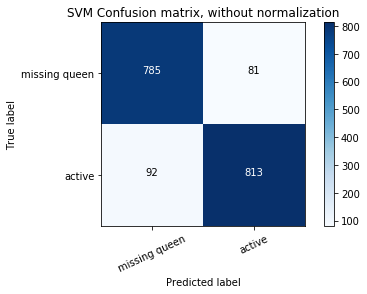

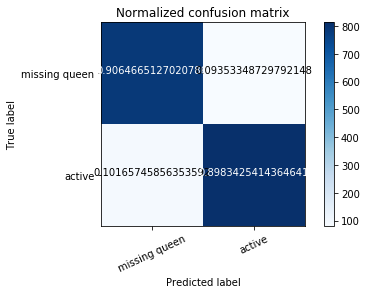

[2020-05-02 18:32:18 RAM67.0% 0.55GB] 
Clasification report SVM:
                precision    recall  f1-score   support

missing_queen       0.90      0.91      0.90       866
       active       0.91      0.90      0.90       905

     accuracy                           0.90      1771
    macro avg       0.90      0.90      0.90      1771
 weighted avg       0.90      0.90      0.90      1771



In [120]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Test_GroundT, Test_Preds )
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='SVM Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
target_names=['missing_queen', 'active']
print ('\nClasification report SVM:\n', classification_report(Test_GroundT, Test_Preds , target_names=target_names))

# CNN Classification 

In [121]:
X= X.reshape(-1, 20, 44, 1)
Y=Y.reshape(-1, 1)
X.shape, Y.shape

((17702, 20, 44, 1), (17702, 1))

In [122]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays

X = np.array(X.tolist())
y = np.array(Y.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.1, random_state = 42)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [123]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15931, 20, 44, 1), (1771, 20, 44, 1), (15931, 2), (1771, 2))

In [127]:
import keras 
from keras.models import Sequential, Input, Model 
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D , MaxPooling2D
from keras.layers.normalization import BatchNormalization 
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop



# Neural Network Architecture 
model=Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=( 20,44, 1), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
# we add the dropout to skip the overfitting 
# model.add(Dropout(0.25))



model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))

# we add the dropout to skip the overfitting 
# model.add(Dropout(0.25))

model.add(Conv2D(16, kernel_size=(3,1), activation='relu', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
#model.add(Dropout(0.25))

model.add(Conv2D(16, kernel_size=(3,1), activation='relu', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))

# we add the dropout to skip the overfitting 
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))

model.add(Dense(32 , activation='relu'))
model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [128]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [129]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 20, 44, 16)        160       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 20, 44, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 22, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 22, 16)        2320      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 10, 22, 16)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 11, 16)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 11, 16)        

In [130]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1] 

1771/1771 [==============================] - ETA: 19 - ETA: 3 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 587us/step


In [131]:
print("Pre-training accuracy: %.4f%%" % accuracy)

[2020-05-02 18:35:34 RAM63.3% 0.68GB] Pre-training accuracy: 51.1011%


In [140]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from keras.callbacks import EarlyStopping

num_epochs = 50
num_batch_size = 145

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                              # verbose=1, save_best_only=True)
start = datetime.now()

adam= model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 15931 samples, validate on 1771 samples
Epoch 1/50
15931/15931 [==============================] - ETA: 16s - loss: 0.0319 - accuracy: 0.986 - ETA: 14s - loss: 0.0375 - accuracy: 0.986 - ETA: 13s - loss: 0.0320 - accuracy: 0.988 - ETA: 13s - loss: 0.0364 - accuracy: 0.989 - ETA: 12s - loss: 0.0388 - accuracy: 0.987 - ETA: 12s - loss: 0.0492 - accuracy: 0.985 - ETA: 12s - loss: 0.0560 - accuracy: 0.982 - ETA: 12s - loss: 0.0509 - accuracy: 0.983 - ETA: 12s - loss: 0.0532 - accuracy: 0.983 - ETA: 12s - loss: 0.0491 - accuracy: 0.984 - ETA: 12s - loss: 0.0451 - accuracy: 0.986 - ETA: 11s - loss: 0.0448 - accuracy: 0.986 - ETA: 11s - loss: 0.0431 - accuracy: 0.986 - ETA: 11s - loss: 0.0408 - accuracy: 0.987 - ETA: 11s - loss: 0.0387 - accuracy: 0.988 - ETA: 11s - loss: 0.0378 - accuracy: 0.987 - ETA: 11s - loss: 0.0392 - accuracy: 0.987 - ETA: 11s - loss: 0.0416 - accuracy: 0.986 - ETA: 11s - loss: 0.0409 - accuracy: 0.986 - ETA: 10s - loss: 0.0434 - accuracy: 0.986 - ETA: 10s - lo

15931/15931 [==============================] - ETA: 12s - loss: 0.0132 - accuracy: 0.993 - ETA: 12s - loss: 0.0168 - accuracy: 0.993 - ETA: 12s - loss: 0.0163 - accuracy: 0.993 - ETA: 12s - loss: 0.0441 - accuracy: 0.987 - ETA: 12s - loss: 0.0599 - accuracy: 0.977 - ETA: 12s - loss: 0.0613 - accuracy: 0.977 - ETA: 12s - loss: 0.0568 - accuracy: 0.978 - ETA: 12s - loss: 0.0524 - accuracy: 0.980 - ETA: 12s - loss: 0.0527 - accuracy: 0.979 - ETA: 12s - loss: 0.0478 - accuracy: 0.981 - ETA: 11s - loss: 0.0445 - accuracy: 0.982 - ETA: 11s - loss: 0.0439 - accuracy: 0.982 - ETA: 11s - loss: 0.0433 - accuracy: 0.982 - ETA: 11s - loss: 0.0426 - accuracy: 0.982 - ETA: 11s - loss: 0.0408 - accuracy: 0.983 - ETA: 11s - loss: 0.0395 - accuracy: 0.983 - ETA: 11s - loss: 0.0401 - accuracy: 0.984 - ETA: 11s - loss: 0.0386 - accuracy: 0.985 - ETA: 11s - loss: 0.0374 - accuracy: 0.985 - ETA: 10s - loss: 0.0367 - accuracy: 0.985 - ETA: 10s - loss: 0.0359 - accuracy: 0.985 - ETA: 10s - loss: 0.0355 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0370 - accuracy: 0.993 - ETA: 12s - loss: 0.0384 - accuracy: 0.989 - ETA: 12s - loss: 0.0357 - accuracy: 0.990 - ETA: 12s - loss: 0.0288 - accuracy: 0.993 - ETA: 12s - loss: 0.0265 - accuracy: 0.993 - ETA: 12s - loss: 0.0235 - accuracy: 0.994 - ETA: 12s - loss: 0.0209 - accuracy: 0.995 - ETA: 12s - loss: 0.0275 - accuracy: 0.992 - ETA: 12s - loss: 0.0363 - accuracy: 0.990 - ETA: 11s - loss: 0.0372 - accuracy: 0.989 - ETA: 11s - loss: 0.0394 - accuracy: 0.987 - ETA: 11s - loss: 0.0372 - accuracy: 0.988 - ETA: 11s - loss: 0.0383 - accuracy: 0.987 - ETA: 11s - loss: 0.0366 - accuracy: 0.988 - ETA: 11s - loss: 0.0355 - accuracy: 0.988 - ETA: 11s - loss: 0.0342 - accuracy: 0.988 - ETA: 11s - loss: 0.0330 - accuracy: 0.989 - ETA: 10s - loss: 0.0330 - accuracy: 0.989 - ETA: 10s - loss: 0.0327 - accuracy: 0.989 - ETA: 10s - loss: 0.0317 - accuracy: 0.989 - ETA: 10s - loss: 0.0324 - accuracy: 0.989 - ETA: 10s - loss: 0.0331 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0238 - accuracy: 0.986 - ETA: 12s - loss: 0.0200 - accuracy: 0.986 - ETA: 12s - loss: 0.0142 - accuracy: 0.990 - ETA: 12s - loss: 0.0154 - accuracy: 0.991 - ETA: 12s - loss: 0.0162 - accuracy: 0.990 - ETA: 12s - loss: 0.0152 - accuracy: 0.992 - ETA: 12s - loss: 0.0162 - accuracy: 0.992 - ETA: 12s - loss: 0.0157 - accuracy: 0.992 - ETA: 12s - loss: 0.0154 - accuracy: 0.992 - ETA: 12s - loss: 0.0161 - accuracy: 0.991 - ETA: 11s - loss: 0.0167 - accuracy: 0.991 - ETA: 11s - loss: 0.0158 - accuracy: 0.992 - ETA: 11s - loss: 0.0188 - accuracy: 0.992 - ETA: 11s - loss: 0.0229 - accuracy: 0.990 - ETA: 11s - loss: 0.0308 - accuracy: 0.988 - ETA: 11s - loss: 0.0298 - accuracy: 0.989 - ETA: 11s - loss: 0.0288 - accuracy: 0.989 - ETA: 11s - loss: 0.0275 - accuracy: 0.990 - ETA: 11s - loss: 0.0280 - accuracy: 0.989 - ETA: 11s - loss: 0.0277 - accuracy: 0.990 - ETA: 10s - loss: 0.0273 - accuracy: 0.990 - ETA: 10s - loss: 0.0284 - acc

15931/15931 [==============================] - ETA: 13s - loss: 0.0168 - accuracy: 1.000 - ETA: 13s - loss: 0.0108 - accuracy: 1.000 - ETA: 12s - loss: 0.0077 - accuracy: 1.000 - ETA: 12s - loss: 0.0201 - accuracy: 0.994 - ETA: 12s - loss: 0.0279 - accuracy: 0.993 - ETA: 12s - loss: 0.0366 - accuracy: 0.989 - ETA: 12s - loss: 0.0370 - accuracy: 0.988 - ETA: 12s - loss: 0.0329 - accuracy: 0.989 - ETA: 12s - loss: 0.0305 - accuracy: 0.990 - ETA: 11s - loss: 0.0281 - accuracy: 0.991 - ETA: 11s - loss: 0.0280 - accuracy: 0.991 - ETA: 11s - loss: 0.0281 - accuracy: 0.990 - ETA: 11s - loss: 0.0263 - accuracy: 0.991 - ETA: 11s - loss: 0.0252 - accuracy: 0.992 - ETA: 11s - loss: 0.0238 - accuracy: 0.992 - ETA: 11s - loss: 0.0238 - accuracy: 0.992 - ETA: 11s - loss: 0.0229 - accuracy: 0.993 - ETA: 10s - loss: 0.0235 - accuracy: 0.992 - ETA: 10s - loss: 0.0250 - accuracy: 0.992 - ETA: 10s - loss: 0.0292 - accuracy: 0.991 - ETA: 10s - loss: 0.0296 - accuracy: 0.990 - ETA: 10s - loss: 0.0304 - acc

15931/15931 [==============================] - ETA: 13s - loss: 0.0016 - accuracy: 1.000 - ETA: 13s - loss: 0.0146 - accuracy: 0.993 - ETA: 13s - loss: 0.0112 - accuracy: 0.995 - ETA: 13s - loss: 0.0090 - accuracy: 0.996 - ETA: 13s - loss: 0.0077 - accuracy: 0.997 - ETA: 13s - loss: 0.0074 - accuracy: 0.997 - ETA: 13s - loss: 0.0064 - accuracy: 0.998 - ETA: 13s - loss: 0.0130 - accuracy: 0.996 - ETA: 13s - loss: 0.0141 - accuracy: 0.996 - ETA: 12s - loss: 0.0279 - accuracy: 0.993 - ETA: 12s - loss: 0.0392 - accuracy: 0.990 - ETA: 12s - loss: 0.0369 - accuracy: 0.991 - ETA: 12s - loss: 0.0410 - accuracy: 0.991 - ETA: 12s - loss: 0.0391 - accuracy: 0.991 - ETA: 12s - loss: 0.0376 - accuracy: 0.991 - ETA: 12s - loss: 0.0419 - accuracy: 0.989 - ETA: 11s - loss: 0.0411 - accuracy: 0.989 - ETA: 11s - loss: 0.0391 - accuracy: 0.990 - ETA: 11s - loss: 0.0373 - accuracy: 0.990 - ETA: 11s - loss: 0.0360 - accuracy: 0.991 - ETA: 11s - loss: 0.0345 - accuracy: 0.991 - ETA: 11s - loss: 0.0337 - acc

15931/15931 [==============================] - ETA: 13s - loss: 0.0516 - accuracy: 0.979 - ETA: 12s - loss: 0.1151 - accuracy: 0.958 - ETA: 12s - loss: 0.0906 - accuracy: 0.967 - ETA: 12s - loss: 0.0694 - accuracy: 0.975 - ETA: 12s - loss: 0.0560 - accuracy: 0.980 - ETA: 13s - loss: 0.0485 - accuracy: 0.983 - ETA: 13s - loss: 0.0442 - accuracy: 0.985 - ETA: 12s - loss: 0.0414 - accuracy: 0.986 - ETA: 12s - loss: 0.0377 - accuracy: 0.987 - ETA: 12s - loss: 0.0341 - accuracy: 0.989 - ETA: 12s - loss: 0.0331 - accuracy: 0.988 - ETA: 12s - loss: 0.0327 - accuracy: 0.989 - ETA: 12s - loss: 0.0316 - accuracy: 0.989 - ETA: 11s - loss: 0.0384 - accuracy: 0.987 - ETA: 11s - loss: 0.0366 - accuracy: 0.988 - ETA: 11s - loss: 0.0348 - accuracy: 0.988 - ETA: 11s - loss: 0.0341 - accuracy: 0.988 - ETA: 11s - loss: 0.0324 - accuracy: 0.989 - ETA: 11s - loss: 0.0307 - accuracy: 0.989 - ETA: 11s - loss: 0.0294 - accuracy: 0.990 - ETA: 11s - loss: 0.0296 - accuracy: 0.990 - ETA: 10s - loss: 0.0309 - acc

15931/15931 [==============================] - ETA: 11s - loss: 0.0093 - accuracy: 1.000 - ETA: 12s - loss: 0.0210 - accuracy: 0.993 - ETA: 12s - loss: 0.0392 - accuracy: 0.988 - ETA: 12s - loss: 0.0304 - accuracy: 0.991 - ETA: 12s - loss: 0.0263 - accuracy: 0.991 - ETA: 12s - loss: 0.0230 - accuracy: 0.993 - ETA: 12s - loss: 0.0249 - accuracy: 0.991 - ETA: 12s - loss: 0.0243 - accuracy: 0.990 - ETA: 12s - loss: 0.0225 - accuracy: 0.991 - ETA: 12s - loss: 0.0212 - accuracy: 0.991 - ETA: 11s - loss: 0.0197 - accuracy: 0.992 - ETA: 11s - loss: 0.0198 - accuracy: 0.992 - ETA: 11s - loss: 0.0190 - accuracy: 0.992 - ETA: 11s - loss: 0.0188 - accuracy: 0.993 - ETA: 11s - loss: 0.0177 - accuracy: 0.993 - ETA: 11s - loss: 0.0169 - accuracy: 0.994 - ETA: 11s - loss: 0.0216 - accuracy: 0.993 - ETA: 10s - loss: 0.0263 - accuracy: 0.992 - ETA: 10s - loss: 0.0283 - accuracy: 0.992 - ETA: 10s - loss: 0.0300 - accuracy: 0.991 - ETA: 10s - loss: 0.0312 - accuracy: 0.990 - ETA: 10s - loss: 0.0299 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0180 - accuracy: 0.986 - ETA: 12s - loss: 0.0097 - accuracy: 0.993 - ETA: 12s - loss: 0.0085 - accuracy: 0.995 - ETA: 12s - loss: 0.0109 - accuracy: 0.993 - ETA: 12s - loss: 0.0139 - accuracy: 0.993 - ETA: 12s - loss: 0.0118 - accuracy: 0.994 - ETA: 12s - loss: 0.0112 - accuracy: 0.995 - ETA: 12s - loss: 0.0119 - accuracy: 0.994 - ETA: 12s - loss: 0.0111 - accuracy: 0.994 - ETA: 11s - loss: 0.0111 - accuracy: 0.994 - ETA: 11s - loss: 0.0129 - accuracy: 0.994 - ETA: 11s - loss: 0.0150 - accuracy: 0.992 - ETA: 11s - loss: 0.0140 - accuracy: 0.993 - ETA: 11s - loss: 0.0137 - accuracy: 0.993 - ETA: 11s - loss: 0.0167 - accuracy: 0.991 - ETA: 11s - loss: 0.0255 - accuracy: 0.989 - ETA: 11s - loss: 0.0320 - accuracy: 0.987 - ETA: 10s - loss: 0.0314 - accuracy: 0.987 - ETA: 10s - loss: 0.0322 - accuracy: 0.986 - ETA: 10s - loss: 0.0308 - accuracy: 0.987 - ETA: 10s - loss: 0.0303 - accuracy: 0.987 - ETA: 10s - loss: 0.0297 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0140 - accuracy: 1.000 - ETA: 13s - loss: 0.0168 - accuracy: 0.993 - ETA: 12s - loss: 0.0155 - accuracy: 0.993 - ETA: 12s - loss: 0.0148 - accuracy: 0.993 - ETA: 12s - loss: 0.0142 - accuracy: 0.993 - ETA: 12s - loss: 0.0127 - accuracy: 0.994 - ETA: 12s - loss: 0.0130 - accuracy: 0.994 - ETA: 11s - loss: 0.0118 - accuracy: 0.994 - ETA: 11s - loss: 0.0110 - accuracy: 0.995 - ETA: 11s - loss: 0.0129 - accuracy: 0.994 - ETA: 11s - loss: 0.0119 - accuracy: 0.995 - ETA: 11s - loss: 0.0120 - accuracy: 0.994 - ETA: 11s - loss: 0.0119 - accuracy: 0.994 - ETA: 11s - loss: 0.0115 - accuracy: 0.995 - ETA: 11s - loss: 0.0117 - accuracy: 0.994 - ETA: 11s - loss: 0.0114 - accuracy: 0.994 - ETA: 11s - loss: 0.0109 - accuracy: 0.995 - ETA: 10s - loss: 0.0125 - accuracy: 0.994 - ETA: 10s - loss: 0.0123 - accuracy: 0.994 - ETA: 10s - loss: 0.0120 - accuracy: 0.995 - ETA: 10s - loss: 0.0119 - accuracy: 0.995 - ETA: 10s - loss: 0.0117 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0026 - accuracy: 1.000 - ETA: 13s - loss: 0.0070 - accuracy: 1.000 - ETA: 13s - loss: 0.0055 - accuracy: 1.000 - ETA: 13s - loss: 0.0119 - accuracy: 0.998 - ETA: 13s - loss: 0.0134 - accuracy: 0.997 - ETA: 13s - loss: 0.0131 - accuracy: 0.996 - ETA: 12s - loss: 0.0118 - accuracy: 0.997 - ETA: 12s - loss: 0.0106 - accuracy: 0.997 - ETA: 12s - loss: 0.0102 - accuracy: 0.996 - ETA: 12s - loss: 0.0096 - accuracy: 0.997 - ETA: 12s - loss: 0.0089 - accuracy: 0.997 - ETA: 12s - loss: 0.0082 - accuracy: 0.997 - ETA: 12s - loss: 0.0079 - accuracy: 0.997 - ETA: 12s - loss: 0.0074 - accuracy: 0.998 - ETA: 11s - loss: 0.0071 - accuracy: 0.998 - ETA: 11s - loss: 0.0068 - accuracy: 0.998 - ETA: 11s - loss: 0.0066 - accuracy: 0.998 - ETA: 11s - loss: 0.0065 - accuracy: 0.998 - ETA: 11s - loss: 0.0063 - accuracy: 0.998 - ETA: 11s - loss: 0.0067 - accuracy: 0.998 - ETA: 11s - loss: 0.0082 - accuracy: 0.997 - ETA: 11s - loss: 0.0082 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0530 - accuracy: 0.986 - ETA: 13s - loss: 0.0499 - accuracy: 0.982 - ETA: 12s - loss: 0.0398 - accuracy: 0.986 - ETA: 12s - loss: 0.0426 - accuracy: 0.984 - ETA: 13s - loss: 0.0361 - accuracy: 0.987 - ETA: 13s - loss: 0.0305 - accuracy: 0.989 - ETA: 12s - loss: 0.0278 - accuracy: 0.991 - ETA: 12s - loss: 0.0300 - accuracy: 0.991 - ETA: 12s - loss: 0.0267 - accuracy: 0.992 - ETA: 12s - loss: 0.0243 - accuracy: 0.993 - ETA: 12s - loss: 0.0240 - accuracy: 0.993 - ETA: 12s - loss: 0.0231 - accuracy: 0.993 - ETA: 12s - loss: 0.0225 - accuracy: 0.992 - ETA: 12s - loss: 0.0211 - accuracy: 0.993 - ETA: 12s - loss: 0.0199 - accuracy: 0.993 - ETA: 11s - loss: 0.0187 - accuracy: 0.994 - ETA: 11s - loss: 0.0181 - accuracy: 0.993 - ETA: 11s - loss: 0.0178 - accuracy: 0.993 - ETA: 11s - loss: 0.0174 - accuracy: 0.994 - ETA: 11s - loss: 0.0181 - accuracy: 0.994 - ETA: 11s - loss: 0.0178 - accuracy: 0.994 - ETA: 11s - loss: 0.0171 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0258 - accuracy: 0.993 - ETA: 13s - loss: 0.0140 - accuracy: 0.996 - ETA: 13s - loss: 0.0227 - accuracy: 0.995 - ETA: 13s - loss: 0.0185 - accuracy: 0.996 - ETA: 13s - loss: 0.0161 - accuracy: 0.997 - ETA: 12s - loss: 0.0136 - accuracy: 0.997 - ETA: 12s - loss: 0.0132 - accuracy: 0.997 - ETA: 12s - loss: 0.0136 - accuracy: 0.996 - ETA: 12s - loss: 0.0178 - accuracy: 0.994 - ETA: 12s - loss: 0.0216 - accuracy: 0.993 - ETA: 12s - loss: 0.0274 - accuracy: 0.993 - ETA: 12s - loss: 0.0262 - accuracy: 0.993 - ETA: 12s - loss: 0.0261 - accuracy: 0.993 - ETA: 11s - loss: 0.0246 - accuracy: 0.993 - ETA: 11s - loss: 0.0241 - accuracy: 0.993 - ETA: 11s - loss: 0.0231 - accuracy: 0.994 - ETA: 11s - loss: 0.0220 - accuracy: 0.994 - ETA: 11s - loss: 0.0217 - accuracy: 0.994 - ETA: 11s - loss: 0.0209 - accuracy: 0.994 - ETA: 11s - loss: 0.0207 - accuracy: 0.994 - ETA: 11s - loss: 0.0198 - accuracy: 0.994 - ETA: 10s - loss: 0.0190 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0085 - accuracy: 1.000 - ETA: 12s - loss: 0.0204 - accuracy: 0.996 - ETA: 12s - loss: 0.0260 - accuracy: 0.995 - ETA: 13s - loss: 0.0202 - accuracy: 0.996 - ETA: 13s - loss: 0.0166 - accuracy: 0.997 - ETA: 13s - loss: 0.0148 - accuracy: 0.997 - ETA: 12s - loss: 0.0134 - accuracy: 0.998 - ETA: 12s - loss: 0.0184 - accuracy: 0.995 - ETA: 12s - loss: 0.0174 - accuracy: 0.995 - ETA: 12s - loss: 0.0165 - accuracy: 0.995 - ETA: 12s - loss: 0.0172 - accuracy: 0.995 - ETA: 11s - loss: 0.0170 - accuracy: 0.994 - ETA: 12s - loss: 0.0255 - accuracy: 0.993 - ETA: 11s - loss: 0.0298 - accuracy: 0.993 - ETA: 11s - loss: 0.0286 - accuracy: 0.993 - ETA: 11s - loss: 0.0271 - accuracy: 0.993 - ETA: 11s - loss: 0.0276 - accuracy: 0.992 - ETA: 11s - loss: 0.0268 - accuracy: 0.992 - ETA: 11s - loss: 0.0257 - accuracy: 0.993 - ETA: 11s - loss: 0.0246 - accuracy: 0.993 - ETA: 10s - loss: 0.0235 - accuracy: 0.993 - ETA: 10s - loss: 0.0231 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0191 - accuracy: 0.993 - ETA: 13s - loss: 0.0274 - accuracy: 0.986 - ETA: 13s - loss: 0.0293 - accuracy: 0.986 - ETA: 12s - loss: 0.0355 - accuracy: 0.986 - ETA: 12s - loss: 0.0331 - accuracy: 0.986 - ETA: 12s - loss: 0.0306 - accuracy: 0.987 - ETA: 12s - loss: 0.0276 - accuracy: 0.989 - ETA: 12s - loss: 0.0295 - accuracy: 0.989 - ETA: 11s - loss: 0.0277 - accuracy: 0.990 - ETA: 11s - loss: 0.0251 - accuracy: 0.991 - ETA: 11s - loss: 0.0236 - accuracy: 0.991 - ETA: 11s - loss: 0.0217 - accuracy: 0.992 - ETA: 11s - loss: 0.0201 - accuracy: 0.993 - ETA: 11s - loss: 0.0190 - accuracy: 0.993 - ETA: 11s - loss: 0.0231 - accuracy: 0.992 - ETA: 11s - loss: 0.0240 - accuracy: 0.991 - ETA: 11s - loss: 0.0235 - accuracy: 0.991 - ETA: 10s - loss: 0.0224 - accuracy: 0.992 - ETA: 10s - loss: 0.0219 - accuracy: 0.992 - ETA: 10s - loss: 0.0212 - accuracy: 0.992 - ETA: 10s - loss: 0.0205 - accuracy: 0.992 - ETA: 10s - loss: 0.0196 - acc

15931/15931 [==============================] - ETA: 15s - loss: 0.0019 - accuracy: 1.000 - ETA: 14s - loss: 0.0022 - accuracy: 1.000 - ETA: 13s - loss: 0.0087 - accuracy: 0.997 - ETA: 13s - loss: 0.0186 - accuracy: 0.993 - ETA: 13s - loss: 0.0274 - accuracy: 0.989 - ETA: 13s - loss: 0.0238 - accuracy: 0.990 - ETA: 13s - loss: 0.0213 - accuracy: 0.992 - ETA: 12s - loss: 0.0189 - accuracy: 0.993 - ETA: 12s - loss: 0.0183 - accuracy: 0.993 - ETA: 12s - loss: 0.0177 - accuracy: 0.993 - ETA: 12s - loss: 0.0181 - accuracy: 0.992 - ETA: 12s - loss: 0.0185 - accuracy: 0.992 - ETA: 12s - loss: 0.0179 - accuracy: 0.992 - ETA: 12s - loss: 0.0173 - accuracy: 0.992 - ETA: 11s - loss: 0.0164 - accuracy: 0.993 - ETA: 11s - loss: 0.0155 - accuracy: 0.993 - ETA: 11s - loss: 0.0151 - accuracy: 0.993 - ETA: 11s - loss: 0.0153 - accuracy: 0.993 - ETA: 11s - loss: 0.0182 - accuracy: 0.992 - ETA: 11s - loss: 0.0188 - accuracy: 0.992 - ETA: 11s - loss: 0.0179 - accuracy: 0.993 - ETA: 11s - loss: 0.0200 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0105 - accuracy: 0.993 - ETA: 12s - loss: 0.0175 - accuracy: 0.993 - ETA: 12s - loss: 0.0130 - accuracy: 0.995 - ETA: 12s - loss: 0.0115 - accuracy: 0.994 - ETA: 12s - loss: 0.0106 - accuracy: 0.995 - ETA: 12s - loss: 0.0146 - accuracy: 0.993 - ETA: 12s - loss: 0.0140 - accuracy: 0.993 - ETA: 12s - loss: 0.0129 - accuracy: 0.994 - ETA: 12s - loss: 0.0120 - accuracy: 0.994 - ETA: 12s - loss: 0.0111 - accuracy: 0.995 - ETA: 12s - loss: 0.0109 - accuracy: 0.995 - ETA: 11s - loss: 0.0103 - accuracy: 0.995 - ETA: 11s - loss: 0.0096 - accuracy: 0.995 - ETA: 11s - loss: 0.0112 - accuracy: 0.995 - ETA: 11s - loss: 0.0128 - accuracy: 0.995 - ETA: 11s - loss: 0.0139 - accuracy: 0.994 - ETA: 11s - loss: 0.0145 - accuracy: 0.994 - ETA: 11s - loss: 0.0147 - accuracy: 0.993 - ETA: 10s - loss: 0.0175 - accuracy: 0.993 - ETA: 10s - loss: 0.0171 - accuracy: 0.993 - ETA: 10s - loss: 0.0179 - accuracy: 0.993 - ETA: 10s - loss: 0.0176 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0016 - accuracy: 1.000 - ETA: 12s - loss: 0.0031 - accuracy: 1.000 - ETA: 13s - loss: 0.0023 - accuracy: 1.000 - ETA: 12s - loss: 0.0018 - accuracy: 1.000 - ETA: 12s - loss: 0.0056 - accuracy: 0.998 - ETA: 12s - loss: 0.0054 - accuracy: 0.998 - ETA: 12s - loss: 0.0152 - accuracy: 0.996 - ETA: 12s - loss: 0.0317 - accuracy: 0.992 - ETA: 12s - loss: 0.0289 - accuracy: 0.993 - ETA: 11s - loss: 0.0275 - accuracy: 0.993 - ETA: 11s - loss: 0.0253 - accuracy: 0.993 - ETA: 11s - loss: 0.0236 - accuracy: 0.994 - ETA: 11s - loss: 0.0222 - accuracy: 0.994 - ETA: 11s - loss: 0.0210 - accuracy: 0.995 - ETA: 11s - loss: 0.0197 - accuracy: 0.995 - ETA: 11s - loss: 0.0191 - accuracy: 0.995 - ETA: 11s - loss: 0.0187 - accuracy: 0.995 - ETA: 10s - loss: 0.0178 - accuracy: 0.995 - ETA: 10s - loss: 0.0169 - accuracy: 0.995 - ETA: 10s - loss: 0.0170 - accuracy: 0.995 - ETA: 10s - loss: 0.0162 - accuracy: 0.995 - ETA: 10s - loss: 0.0155 - acc

15931/15931 [==============================] - ETA: 14s - loss: 0.0255 - accuracy: 0.986 - ETA: 13s - loss: 0.0274 - accuracy: 0.982 - ETA: 13s - loss: 0.0806 - accuracy: 0.979 - ETA: 13s - loss: 0.0850 - accuracy: 0.979 - ETA: 12s - loss: 0.0744 - accuracy: 0.980 - ETA: 12s - loss: 0.0628 - accuracy: 0.983 - ETA: 12s - loss: 0.0541 - accuracy: 0.986 - ETA: 12s - loss: 0.0486 - accuracy: 0.987 - ETA: 12s - loss: 0.0436 - accuracy: 0.988 - ETA: 12s - loss: 0.0435 - accuracy: 0.989 - ETA: 12s - loss: 0.0419 - accuracy: 0.988 - ETA: 12s - loss: 0.0394 - accuracy: 0.989 - ETA: 11s - loss: 0.0383 - accuracy: 0.989 - ETA: 11s - loss: 0.0380 - accuracy: 0.989 - ETA: 11s - loss: 0.0364 - accuracy: 0.989 - ETA: 11s - loss: 0.0343 - accuracy: 0.990 - ETA: 11s - loss: 0.0330 - accuracy: 0.990 - ETA: 11s - loss: 0.0319 - accuracy: 0.990 - ETA: 11s - loss: 0.0312 - accuracy: 0.990 - ETA: 11s - loss: 0.0325 - accuracy: 0.990 - ETA: 11s - loss: 0.0336 - accuracy: 0.990 - ETA: 11s - loss: 0.0337 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0516 - accuracy: 0.993 - ETA: 12s - loss: 0.0439 - accuracy: 0.993 - ETA: 12s - loss: 0.0351 - accuracy: 0.993 - ETA: 12s - loss: 0.0267 - accuracy: 0.994 - ETA: 12s - loss: 0.0227 - accuracy: 0.995 - ETA: 12s - loss: 0.0199 - accuracy: 0.996 - ETA: 12s - loss: 0.0172 - accuracy: 0.997 - ETA: 12s - loss: 0.0155 - accuracy: 0.997 - ETA: 12s - loss: 0.0139 - accuracy: 0.997 - ETA: 12s - loss: 0.0129 - accuracy: 0.997 - ETA: 11s - loss: 0.0133 - accuracy: 0.997 - ETA: 12s - loss: 0.0126 - accuracy: 0.997 - ETA: 12s - loss: 0.0123 - accuracy: 0.997 - ETA: 11s - loss: 0.0118 - accuracy: 0.997 - ETA: 11s - loss: 0.0122 - accuracy: 0.996 - ETA: 11s - loss: 0.0165 - accuracy: 0.996 - ETA: 11s - loss: 0.0161 - accuracy: 0.996 - ETA: 11s - loss: 0.0152 - accuracy: 0.996 - ETA: 11s - loss: 0.0147 - accuracy: 0.996 - ETA: 10s - loss: 0.0156 - accuracy: 0.996 - ETA: 10s - loss: 0.0162 - accuracy: 0.996 - ETA: 10s - loss: 0.0163 - acc

15931/15931 [==============================] - ETA: 13s - loss: 0.0110 - accuracy: 0.993 - ETA: 13s - loss: 0.0065 - accuracy: 0.996 - ETA: 12s - loss: 0.0073 - accuracy: 0.995 - ETA: 12s - loss: 0.0185 - accuracy: 0.993 - ETA: 12s - loss: 0.0314 - accuracy: 0.990 - ETA: 12s - loss: 0.0346 - accuracy: 0.988 - ETA: 12s - loss: 0.0305 - accuracy: 0.990 - ETA: 12s - loss: 0.0286 - accuracy: 0.990 - ETA: 12s - loss: 0.0290 - accuracy: 0.990 - ETA: 12s - loss: 0.0288 - accuracy: 0.989 - ETA: 12s - loss: 0.0265 - accuracy: 0.990 - ETA: 12s - loss: 0.0246 - accuracy: 0.991 - ETA: 11s - loss: 0.0237 - accuracy: 0.991 - ETA: 11s - loss: 0.0221 - accuracy: 0.992 - ETA: 11s - loss: 0.0211 - accuracy: 0.992 - ETA: 11s - loss: 0.0199 - accuracy: 0.992 - ETA: 11s - loss: 0.0190 - accuracy: 0.993 - ETA: 11s - loss: 0.0183 - accuracy: 0.993 - ETA: 11s - loss: 0.0199 - accuracy: 0.993 - ETA: 10s - loss: 0.0198 - accuracy: 0.993 - ETA: 10s - loss: 0.0195 - accuracy: 0.993 - ETA: 10s - loss: 0.0189 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0269 - accuracy: 0.986 - ETA: 12s - loss: 0.0200 - accuracy: 0.989 - ETA: 12s - loss: 0.0152 - accuracy: 0.993 - ETA: 12s - loss: 0.0122 - accuracy: 0.994 - ETA: 12s - loss: 0.0159 - accuracy: 0.993 - ETA: 12s - loss: 0.0164 - accuracy: 0.993 - ETA: 12s - loss: 0.0168 - accuracy: 0.993 - ETA: 12s - loss: 0.0148 - accuracy: 0.994 - ETA: 12s - loss: 0.0219 - accuracy: 0.993 - ETA: 11s - loss: 0.0200 - accuracy: 0.993 - ETA: 11s - loss: 0.0196 - accuracy: 0.993 - ETA: 11s - loss: 0.0195 - accuracy: 0.993 - ETA: 11s - loss: 0.0191 - accuracy: 0.993 - ETA: 11s - loss: 0.0177 - accuracy: 0.993 - ETA: 11s - loss: 0.0166 - accuracy: 0.994 - ETA: 11s - loss: 0.0167 - accuracy: 0.994 - ETA: 11s - loss: 0.0209 - accuracy: 0.993 - ETA: 11s - loss: 0.0202 - accuracy: 0.993 - ETA: 10s - loss: 0.0192 - accuracy: 0.994 - ETA: 10s - loss: 0.0183 - accuracy: 0.994 - ETA: 10s - loss: 0.0183 - accuracy: 0.994 - ETA: 10s - loss: 0.0186 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0448 - accuracy: 0.993 - ETA: 12s - loss: 0.0281 - accuracy: 0.993 - ETA: 12s - loss: 0.0189 - accuracy: 0.995 - ETA: 12s - loss: 0.0147 - accuracy: 0.996 - ETA: 12s - loss: 0.0120 - accuracy: 0.997 - ETA: 12s - loss: 0.0109 - accuracy: 0.996 - ETA: 12s - loss: 0.0100 - accuracy: 0.997 - ETA: 12s - loss: 0.0164 - accuracy: 0.996 - ETA: 11s - loss: 0.0190 - accuracy: 0.994 - ETA: 11s - loss: 0.0175 - accuracy: 0.995 - ETA: 11s - loss: 0.0169 - accuracy: 0.995 - ETA: 11s - loss: 0.0156 - accuracy: 0.995 - ETA: 11s - loss: 0.0145 - accuracy: 0.995 - ETA: 11s - loss: 0.0152 - accuracy: 0.995 - ETA: 11s - loss: 0.0151 - accuracy: 0.995 - ETA: 11s - loss: 0.0141 - accuracy: 0.995 - ETA: 11s - loss: 0.0142 - accuracy: 0.995 - ETA: 10s - loss: 0.0142 - accuracy: 0.995 - ETA: 10s - loss: 0.0139 - accuracy: 0.995 - ETA: 10s - loss: 0.0138 - accuracy: 0.995 - ETA: 10s - loss: 0.0133 - accuracy: 0.995 - ETA: 10s - loss: 0.0129 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0021 - accuracy: 1.000 - ETA: 12s - loss: 0.0019 - accuracy: 1.000 - ETA: 13s - loss: 0.0186 - accuracy: 0.993 - ETA: 13s - loss: 0.0213 - accuracy: 0.991 - ETA: 13s - loss: 0.0178 - accuracy: 0.993 - ETA: 12s - loss: 0.0157 - accuracy: 0.994 - ETA: 12s - loss: 0.0135 - accuracy: 0.995 - ETA: 12s - loss: 0.0146 - accuracy: 0.994 - ETA: 12s - loss: 0.0178 - accuracy: 0.993 - ETA: 12s - loss: 0.0175 - accuracy: 0.993 - ETA: 12s - loss: 0.0161 - accuracy: 0.994 - ETA: 11s - loss: 0.0152 - accuracy: 0.994 - ETA: 11s - loss: 0.0147 - accuracy: 0.994 - ETA: 11s - loss: 0.0142 - accuracy: 0.994 - ETA: 11s - loss: 0.0134 - accuracy: 0.994 - ETA: 11s - loss: 0.0141 - accuracy: 0.994 - ETA: 11s - loss: 0.0135 - accuracy: 0.994 - ETA: 11s - loss: 0.0129 - accuracy: 0.995 - ETA: 11s - loss: 0.0122 - accuracy: 0.995 - ETA: 10s - loss: 0.0118 - accuracy: 0.995 - ETA: 10s - loss: 0.0115 - accuracy: 0.995 - ETA: 10s - loss: 0.0112 - acc

15931/15931 [==============================] - ETA: 13s - loss: 0.0069 - accuracy: 1.000 - ETA: 13s - loss: 0.0039 - accuracy: 1.000 - ETA: 13s - loss: 0.0038 - accuracy: 1.000 - ETA: 13s - loss: 0.0040 - accuracy: 1.000 - ETA: 13s - loss: 0.0092 - accuracy: 0.998 - ETA: 13s - loss: 0.0103 - accuracy: 0.997 - ETA: 13s - loss: 0.0089 - accuracy: 0.998 - ETA: 12s - loss: 0.0079 - accuracy: 0.998 - ETA: 12s - loss: 0.0071 - accuracy: 0.998 - ETA: 12s - loss: 0.0066 - accuracy: 0.998 - ETA: 12s - loss: 0.0087 - accuracy: 0.997 - ETA: 12s - loss: 0.0166 - accuracy: 0.994 - ETA: 12s - loss: 0.0231 - accuracy: 0.994 - ETA: 12s - loss: 0.0216 - accuracy: 0.994 - ETA: 12s - loss: 0.0218 - accuracy: 0.994 - ETA: 11s - loss: 0.0208 - accuracy: 0.994 - ETA: 11s - loss: 0.0197 - accuracy: 0.994 - ETA: 11s - loss: 0.0189 - accuracy: 0.995 - ETA: 11s - loss: 0.0182 - accuracy: 0.994 - ETA: 11s - loss: 0.0177 - accuracy: 0.994 - ETA: 11s - loss: 0.0169 - accuracy: 0.995 - ETA: 11s - loss: 0.0168 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0054 - accuracy: 1.000 - ETA: 13s - loss: 0.0046 - accuracy: 1.000 - ETA: 13s - loss: 0.0033 - accuracy: 1.000 - ETA: 12s - loss: 0.0027 - accuracy: 1.000 - ETA: 12s - loss: 0.0036 - accuracy: 1.000 - ETA: 12s - loss: 0.0030 - accuracy: 1.000 - ETA: 12s - loss: 0.0031 - accuracy: 1.000 - ETA: 12s - loss: 0.0043 - accuracy: 0.999 - ETA: 12s - loss: 0.0084 - accuracy: 0.997 - ETA: 11s - loss: 0.0123 - accuracy: 0.996 - ETA: 11s - loss: 0.0113 - accuracy: 0.996 - ETA: 11s - loss: 0.0126 - accuracy: 0.996 - ETA: 11s - loss: 0.0249 - accuracy: 0.994 - ETA: 11s - loss: 0.0234 - accuracy: 0.994 - ETA: 11s - loss: 0.0221 - accuracy: 0.994 - ETA: 11s - loss: 0.0208 - accuracy: 0.995 - ETA: 11s - loss: 0.0197 - accuracy: 0.995 - ETA: 10s - loss: 0.0194 - accuracy: 0.995 - ETA: 10s - loss: 0.0184 - accuracy: 0.995 - ETA: 10s - loss: 0.0175 - accuracy: 0.995 - ETA: 10s - loss: 0.0168 - accuracy: 0.996 - ETA: 10s - loss: 0.0162 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0234 - accuracy: 0.993 - ETA: 12s - loss: 0.0147 - accuracy: 0.993 - ETA: 12s - loss: 0.0129 - accuracy: 0.993 - ETA: 12s - loss: 0.0136 - accuracy: 0.993 - ETA: 12s - loss: 0.0124 - accuracy: 0.994 - ETA: 12s - loss: 0.0116 - accuracy: 0.994 - ETA: 12s - loss: 0.0102 - accuracy: 0.995 - ETA: 11s - loss: 0.0091 - accuracy: 0.995 - ETA: 11s - loss: 0.0085 - accuracy: 0.996 - ETA: 11s - loss: 0.0077 - accuracy: 0.996 - ETA: 11s - loss: 0.0070 - accuracy: 0.996 - ETA: 11s - loss: 0.0068 - accuracy: 0.997 - ETA: 11s - loss: 0.0063 - accuracy: 0.997 - ETA: 11s - loss: 0.0060 - accuracy: 0.997 - ETA: 11s - loss: 0.0057 - accuracy: 0.997 - ETA: 11s - loss: 0.0054 - accuracy: 0.997 - ETA: 10s - loss: 0.0052 - accuracy: 0.998 - ETA: 10s - loss: 0.0050 - accuracy: 0.998 - ETA: 10s - loss: 0.0049 - accuracy: 0.998 - ETA: 10s - loss: 0.0048 - accuracy: 0.998 - ETA: 10s - loss: 0.0062 - accuracy: 0.997 - ETA: 10s - loss: 0.0083 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0065 - accuracy: 1.000 - ETA: 12s - loss: 0.0093 - accuracy: 0.996 - ETA: 12s - loss: 0.0190 - accuracy: 0.995 - ETA: 12s - loss: 0.0295 - accuracy: 0.991 - ETA: 12s - loss: 0.0267 - accuracy: 0.993 - ETA: 12s - loss: 0.0225 - accuracy: 0.994 - ETA: 12s - loss: 0.0193 - accuracy: 0.995 - ETA: 12s - loss: 0.0212 - accuracy: 0.994 - ETA: 12s - loss: 0.0190 - accuracy: 0.995 - ETA: 11s - loss: 0.0174 - accuracy: 0.995 - ETA: 11s - loss: 0.0160 - accuracy: 0.996 - ETA: 11s - loss: 0.0166 - accuracy: 0.996 - ETA: 11s - loss: 0.0186 - accuracy: 0.995 - ETA: 11s - loss: 0.0180 - accuracy: 0.995 - ETA: 11s - loss: 0.0195 - accuracy: 0.994 - ETA: 11s - loss: 0.0186 - accuracy: 0.994 - ETA: 11s - loss: 0.0194 - accuracy: 0.993 - ETA: 11s - loss: 0.0184 - accuracy: 0.994 - ETA: 10s - loss: 0.0203 - accuracy: 0.993 - ETA: 10s - loss: 0.0196 - accuracy: 0.994 - ETA: 10s - loss: 0.0187 - accuracy: 0.994 - ETA: 10s - loss: 0.0185 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0025 - accuracy: 1.000 - ETA: 12s - loss: 0.0039 - accuracy: 1.000 - ETA: 12s - loss: 0.0032 - accuracy: 1.000 - ETA: 12s - loss: 0.0027 - accuracy: 1.000 - ETA: 12s - loss: 0.0059 - accuracy: 0.998 - ETA: 12s - loss: 0.0075 - accuracy: 0.997 - ETA: 12s - loss: 0.0068 - accuracy: 0.998 - ETA: 12s - loss: 0.0081 - accuracy: 0.996 - ETA: 11s - loss: 0.0096 - accuracy: 0.995 - ETA: 11s - loss: 0.0103 - accuracy: 0.995 - ETA: 11s - loss: 0.0098 - accuracy: 0.995 - ETA: 11s - loss: 0.0091 - accuracy: 0.996 - ETA: 11s - loss: 0.0090 - accuracy: 0.995 - ETA: 11s - loss: 0.0106 - accuracy: 0.995 - ETA: 11s - loss: 0.0105 - accuracy: 0.995 - ETA: 11s - loss: 0.0105 - accuracy: 0.995 - ETA: 11s - loss: 0.0100 - accuracy: 0.995 - ETA: 10s - loss: 0.0103 - accuracy: 0.995 - ETA: 10s - loss: 0.0106 - accuracy: 0.995 - ETA: 10s - loss: 0.0106 - accuracy: 0.995 - ETA: 10s - loss: 0.0103 - accuracy: 0.995 - ETA: 10s - loss: 0.0104 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0044 - accuracy: 1.000 - ETA: 12s - loss: 0.0061 - accuracy: 0.996 - ETA: 12s - loss: 0.0109 - accuracy: 0.995 - ETA: 13s - loss: 0.0099 - accuracy: 0.996 - ETA: 12s - loss: 0.0091 - accuracy: 0.995 - ETA: 12s - loss: 0.0077 - accuracy: 0.996 - ETA: 12s - loss: 0.0091 - accuracy: 0.996 - ETA: 12s - loss: 0.0081 - accuracy: 0.996 - ETA: 12s - loss: 0.0152 - accuracy: 0.995 - ETA: 12s - loss: 0.0141 - accuracy: 0.995 - ETA: 12s - loss: 0.0144 - accuracy: 0.995 - ETA: 11s - loss: 0.0134 - accuracy: 0.996 - ETA: 11s - loss: 0.0126 - accuracy: 0.996 - ETA: 11s - loss: 0.0117 - accuracy: 0.996 - ETA: 11s - loss: 0.0111 - accuracy: 0.996 - ETA: 11s - loss: 0.0105 - accuracy: 0.997 - ETA: 11s - loss: 0.0100 - accuracy: 0.997 - ETA: 11s - loss: 0.0102 - accuracy: 0.996 - ETA: 11s - loss: 0.0130 - accuracy: 0.996 - ETA: 10s - loss: 0.0127 - accuracy: 0.996 - ETA: 10s - loss: 0.0124 - accuracy: 0.996 - ETA: 10s - loss: 0.0119 - acc

15931/15931 [==============================] - ETA: 11s - loss: 0.0016 - accuracy: 1.000 - ETA: 11s - loss: 0.0053 - accuracy: 0.996 - ETA: 12s - loss: 0.0037 - accuracy: 0.997 - ETA: 12s - loss: 0.0041 - accuracy: 0.996 - ETA: 12s - loss: 0.0119 - accuracy: 0.994 - ETA: 12s - loss: 0.0113 - accuracy: 0.995 - ETA: 11s - loss: 0.0126 - accuracy: 0.995 - ETA: 11s - loss: 0.0146 - accuracy: 0.994 - ETA: 11s - loss: 0.0131 - accuracy: 0.994 - ETA: 11s - loss: 0.0121 - accuracy: 0.995 - ETA: 11s - loss: 0.0111 - accuracy: 0.995 - ETA: 11s - loss: 0.0103 - accuracy: 0.996 - ETA: 11s - loss: 0.0096 - accuracy: 0.996 - ETA: 11s - loss: 0.0101 - accuracy: 0.996 - ETA: 11s - loss: 0.0107 - accuracy: 0.995 - ETA: 11s - loss: 0.0101 - accuracy: 0.996 - ETA: 11s - loss: 0.0097 - accuracy: 0.996 - ETA: 11s - loss: 0.0094 - accuracy: 0.996 - ETA: 10s - loss: 0.0093 - accuracy: 0.996 - ETA: 10s - loss: 0.0088 - accuracy: 0.996 - ETA: 10s - loss: 0.0088 - accuracy: 0.996 - ETA: 10s - loss: 0.0134 - acc

15931/15931 [==============================] - ETA: 13s - loss: 0.0049 - accuracy: 1.000 - ETA: 13s - loss: 0.0092 - accuracy: 0.996 - ETA: 12s - loss: 0.0207 - accuracy: 0.993 - ETA: 12s - loss: 0.0174 - accuracy: 0.993 - ETA: 12s - loss: 0.0164 - accuracy: 0.993 - ETA: 12s - loss: 0.0146 - accuracy: 0.993 - ETA: 12s - loss: 0.0127 - accuracy: 0.994 - ETA: 12s - loss: 0.0112 - accuracy: 0.994 - ETA: 12s - loss: 0.0100 - accuracy: 0.995 - ETA: 12s - loss: 0.0093 - accuracy: 0.995 - ETA: 11s - loss: 0.0090 - accuracy: 0.996 - ETA: 11s - loss: 0.0097 - accuracy: 0.995 - ETA: 11s - loss: 0.0093 - accuracy: 0.995 - ETA: 11s - loss: 0.0094 - accuracy: 0.995 - ETA: 11s - loss: 0.0090 - accuracy: 0.995 - ETA: 11s - loss: 0.0091 - accuracy: 0.996 - ETA: 11s - loss: 0.0108 - accuracy: 0.995 - ETA: 11s - loss: 0.0122 - accuracy: 0.995 - ETA: 11s - loss: 0.0117 - accuracy: 0.995 - ETA: 10s - loss: 0.0124 - accuracy: 0.995 - ETA: 10s - loss: 0.0127 - accuracy: 0.994 - ETA: 10s - loss: 0.0144 - acc

15931/15931 [==============================] - ETA: 11s - loss: 0.0439 - accuracy: 0.979 - ETA: 12s - loss: 0.0264 - accuracy: 0.989 - ETA: 12s - loss: 0.0181 - accuracy: 0.993 - ETA: 12s - loss: 0.0142 - accuracy: 0.994 - ETA: 12s - loss: 0.0218 - accuracy: 0.993 - ETA: 12s - loss: 0.0187 - accuracy: 0.994 - ETA: 12s - loss: 0.0180 - accuracy: 0.994 - ETA: 12s - loss: 0.0160 - accuracy: 0.994 - ETA: 12s - loss: 0.0152 - accuracy: 0.994 - ETA: 11s - loss: 0.0141 - accuracy: 0.995 - ETA: 11s - loss: 0.0131 - accuracy: 0.995 - ETA: 11s - loss: 0.0121 - accuracy: 0.996 - ETA: 11s - loss: 0.0112 - accuracy: 0.996 - ETA: 11s - loss: 0.0105 - accuracy: 0.996 - ETA: 11s - loss: 0.0098 - accuracy: 0.996 - ETA: 11s - loss: 0.0103 - accuracy: 0.996 - ETA: 11s - loss: 0.0098 - accuracy: 0.996 - ETA: 11s - loss: 0.0102 - accuracy: 0.996 - ETA: 10s - loss: 0.0103 - accuracy: 0.996 - ETA: 10s - loss: 0.0102 - accuracy: 0.996 - ETA: 10s - loss: 0.0099 - accuracy: 0.996 - ETA: 10s - loss: 0.0097 - acc

15931/15931 [==============================] - ETA: 11s - loss: 6.9805e-04 - accuracy: 1.000 - ETA: 11s - loss: 0.0012 - accuracy: 1.0000    - ETA: 12s - loss: 0.0076 - accuracy: 0.993 - ETA: 12s - loss: 0.0101 - accuracy: 0.993 - ETA: 12s - loss: 0.0133 - accuracy: 0.993 - ETA: 12s - loss: 0.0129 - accuracy: 0.993 - ETA: 12s - loss: 0.0115 - accuracy: 0.994 - ETA: 12s - loss: 0.0139 - accuracy: 0.992 - ETA: 12s - loss: 0.0166 - accuracy: 0.991 - ETA: 12s - loss: 0.0298 - accuracy: 0.988 - ETA: 12s - loss: 0.0318 - accuracy: 0.988 - ETA: 11s - loss: 0.0336 - accuracy: 0.988 - ETA: 11s - loss: 0.0317 - accuracy: 0.988 - ETA: 11s - loss: 0.0296 - accuracy: 0.989 - ETA: 11s - loss: 0.0281 - accuracy: 0.989 - ETA: 11s - loss: 0.0270 - accuracy: 0.990 - ETA: 11s - loss: 0.0278 - accuracy: 0.990 - ETA: 11s - loss: 0.0270 - accuracy: 0.990 - ETA: 11s - loss: 0.0261 - accuracy: 0.990 - ETA: 10s - loss: 0.0252 - accuracy: 0.991 - ETA: 10s - loss: 0.0251 - accuracy: 0.991 - ETA: 10s - loss: 0.02

15931/15931 [==============================] - ETA: 12s - loss: 0.0013 - accuracy: 1.000 - ETA: 12s - loss: 0.0016 - accuracy: 1.000 - ETA: 13s - loss: 0.0011 - accuracy: 1.000 - ETA: 12s - loss: 0.0120 - accuracy: 0.996 - ETA: 12s - loss: 0.0177 - accuracy: 0.995 - ETA: 12s - loss: 0.0160 - accuracy: 0.995 - ETA: 12s - loss: 0.0155 - accuracy: 0.995 - ETA: 12s - loss: 0.0152 - accuracy: 0.994 - ETA: 12s - loss: 0.0142 - accuracy: 0.994 - ETA: 12s - loss: 0.0172 - accuracy: 0.993 - ETA: 11s - loss: 0.0163 - accuracy: 0.994 - ETA: 11s - loss: 0.0151 - accuracy: 0.994 - ETA: 11s - loss: 0.0144 - accuracy: 0.995 - ETA: 11s - loss: 0.0134 - accuracy: 0.995 - ETA: 11s - loss: 0.0126 - accuracy: 0.995 - ETA: 11s - loss: 0.0118 - accuracy: 0.996 - ETA: 11s - loss: 0.0117 - accuracy: 0.996 - ETA: 11s - loss: 0.0110 - accuracy: 0.996 - ETA: 11s - loss: 0.0110 - accuracy: 0.996 - ETA: 10s - loss: 0.0117 - accuracy: 0.996 - ETA: 10s - loss: 0.0120 - accuracy: 0.996 - ETA: 10s - loss: 0.0120 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0014 - accuracy: 1.000 - ETA: 12s - loss: 0.0088 - accuracy: 0.993 - ETA: 12s - loss: 0.0062 - accuracy: 0.995 - ETA: 12s - loss: 0.0048 - accuracy: 0.996 - ETA: 12s - loss: 0.0040 - accuracy: 0.997 - ETA: 12s - loss: 0.0062 - accuracy: 0.996 - ETA: 12s - loss: 0.0145 - accuracy: 0.996 - ETA: 12s - loss: 0.0128 - accuracy: 0.996 - ETA: 12s - loss: 0.0120 - accuracy: 0.996 - ETA: 11s - loss: 0.0112 - accuracy: 0.997 - ETA: 11s - loss: 0.0103 - accuracy: 0.997 - ETA: 11s - loss: 0.0095 - accuracy: 0.997 - ETA: 11s - loss: 0.0091 - accuracy: 0.997 - ETA: 11s - loss: 0.0105 - accuracy: 0.997 - ETA: 11s - loss: 0.0105 - accuracy: 0.997 - ETA: 11s - loss: 0.0098 - accuracy: 0.997 - ETA: 11s - loss: 0.0093 - accuracy: 0.998 - ETA: 10s - loss: 0.0088 - accuracy: 0.998 - ETA: 10s - loss: 0.0091 - accuracy: 0.997 - ETA: 10s - loss: 0.0089 - accuracy: 0.997 - ETA: 10s - loss: 0.0094 - accuracy: 0.997 - ETA: 10s - loss: 0.0090 - acc

15931/15931 [==============================] - ETA: 11s - loss: 0.0011 - accuracy: 1.000 - ETA: 11s - loss: 0.0085 - accuracy: 0.996 - ETA: 12s - loss: 0.0316 - accuracy: 0.993 - ETA: 12s - loss: 0.0248 - accuracy: 0.994 - ETA: 12s - loss: 0.0200 - accuracy: 0.995 - ETA: 12s - loss: 0.0235 - accuracy: 0.995 - ETA: 12s - loss: 0.0272 - accuracy: 0.992 - ETA: 12s - loss: 0.0249 - accuracy: 0.992 - ETA: 11s - loss: 0.0228 - accuracy: 0.993 - ETA: 11s - loss: 0.0274 - accuracy: 0.993 - ETA: 11s - loss: 0.0275 - accuracy: 0.991 - ETA: 11s - loss: 0.0258 - accuracy: 0.992 - ETA: 11s - loss: 0.0238 - accuracy: 0.992 - ETA: 11s - loss: 0.0223 - accuracy: 0.993 - ETA: 11s - loss: 0.0225 - accuracy: 0.992 - ETA: 10s - loss: 0.0234 - accuracy: 0.992 - ETA: 10s - loss: 0.0224 - accuracy: 0.992 - ETA: 10s - loss: 0.0212 - accuracy: 0.992 - ETA: 10s - loss: 0.0201 - accuracy: 0.993 - ETA: 10s - loss: 0.0192 - accuracy: 0.993 - ETA: 10s - loss: 0.0190 - accuracy: 0.993 - ETA: 10s - loss: 0.0182 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0202 - accuracy: 0.993 - ETA: 13s - loss: 0.0160 - accuracy: 0.993 - ETA: 13s - loss: 0.0107 - accuracy: 0.995 - ETA: 12s - loss: 0.0081 - accuracy: 0.996 - ETA: 12s - loss: 0.0093 - accuracy: 0.995 - ETA: 12s - loss: 0.0090 - accuracy: 0.995 - ETA: 12s - loss: 0.0092 - accuracy: 0.995 - ETA: 12s - loss: 0.0087 - accuracy: 0.994 - ETA: 12s - loss: 0.0097 - accuracy: 0.994 - ETA: 11s - loss: 0.0094 - accuracy: 0.994 - ETA: 11s - loss: 0.0089 - accuracy: 0.995 - ETA: 11s - loss: 0.0086 - accuracy: 0.995 - ETA: 11s - loss: 0.0079 - accuracy: 0.995 - ETA: 11s - loss: 0.0074 - accuracy: 0.996 - ETA: 11s - loss: 0.0072 - accuracy: 0.996 - ETA: 11s - loss: 0.0083 - accuracy: 0.996 - ETA: 11s - loss: 0.0080 - accuracy: 0.996 - ETA: 11s - loss: 0.0078 - accuracy: 0.996 - ETA: 10s - loss: 0.0074 - accuracy: 0.996 - ETA: 10s - loss: 0.0071 - accuracy: 0.996 - ETA: 10s - loss: 0.0069 - accuracy: 0.997 - ETA: 10s - loss: 0.0069 - acc

15931/15931 [==============================] - ETA: 13s - loss: 0.0489 - accuracy: 0.993 - ETA: 13s - loss: 0.0261 - accuracy: 0.996 - ETA: 12s - loss: 0.0177 - accuracy: 0.997 - ETA: 12s - loss: 0.0160 - accuracy: 0.996 - ETA: 12s - loss: 0.0182 - accuracy: 0.995 - ETA: 12s - loss: 0.0155 - accuracy: 0.996 - ETA: 12s - loss: 0.0154 - accuracy: 0.996 - ETA: 12s - loss: 0.0156 - accuracy: 0.995 - ETA: 12s - loss: 0.0140 - accuracy: 0.996 - ETA: 11s - loss: 0.0144 - accuracy: 0.995 - ETA: 11s - loss: 0.0166 - accuracy: 0.995 - ETA: 11s - loss: 0.0155 - accuracy: 0.996 - ETA: 11s - loss: 0.0157 - accuracy: 0.995 - ETA: 11s - loss: 0.0177 - accuracy: 0.994 - ETA: 11s - loss: 0.0166 - accuracy: 0.994 - ETA: 11s - loss: 0.0157 - accuracy: 0.994 - ETA: 11s - loss: 0.0151 - accuracy: 0.995 - ETA: 10s - loss: 0.0170 - accuracy: 0.995 - ETA: 10s - loss: 0.0165 - accuracy: 0.995 - ETA: 10s - loss: 0.0158 - accuracy: 0.995 - ETA: 10s - loss: 0.0165 - accuracy: 0.995 - ETA: 10s - loss: 0.0162 - acc

15931/15931 [==============================] - ETA: 11s - loss: 0.0043 - accuracy: 1.000 - ETA: 12s - loss: 0.0147 - accuracy: 0.996 - ETA: 12s - loss: 0.0123 - accuracy: 0.995 - ETA: 12s - loss: 0.0207 - accuracy: 0.993 - ETA: 12s - loss: 0.0237 - accuracy: 0.991 - ETA: 12s - loss: 0.0232 - accuracy: 0.992 - ETA: 12s - loss: 0.0209 - accuracy: 0.992 - ETA: 12s - loss: 0.0190 - accuracy: 0.993 - ETA: 12s - loss: 0.0171 - accuracy: 0.993 - ETA: 11s - loss: 0.0191 - accuracy: 0.993 - ETA: 11s - loss: 0.0184 - accuracy: 0.994 - ETA: 11s - loss: 0.0175 - accuracy: 0.994 - ETA: 11s - loss: 0.0179 - accuracy: 0.994 - ETA: 11s - loss: 0.0172 - accuracy: 0.994 - ETA: 11s - loss: 0.0162 - accuracy: 0.994 - ETA: 11s - loss: 0.0152 - accuracy: 0.995 - ETA: 11s - loss: 0.0147 - accuracy: 0.995 - ETA: 10s - loss: 0.0146 - accuracy: 0.995 - ETA: 10s - loss: 0.0146 - accuracy: 0.994 - ETA: 10s - loss: 0.0140 - accuracy: 0.995 - ETA: 10s - loss: 0.0133 - accuracy: 0.995 - ETA: 10s - loss: 0.0134 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0197 - accuracy: 0.993 - ETA: 12s - loss: 0.0120 - accuracy: 0.996 - ETA: 13s - loss: 0.0081 - accuracy: 0.997 - ETA: 13s - loss: 0.0062 - accuracy: 0.998 - ETA: 13s - loss: 0.0102 - accuracy: 0.997 - ETA: 13s - loss: 0.0095 - accuracy: 0.997 - ETA: 13s - loss: 0.0082 - accuracy: 0.998 - ETA: 13s - loss: 0.0074 - accuracy: 0.998 - ETA: 13s - loss: 0.0086 - accuracy: 0.997 - ETA: 12s - loss: 0.0087 - accuracy: 0.997 - ETA: 12s - loss: 0.0101 - accuracy: 0.996 - ETA: 12s - loss: 0.0136 - accuracy: 0.995 - ETA: 12s - loss: 0.0134 - accuracy: 0.995 - ETA: 12s - loss: 0.0143 - accuracy: 0.995 - ETA: 12s - loss: 0.0144 - accuracy: 0.994 - ETA: 12s - loss: 0.0138 - accuracy: 0.995 - ETA: 11s - loss: 0.0133 - accuracy: 0.995 - ETA: 11s - loss: 0.0136 - accuracy: 0.995 - ETA: 11s - loss: 0.0137 - accuracy: 0.995 - ETA: 11s - loss: 0.0155 - accuracy: 0.994 - ETA: 11s - loss: 0.0166 - accuracy: 0.993 - ETA: 11s - loss: 0.0164 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0011 - accuracy: 1.000 - ETA: 12s - loss: 0.0274 - accuracy: 0.996 - ETA: 12s - loss: 0.0271 - accuracy: 0.995 - ETA: 12s - loss: 0.0253 - accuracy: 0.994 - ETA: 12s - loss: 0.0228 - accuracy: 0.994 - ETA: 12s - loss: 0.0191 - accuracy: 0.995 - ETA: 12s - loss: 0.0180 - accuracy: 0.995 - ETA: 12s - loss: 0.0158 - accuracy: 0.995 - ETA: 12s - loss: 0.0150 - accuracy: 0.996 - ETA: 12s - loss: 0.0135 - accuracy: 0.996 - ETA: 12s - loss: 0.0124 - accuracy: 0.996 - ETA: 12s - loss: 0.0126 - accuracy: 0.996 - ETA: 11s - loss: 0.0118 - accuracy: 0.996 - ETA: 11s - loss: 0.0109 - accuracy: 0.997 - ETA: 11s - loss: 0.0104 - accuracy: 0.997 - ETA: 11s - loss: 0.0098 - accuracy: 0.997 - ETA: 11s - loss: 0.0095 - accuracy: 0.997 - ETA: 11s - loss: 0.0092 - accuracy: 0.997 - ETA: 11s - loss: 0.0094 - accuracy: 0.997 - ETA: 11s - loss: 0.0090 - accuracy: 0.997 - ETA: 10s - loss: 0.0109 - accuracy: 0.997 - ETA: 10s - loss: 0.0109 - acc

15931/15931 [==============================] - ETA: 14s - loss: 0.0182 - accuracy: 0.986 - ETA: 13s - loss: 0.0098 - accuracy: 0.993 - ETA: 14s - loss: 0.0067 - accuracy: 0.995 - ETA: 14s - loss: 0.0064 - accuracy: 0.996 - ETA: 14s - loss: 0.0054 - accuracy: 0.997 - ETA: 14s - loss: 0.0049 - accuracy: 0.997 - ETA: 13s - loss: 0.0044 - accuracy: 0.998 - ETA: 13s - loss: 0.0039 - accuracy: 0.998 - ETA: 13s - loss: 0.0036 - accuracy: 0.998 - ETA: 13s - loss: 0.0032 - accuracy: 0.998 - ETA: 13s - loss: 0.0030 - accuracy: 0.998 - ETA: 13s - loss: 0.0028 - accuracy: 0.998 - ETA: 12s - loss: 0.0043 - accuracy: 0.998 - ETA: 12s - loss: 0.0040 - accuracy: 0.998 - ETA: 12s - loss: 0.0040 - accuracy: 0.998 - ETA: 12s - loss: 0.0037 - accuracy: 0.998 - ETA: 12s - loss: 0.0062 - accuracy: 0.998 - ETA: 12s - loss: 0.0060 - accuracy: 0.998 - ETA: 11s - loss: 0.0064 - accuracy: 0.998 - ETA: 11s - loss: 0.0071 - accuracy: 0.997 - ETA: 11s - loss: 0.0082 - accuracy: 0.997 - ETA: 11s - loss: 0.0078 - acc

15931/15931 [==============================] - ETA: 13s - loss: 0.0111 - accuracy: 0.993 - ETA: 12s - loss: 0.0056 - accuracy: 0.996 - ETA: 12s - loss: 0.0039 - accuracy: 0.997 - ETA: 12s - loss: 0.0034 - accuracy: 0.998 - ETA: 12s - loss: 0.0033 - accuracy: 0.998 - ETA: 12s - loss: 0.0031 - accuracy: 0.998 - ETA: 12s - loss: 0.0028 - accuracy: 0.999 - ETA: 12s - loss: 0.0055 - accuracy: 0.997 - ETA: 11s - loss: 0.0226 - accuracy: 0.993 - ETA: 11s - loss: 0.0206 - accuracy: 0.994 - ETA: 11s - loss: 0.0233 - accuracy: 0.993 - ETA: 11s - loss: 0.0228 - accuracy: 0.993 - ETA: 11s - loss: 0.0218 - accuracy: 0.993 - ETA: 11s - loss: 0.0205 - accuracy: 0.994 - ETA: 11s - loss: 0.0194 - accuracy: 0.994 - ETA: 11s - loss: 0.0191 - accuracy: 0.994 - ETA: 11s - loss: 0.0195 - accuracy: 0.994 - ETA: 10s - loss: 0.0193 - accuracy: 0.993 - ETA: 10s - loss: 0.0185 - accuracy: 0.994 - ETA: 10s - loss: 0.0186 - accuracy: 0.993 - ETA: 10s - loss: 0.0201 - accuracy: 0.993 - ETA: 10s - loss: 0.0192 - acc

15931/15931 [==============================] - ETA: 13s - loss: 0.0261 - accuracy: 0.986 - ETA: 13s - loss: 0.0142 - accuracy: 0.993 - ETA: 13s - loss: 0.0130 - accuracy: 0.993 - ETA: 13s - loss: 0.0098 - accuracy: 0.994 - ETA: 12s - loss: 0.0080 - accuracy: 0.995 - ETA: 12s - loss: 0.0073 - accuracy: 0.996 - ETA: 12s - loss: 0.0064 - accuracy: 0.997 - ETA: 12s - loss: 0.0067 - accuracy: 0.996 - ETA: 12s - loss: 0.0070 - accuracy: 0.996 - ETA: 12s - loss: 0.0069 - accuracy: 0.995 - ETA: 11s - loss: 0.0092 - accuracy: 0.995 - ETA: 11s - loss: 0.0089 - accuracy: 0.995 - ETA: 11s - loss: 0.0090 - accuracy: 0.995 - ETA: 11s - loss: 0.0084 - accuracy: 0.995 - ETA: 11s - loss: 0.0079 - accuracy: 0.995 - ETA: 11s - loss: 0.0075 - accuracy: 0.996 - ETA: 11s - loss: 0.0076 - accuracy: 0.995 - ETA: 11s - loss: 0.0073 - accuracy: 0.996 - ETA: 10s - loss: 0.0070 - accuracy: 0.996 - ETA: 10s - loss: 0.0068 - accuracy: 0.996 - ETA: 10s - loss: 0.0071 - accuracy: 0.996 - ETA: 10s - loss: 0.0081 - acc

15931/15931 [==============================] - ETA: 12s - loss: 0.0040 - accuracy: 1.000 - ETA: 12s - loss: 0.0023 - accuracy: 1.000 - ETA: 12s - loss: 0.0026 - accuracy: 1.000 - ETA: 11s - loss: 0.0024 - accuracy: 1.000 - ETA: 11s - loss: 0.0025 - accuracy: 1.000 - ETA: 12s - loss: 0.0024 - accuracy: 1.000 - ETA: 11s - loss: 0.0022 - accuracy: 1.000 - ETA: 11s - loss: 0.0021 - accuracy: 1.000 - ETA: 11s - loss: 0.0019 - accuracy: 1.000 - ETA: 11s - loss: 0.0030 - accuracy: 0.999 - ETA: 11s - loss: 0.0028 - accuracy: 0.999 - ETA: 11s - loss: 0.0026 - accuracy: 0.999 - ETA: 11s - loss: 0.0025 - accuracy: 0.999 - ETA: 11s - loss: 0.0024 - accuracy: 0.999 - ETA: 11s - loss: 0.0022 - accuracy: 0.999 - ETA: 11s - loss: 0.0022 - accuracy: 0.999 - ETA: 11s - loss: 0.0033 - accuracy: 0.999 - ETA: 11s - loss: 0.0033 - accuracy: 0.999 - ETA: 10s - loss: 0.0031 - accuracy: 0.999 - ETA: 10s - loss: 0.0036 - accuracy: 0.999 - ETA: 10s - loss: 0.0068 - accuracy: 0.998 - ETA: 10s - loss: 0.0066 - acc

15931/15931 [==============================] - ETA: 11s - loss: 0.0062 - accuracy: 1.000 - ETA: 12s - loss: 0.0059 - accuracy: 1.000 - ETA: 12s - loss: 0.0050 - accuracy: 1.000 - ETA: 12s - loss: 0.0059 - accuracy: 0.998 - ETA: 12s - loss: 0.0051 - accuracy: 0.998 - ETA: 12s - loss: 0.0046 - accuracy: 0.998 - ETA: 12s - loss: 0.0074 - accuracy: 0.998 - ETA: 12s - loss: 0.0066 - accuracy: 0.998 - ETA: 12s - loss: 0.0068 - accuracy: 0.997 - ETA: 12s - loss: 0.0062 - accuracy: 0.997 - ETA: 11s - loss: 0.0056 - accuracy: 0.998 - ETA: 11s - loss: 0.0087 - accuracy: 0.996 - ETA: 11s - loss: 0.0096 - accuracy: 0.995 - ETA: 11s - loss: 0.0102 - accuracy: 0.995 - ETA: 11s - loss: 0.0141 - accuracy: 0.995 - ETA: 11s - loss: 0.0134 - accuracy: 0.995 - ETA: 11s - loss: 0.0130 - accuracy: 0.995 - ETA: 10s - loss: 0.0126 - accuracy: 0.995 - ETA: 10s - loss: 0.0147 - accuracy: 0.994 - ETA: 10s - loss: 0.0149 - accuracy: 0.994 - ETA: 10s - loss: 0.0143 - accuracy: 0.994 - ETA: 10s - loss: 0.0154 - acc

15931/15931 [==============================] - ETA: 13s - loss: 2.5813e-04 - accuracy: 1.000 - ETA: 12s - loss: 3.4692e-04 - accuracy: 1.000 - ETA: 13s - loss: 0.0046 - accuracy: 0.9977    - ETA: 12s - loss: 0.0139 - accuracy: 0.994 - ETA: 12s - loss: 0.0314 - accuracy: 0.991 - ETA: 12s - loss: 0.0263 - accuracy: 0.993 - ETA: 12s - loss: 0.0245 - accuracy: 0.993 - ETA: 12s - loss: 0.0249 - accuracy: 0.993 - ETA: 11s - loss: 0.0224 - accuracy: 0.993 - ETA: 11s - loss: 0.0202 - accuracy: 0.994 - ETA: 11s - loss: 0.0185 - accuracy: 0.995 - ETA: 11s - loss: 0.0170 - accuracy: 0.995 - ETA: 11s - loss: 0.0169 - accuracy: 0.995 - ETA: 11s - loss: 0.0179 - accuracy: 0.994 - ETA: 11s - loss: 0.0171 - accuracy: 0.994 - ETA: 11s - loss: 0.0173 - accuracy: 0.994 - ETA: 11s - loss: 0.0172 - accuracy: 0.994 - ETA: 10s - loss: 0.0168 - accuracy: 0.994 - ETA: 10s - loss: 0.0174 - accuracy: 0.994 - ETA: 10s - loss: 0.0191 - accuracy: 0.993 - ETA: 10s - loss: 0.0183 - accuracy: 0.994 - ETA: 10s - loss: 

15931/15931 [==============================] - ETA: 13s - loss: 0.0357 - accuracy: 0.993 - ETA: 13s - loss: 0.0191 - accuracy: 0.996 - ETA: 12s - loss: 0.0129 - accuracy: 0.997 - ETA: 12s - loss: 0.0117 - accuracy: 0.998 - ETA: 12s - loss: 0.0096 - accuracy: 0.998 - ETA: 12s - loss: 0.0091 - accuracy: 0.998 - ETA: 12s - loss: 0.0083 - accuracy: 0.999 - ETA: 12s - loss: 0.0073 - accuracy: 0.999 - ETA: 11s - loss: 0.0074 - accuracy: 0.998 - ETA: 11s - loss: 0.0073 - accuracy: 0.998 - ETA: 11s - loss: 0.0078 - accuracy: 0.998 - ETA: 11s - loss: 0.0090 - accuracy: 0.997 - ETA: 11s - loss: 0.0105 - accuracy: 0.997 - ETA: 11s - loss: 0.0113 - accuracy: 0.997 - ETA: 11s - loss: 0.0111 - accuracy: 0.996 - ETA: 11s - loss: 0.0105 - accuracy: 0.997 - ETA: 10s - loss: 0.0099 - accuracy: 0.997 - ETA: 10s - loss: 0.0097 - accuracy: 0.997 - ETA: 10s - loss: 0.0092 - accuracy: 0.997 - ETA: 10s - loss: 0.0088 - accuracy: 0.997 - ETA: 10s - loss: 0.0096 - accuracy: 0.997 - ETA: 10s - loss: 0.0092 - acc

15931/15931 [==============================] - ETA: 11s - loss: 0.0816 - accuracy: 0.972 - ETA: 12s - loss: 0.0415 - accuracy: 0.986 - ETA: 12s - loss: 0.0381 - accuracy: 0.988 - ETA: 12s - loss: 0.0287 - accuracy: 0.991 - ETA: 12s - loss: 0.0232 - accuracy: 0.993 - ETA: 12s - loss: 0.0194 - accuracy: 0.994 - ETA: 12s - loss: 0.0167 - accuracy: 0.995 - ETA: 12s - loss: 0.0156 - accuracy: 0.994 - ETA: 11s - loss: 0.0158 - accuracy: 0.994 - ETA: 11s - loss: 0.0178 - accuracy: 0.994 - ETA: 11s - loss: 0.0167 - accuracy: 0.995 - ETA: 11s - loss: 0.0160 - accuracy: 0.994 - ETA: 11s - loss: 0.0153 - accuracy: 0.995 - ETA: 11s - loss: 0.0154 - accuracy: 0.995 - ETA: 11s - loss: 0.0144 - accuracy: 0.995 - ETA: 11s - loss: 0.0135 - accuracy: 0.995 - ETA: 11s - loss: 0.0133 - accuracy: 0.995 - ETA: 11s - loss: 0.0126 - accuracy: 0.995 - ETA: 10s - loss: 0.0120 - accuracy: 0.996 - ETA: 10s - loss: 0.0114 - accuracy: 0.996 - ETA: 10s - loss: 0.0109 - accuracy: 0.996 - ETA: 10s - loss: 0.0107 - acc

In [141]:
# Evaluating the model on the training and testing set
score1 = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score1[1])
# save the model 
#model.save("model_benotos.h5py")

15931/15931 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 336us/step
[2020-05-02 18:51:22 RAM62.0% 0.7GB] Training Accuracy:  0.9984307289123535


In [142]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

1771/1771 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 342us/step
[2020-05-02 18:51:25 RAM61.9% 0.7GB] Testing Accuracy:  0.9954828023910522


In [143]:
print("Testing Accuracy: ", score[1])

[2020-05-02 18:51:28 RAM62.0% 0.7GB] Testing Accuracy:  0.9954828023910522


[2020-05-02 18:51:31 RAM62.0% 0.7GB] dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


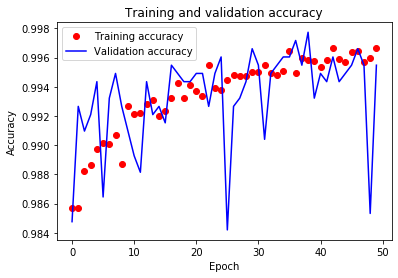

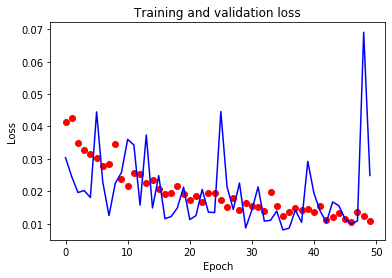

In [144]:
# Visualise and list all data in history
# ---------------------------------------------------    
print(adam.history.keys())

accuracy= adam.history['accuracy']
val_accuracy=adam.history['val_accuracy']
loss=adam.history['loss']

val_loss=adam.history['val_loss']

epochs=range(len(accuracy))
fig = plt.figure()
plt.plot(epochs, accuracy,'ro',  label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
fig.savefig('accuracy.png')
plt.legend()
fig = plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
fig.savefig('loss.png')
#plt.legend()
plt.show()

In [145]:
# Predict labels: 
predicted_classes= model.predict(x_test)

predicted_classes=np.argmax(np.round(predicted_classes), axis=1)

In [146]:
rounded_predictions = model.predict_classes(x_test, batch_size=128, verbose=0)
rounded_predictions[1]

1

In [147]:
import numpy as np
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

1

[2020-05-02 18:52:15 RAM62.9% 0.7GB] Confusion matrix, without normalization
[2020-05-02 18:52:15 RAM62.9% 0.7GB] [[865   1]
 [  7 898]]
[2020-05-02 18:52:15 RAM62.9% 0.7GB] Normalized confusion matrix
[2020-05-02 18:52:15 RAM62.9% 0.7GB] [[1.   0.  ]
 [0.01 0.99]]


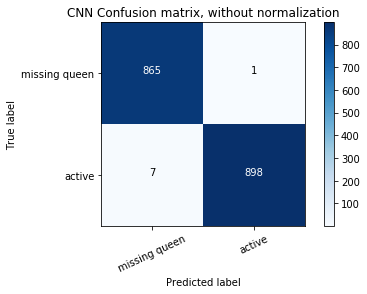

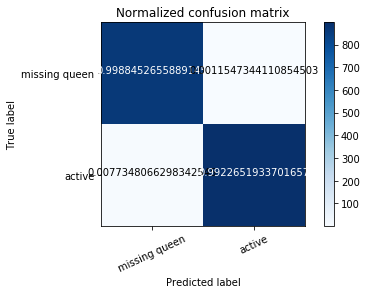

[2020-05-02 18:52:16 RAM62.9% 0.7GB] 
Clasification report CNN:
                precision    recall  f1-score   support

missing_queen       0.99      1.00      1.00       866
       active       1.00      0.99      1.00       905

     accuracy                           1.00      1771
    macro avg       1.00      1.00      1.00      1771
 weighted avg       1.00      1.00      1.00      1771



In [148]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(rounded_labels, rounded_predictions)
#cm
fig = plt.figure()
# Compute confusion matrix
cnf_matrix = confusion_matrix(rounded_labels, rounded_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='CNN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
target_names=['missing_queen', 'active']
print ('\nClasification report CNN:\n', classification_report(rounded_labels, rounded_predictions, target_names=target_names ))